# Projet n°7 : Implémenter_un_modele_de_scoring

- Dans cette troisième partie du projet : 

    Après avoir réaliser une exploration et une préparation des données,nous pouvons passer à la construction d'un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

    - **Objectif du notebook**:

        - L'objectif de ce notebook est d'évaluer et de comparer différentes approches de classification binaire sur notre jeu de données, en mettant l'accent sur la robustesse des modèles face à un déséquilibre de classes et sur l'optimisation des métriques métier pertinentes.

    
    - **Rappel du contexte**:

        - **Classification binaire**. On a seulement 2 cas ici, les clients défaillants (**1** - clients qui rencontrent des problèmes pour rembourser leur prêt) et non-défaillants (**0** - Aucun problèmes à signaler) 
        Chaque observation doit être assignée à une des deux classes possibles.

        - **Déséquilibre de classes** : La classe des clients défaillants est beaucoup plus rare que la classe des non défaillants (Rappel - on a **91 %** de clients appartenant à la classe *négative* (**0**) contre **8 %** pour les clients appartenant à la classe *positive* (**1**)). Cela implique que les modèles peuvent être biaisés vers la classe majoritaire si aucune précaution n’est prise.

        - **Déséquilibre du coût métier** : Les faux négatifs (FN - mauvais client prédit bon client) sont beaucoup plus coûteux que les faux positifs (FP - bon client prédit mauvais client). Dans les faits, prédir un mauvais client comme bon client à des conséquences bien plus néfaste puisque la perte impact directement le capital de l'entreprise alors que perdre un bon client prédit mauvais client est moins pénalisant puisque cela impacte la marge réalisée entre le capital initialement prêté qui est inférieur au capital remboursé (intêrets etc...). Cela guide donc le choix des métriques et des seuils de décision.


    - **Points Méthodologiques**: 

        - **Choix d'un algorithme** : On testera différents algorithme de classification des données pour trouver ceux qui semblent être les plus performants pour notre jeu de données et en prenant en compte les différents scores.

        - **Choix des données** : Nous disposons de plusieurs jeux de données, **8** dataframes avec **4 méthodes d'imputations** uniques (median/mode; median/missing; iterative/mode et Nan/missing) découpé en *2* utilisations distinctes puisque l'on a 4 dataframes conçus pour les *modèles linéaires* et 4 dataframes conçus pour les modèles *non linéaires* (ajout de flag missing pour ces 4 dataframes et gestion des corrélations moins stricte pour ces derniers)

        - **Métriques métier** : Les métriques classiques comme l’accuracy sont insuffisantes dans ce contexte. Nous nous concentrons donc sur la précision, le rappel, le F1-score pondéré, et l’AUC, qui reflètent mieux l’impact réel des erreurs sur le métier.

        - **Optimisation des modéles** : Nous utiliserons la cross-validation pour estimer la performance des modèles de manière fiable et éviter les résultats trop optimistes liés à un simple découpage train/test (overfitting).
        Nous testerons différentes techniques de traitement du déséquilibre des classes pour éviter que cela n'impacte la qualité des prédictions des modèles. Les hyperparamètres sont optimisés uniquement sur l’ensemble d’entraînement et de validation. L’ensemble de test reste strictement réservé à l’évaluation finale, garantissant une mesure réaliste de la performance.



In [2]:
# Import des librairies nécessaires au projet. 

import sys
sys.path.append("../src")

from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[0]
INPUT_DIR = PROJECT_ROOT / "data" / "Dataframes_modelisation"
OUTPUT_DIR = PROJECT_ROOT / "data" / "final_data"
MODEL_DIR = PROJECT_ROOT / "api" / "model_prod"

import numpy as np
import pandas as pd 
import missingno as msno
import re
import os
import pickle
import joblib
import kaleido
import plotly
import time
import gc

from mltools import *

import math
from collections import Counter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.utils.class_weight import compute_sample_weight
from imblearn.under_sampling import RandomUnderSampler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import optuna

import mlflow
mlflow.set_tracking_uri("file:C:/Users/Caomghin/Desktop/Implementer_un_modele_de_scoring/mlruns")
import mlflow.sklearn

import shap

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'png' #plotly_mimetype vscode

c:\Users\Caomghin\miniforge3\envs\projet_7_DS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importation des données

In [3]:
# Récupération des dataframes principaux (application train/test)

dfs = {}

file_names = [
    "df_train_median_mode_linear",
    "df_train_median_missing_linear",
    "df_train_iterative_mode_linear",
    "df_train_nan_missing_linear",
    "df_train_median_mode",
    "df_train_median_missing",
    "df_train_iterative_mode",
    "df_train_nan_missing",
    "df_test_median_mode_linear",
    "df_test_median_missing_linear",
    "df_test_iterative_mode_linear",
    "df_test_nan_missing_linear",
    "df_test_median_mode",
    "df_test_median_missing",
    "df_test_iterative_mode",
    "df_test_nan_missing",
]

for name in file_names:
    file_path = INPUT_DIR / f"{name}.pkl"
    with open(file_path, "rb") as f:
        dfs[name] = pickle.load(f)

# Réassignation des dataframes dans le notebook à l'aide de dictionnaire qui facilite l'utilisation des données finales:

train_dfs = {
    "median_mode_linear": dfs["df_train_median_mode_linear"],
    "median_missing_linear": dfs["df_train_median_missing_linear"],
    "iterative_mode_linear": dfs["df_train_iterative_mode_linear"],
    "nan_missing_linear": dfs["df_train_nan_missing_linear"],

    "median_mode": dfs["df_train_median_mode"],
    "median_missing": dfs["df_train_median_missing"],
    "iterative_mode": dfs["df_train_iterative_mode"],
    "nan_missing": dfs["df_train_nan_missing"]
}

test_dfs = {
    "median_mode_linear": dfs["df_test_median_mode_linear"],
    "median_missing_linear": dfs["df_test_median_missing_linear"],
    "iterative_mode_linear": dfs["df_test_iterative_mode_linear"],
    "nan_missing_linear": dfs["df_test_nan_missing_linear"],

    "median_mode": dfs["df_test_median_mode"],
    "median_missing": dfs["df_test_median_missing"],
    "iterative_mode": dfs["df_test_iterative_mode"],
    "nan_missing": dfs["df_test_nan_missing"]
}

In [4]:
# Visualisation d'un échantillon d'un des dataframes linear. 

train_dfs["median_mode_linear"].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_ANNUITY,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,FLAG_MOBIL,...,INST_INST_DAYS_LATE_TREND_MEAN_MAX,INST_INST_DAYS_LATE_TREND_MEAN_MIN,INST_INST_DAYS_LATE_TREND_MAX_MIN,INST_INST_DAYS_LATE_TREND_MIN_MEAN,INST_INST_DAYS_LATE_TREND_MIN_MAX,INST_INST_PAYMENT_DIFF_TREND_MEAN_MEAN,INST_INST_PAYMENT_DIFF_TREND_MEAN_MAX,INST_INST_PAYMENT_DIFF_TREND_MEAN_MIN,INST_INST_PAYMENT_DIFF_TREND_MAX_MIN,INST_MAX_INSTALMENT_NUMBER_MIN
0,100002,1,0,1,0,1,24700.5,0.018801,9,1,...,-0.500000,-0.500000,10,-16.000000,-16,0.0,0.0,0.0,0.0,19
1,100003,0,0,0,0,0,35698.5,0.003541,9,1,...,0.000000,-0.200000,4,-5.640000,-3,0.0,0.0,0.0,0.0,6
2,100004,0,1,1,1,1,6750.0,0.010032,26,1,...,3.000000,3.000000,8,-2.000000,-2,0.0,0.0,0.0,0.0,3
3,100006,0,0,0,0,1,29686.5,0.008019,9,1,...,7.500000,0.444444,12,-26.666666,-9,0.0,0.0,0.0,0.0,1
4,100007,0,0,1,0,1,21865.5,0.028663,9,1,...,0.384615,-1.062500,4,-17.939394,-2,0.0,0.0,0.0,0.0,10


In [4]:
# Visualisation des informations globales du dataframe linear.

train_dfs["median_mode_linear"].info(display, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307500 entries, 0 to 307499
Data columns (total 528 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    SK_ID_CURR                                                             307500 non-null  int32  
 1    TARGET                                                                 307500 non-null  int32  
 2    NAME_CONTRACT_TYPE                                                     307500 non-null  Int64  
 3    CODE_GENDER                                                            307500 non-null  Int64  
 4    FLAG_OWN_CAR                                                           307500 non-null  Int64  
 5    FLAG_OWN_REALTY                                                        307500 non-null  Int64  
 6    AMT_ANNUITY                                                       

In [4]:
calculate_missing_values(train_dfs["median_mode_linear"])

,Nbr_valeurs_manquantes,Pct_valeurs_manquantes


In [6]:
# Visualisation d'un échantillon d'un des dataframes non linear. 

train_dfs["median_mode"].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,...,INST_INST_DAYS_LATE_TREND_MAX_MIN,INST_INST_DAYS_LATE_TREND_MIN_MEAN,INST_INST_DAYS_LATE_TREND_MIN_MAX,INST_INST_PAYMENT_DIFF_TREND_MEAN_MEAN,INST_INST_PAYMENT_DIFF_TREND_MEAN_MAX,INST_INST_PAYMENT_DIFF_TREND_MEAN_MIN,INST_INST_PAYMENT_DIFF_TREND_MAX_MIN,INST_INST_PAYMENT_DIFF_TREND_MIN_MIN,INST_DAYS_ENTRY_PAYMENT_WAS_MISSING_SUM_MIN,INST_AMT_PAYMENT_WAS_MISSING_MEAN_MAX
0,100002,1,0,1,0,1,0,202500.0,24700.5,351000.0,...,10,-16.000000,-16,0.0,0.0,0.0,0.0,0.000000,0,0.0
1,100003,0,0,0,0,0,0,270000.0,35698.5,1129500.0,...,4,-5.640000,-3,0.0,0.0,0.0,0.0,0.000000,0,0.0
2,100004,0,1,1,1,1,0,67500.0,6750.0,135000.0,...,8,-2.000000,-2,0.0,0.0,0.0,0.0,0.000000,0,0.0
3,100006,0,0,0,0,1,0,135000.0,29686.5,297000.0,...,12,-26.666666,-9,0.0,0.0,0.0,0.0,0.000000,0,0.0
4,100007,0,0,1,0,1,0,121500.0,21865.5,513000.0,...,4,-17.939394,-2,0.0,0.0,0.0,0.0,-22632.523438,0,0.0


In [7]:
# Visualisation des informations globales du dataframe non linear.

train_dfs["median_mode"].info(display, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307500 entries, 0 to 307499
Data columns (total 872 columns):
 #    Column                                                                Non-Null Count   Dtype  
---   ------                                                                --------------   -----  
 0    SK_ID_CURR                                                            307500 non-null  int32  
 1    TARGET                                                                307500 non-null  int32  
 2    NAME_CONTRACT_TYPE                                                    307500 non-null  Int64  
 3    CODE_GENDER                                                           307500 non-null  Int64  
 4    FLAG_OWN_CAR                                                          307500 non-null  Int64  
 5    FLAG_OWN_REALTY                                                       307500 non-null  Int64  
 6    CNT_CHILDREN                                                          3075

- Globalement, on a essayé de mettre en place 2 type de dataframe, un qui est plus optimisé pour des modèles linéaires et un autre type pour les modèles non linéaire.
- Les corrélations ont été gérées différemment (corrélation de pearson inférieur à 0.80 pour les linear et corrélation de spearman inférieur à 0.90 pour les non linéaires) ce qui constitue d'ailleurs une première de sélection  de features structurelle. De plus, on a ajouté des flags missing pour les dataframes non linéaires et laisser les Nan en l'état lorsqu'il y en a.
- On peut d'ailleurs effectuer ici une autre vérification concernant ce choix de feature en regardant si il y a des variables constantes ou des doublons dans nos dataframes :

### Sélection de features (constante et doublons)

In [24]:
# Vérification de la présence de constante dans ce dataframe.

(train_dfs["median_mode_linear"].nunique(dropna=False) <= 1).sum()

10

In [6]:
# Nom des variables constantes de ce dataframe.

constant_cols = train_dfs["median_mode_linear"].columns[train_dfs["median_mode_linear"].nunique(dropna=False) <= 1]
constant_cols

Index(['NAME_TYPE_SUITE_MISSING', 'WALLSMATERIAL_MODE_MISSING',
       'PREV_NAME_TYPE_SUITE_MISSING_MEAN', 'PREV_NAME_TYPE_SUITE_MISSING_SUM',
       'CC_SK_DPD_MIN_MEAN', 'CC_SK_DPD_MIN_MAX', 'CC_SK_DPD_MIN_MIN',
       'CC_SK_DPD_DEF_MIN_MEAN', 'CC_SK_DPD_DEF_MIN_MAX',
       'CC_SK_DPD_DEF_MIN_MIN'],
      dtype='object')

- On retrouve ici des variables que l'on peut supprimer car ces dernières n'apportent aucune information pertinentes aux modèles en effet, elles ne contribuent pas à distinguer les différences entre chaque observation. Au contraire pour certains modèles d'apprentissage automatique, ces colonnes peuvent nuire aux performances en introduisant des données redondantes ou non pertinentes.
- Les supprimer permet donc de réduire la dimensionnalité de l'ensemble de données, d'améliorer l'éfficacité des calculs et améliorer l'interprétation d'un modèle.

In [25]:
# Suppression pour toutes les pairs train/test des variables constantes.

for key in train_dfs:

    df_train = train_dfs[key]
    df_test = test_dfs[key]

    constant_cols = [col for col in df_train.columns if df_train[col].nunique(dropna=False) <= 1]

    if constant_cols:

        train_dfs[key] = df_train.drop(columns=constant_cols)
        test_dfs[key] = df_test.drop(columns=constant_cols, errors="ignore")

    print(f"[{key}] constantes supprimées : {len(constant_cols)}")


[median_mode_linear] constantes supprimées : 10
[median_missing_linear] constantes supprimées : 6
[iterative_mode_linear] constantes supprimées : 10
[nan_missing_linear] constantes supprimées : 0
[median_mode] constantes supprimées : 59
[median_missing] constantes supprimées : 55
[iterative_mode] constantes supprimées : 59
[nan_missing] constantes supprimées : 55


In [26]:
# Vérification des changements avec le nombre de variable

for key in train_dfs:
    assert set(train_dfs[key].columns) - {"TARGET"} == set(test_dfs[key].columns), f"Colonnes train/test non alignées pour {key}"

In [27]:
# Vérification d'une différence de variables entre les deux dataframes train et test avec la même imputation.

cols_train = set(train_dfs["median_mode_linear"].columns)
cols_test = set(test_dfs["median_mode_linear"].columns)

# Colonnes présentes dans train mais pas dans test :
diff_train_test = cols_train - cols_test
print("Colonnes dans train mais pas dans test :", diff_train_test)

# Colonnes présentes dans test mais pas dans train :
diff_test_train = cols_test - cols_train
print("Colonnes dans test mais pas dans train :", diff_test_train)

Colonnes dans train mais pas dans test : {'TARGET'}
Colonnes dans test mais pas dans train : set()


In [28]:
# Vérification de la présence de doublons dans ce dataframe.

train_dfs["median_mode_linear"].T.duplicated().sum()

0

In [29]:
# Suppression pour toutes les pairs train/test des variables en double.

for key in train_dfs:

    df_train = train_dfs[key]
    df_test = test_dfs[key]

    dup_cols = df_train.T[df_train.T.duplicated()].index

    if len(dup_cols) > 0:
        
        train_dfs[key] = df_train.drop(columns=dup_cols)
        test_dfs[key] = df_test.drop(columns=dup_cols, errors="ignore")

    print(f"[{key}] doublons supprimés : {len(dup_cols)}")

[median_mode_linear] doublons supprimés : 0
[median_missing_linear] doublons supprimés : 0
[iterative_mode_linear] doublons supprimés : 0
[nan_missing_linear] doublons supprimés : 11
[median_mode] doublons supprimés : 216
[median_missing] doublons supprimés : 215
[iterative_mode] doublons supprimés : 214
[nan_missing] doublons supprimés : 213


In [30]:
# Vérification des changements avec le nombre de variable

for key in train_dfs:
    assert set(train_dfs[key].columns) - {"TARGET"} == set(test_dfs[key].columns), f"Colonnes train/test non alignées pour {key}"

In [31]:
# Vérification d'une différence de variables entre les deux dataframes train et test avec la même imputation.

cols_train = set(train_dfs["median_mode_linear"].columns)
cols_test = set(test_dfs["median_mode_linear"].columns)

# Colonnes présentes dans train mais pas dans test :
diff_train_test = cols_train - cols_test
print("Colonnes dans train mais pas dans test :", diff_train_test)

# Colonnes présentes dans test mais pas dans train :
diff_test_train = cols_test - cols_train
print("Colonnes dans test mais pas dans train :", diff_test_train)

Colonnes dans train mais pas dans test : {'TARGET'}
Colonnes dans test mais pas dans train : set()


- Ces deux étapes étant faite, il est possible d'aller plus loin dans la sélection de feature en s'occupant par exemple des variables quasi-constantes. 
- On peut aussi aller plus loin en réalisant notamment non plus une *sélection par filtre*(***Filter methods**) (corrélation entre les variables, constante, doublons etc..) mais une sélection utilisant un modèle (**Embedded methods** ou Model-based feature selection) qui va calculer la contribution de chaque variable, ce qui permettra d'écarter celles peu utiles ou complétement non utilisées (feature importance).
- Il y a aussi une autre grande catégorie de méthode, les **Wrapper methods** basée sur des boucles d'évaluations qui évalue la performance du modèle utilisé pour chaque sous-ensemble de features (Forward selection, Backward elimination ou RFE (Recursive Feature Elimination)).

- En pratique il serait préférable d'utiliser ici les **Embedded methods** car elles sont plus adaptées lorsque l'on cherche à obtenir un modèle robuste qui généralise bien (donc pour le dataset de test sans target), avec une bonne stabilité (préférable lorsque l'on veut réutiliser le modèle dans le temps) et avec un coût de calcul plus faible. Car pour les **Wrapper methods**, on est plus sur une phase de Tuning en maximisant les performances par exemple pour une métrique donnée (AUC, F1, etc ..) mais puisque l'on chercher la combinaison optimal de variable qui donne le meilleur résultat possible et étant donné le grand nombre de variables cela peut devenir très coûteux pour converger et aussi généré de l'overfitting puisque l'on maximise au mieux en utilisant un ensemble précis de variable.

Donc avant de continuer sur une éventuelle sélection de variable plus poussée (ce qui n'est pas garanti car nous avons un temps limité), on va passer dans un premier temps à la réalisation d'une baseline qui servira de référence afin d'évaluer les expérimentations ultérieures qui suivront puisque l'on regarde ici les résultats que l'on a sans aucune optimisation, travail sur le déséquilibre de classes et du coût métier ou une éventuelle sélection de variable plus poussée.

### Mise en place des modèles de référence (Baselines)

- Comme on l'a dit précédemment, l'objectif de cette section est de créer un point de référence simple et naif afin, d'évaluer par la suite si les performances de nos modèles après optimisations, sont réellement efficaces et utiles pour constituer le pipeline final qui servira dans le *Dashboard intéractif*.
- Pour cela, puisque l'on a fait une distinction entre les modèles *linéaires* et *non linéaire*, on utilisera deux profils de baselines différentes que l'on appliquera à chacun des des dataframes. Cependant globalement, il est bon de noter que l'on a pas ici de tuning, des paramétres par défaut et un split simple des données (train/validation/test).

#### - Baseline pour les dataframes linéaires

In [ ]:
# Rappel du fait qu'il reste des variables à encoder (avec un nombre important de modalité)

train_dfs["median_mode_linear"].select_dtypes("object").nunique()

OCCUPATION_TYPE      18
ORGANIZATION_TYPE    58
dtype: int64

- Les données sont séparées en ensembles d’entraînement, de validation et de test avant tout prétraitement, afin d’éviter toute fuite d’information. Les étapes de standardisation et d’encodage sont ensuite apprises uniquement sur l’ensemble d’entraînement via un pipeline sklearn.
- D'ailleurs toutes les étapes de la Baseline sont réalisées à l'aide d'un **pipeline** qui permet d'enchaîner automatiquement des étapes de traitement pour transformer quelque chose d’une entrée vers un résultat final, de manière structurée, reproductible et fiable. 
- Donc ici, on sépare les données au préalable qui ne s'inscrit pas le pipeline (car cette partie permet de décider quelles données vont servir à apprendre et tester nos modèles + risque de data leakage si les données de test sont inclues dans certains processus de transformation) puis notre pipeline va nettoyer, transformer, entraîner un modèle et évaluer les résultats. 
- Le pipeline permet donc d'automatiser et de reproduire ce processus sur les différents dataframes d'un même type (linear/non linear) et cela permet de paralléliser certaines étapes ce qui est utile sur de gros volumes de données.

In [ ]:
# Mise en place d'une fonction générique qui construit un pipeline pour les dataframes de la baseline linéaire.

def build_baseline_linear_pipeline(df, categorical_features, target_col="TARGET", min_frequency=10):
    
    numerical_features = [col for col in df.columns if col not in categorical_features + [target_col]]

    numeric_transformer = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("onehot", OneHotEncoder(
            handle_unknown="ignore",
            min_frequency=min_frequency
        ))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    model = LogisticRegression(
        max_iter=1000,
        random_state=42
    )

    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    return pipeline

In [ ]:
# Utilisation de la baseline linear sur train_dfs["median_mode_linear"] avec MLflow pour garder un historique de cette expérience.

df_name = "median_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_baseline_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_linear")

with mlflow.start_run(run_name=f"baseline_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "rerun_notebook")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:35:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpglcvuwdw\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:35:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode_linear ===
Accuracy : 0.9197411424204485
F1-score : 0.07426856714178545
Precision : 0.5395095367847411
Recall : 0.03987915407854985
AUC : 0.77383278036107

Classification report :

              precision    recall  f1-score   support

           0      0.922     0.997     0.958     56536
           1      0.540     0.040     0.074      4965

    accuracy                          0.920     61501
   macro avg      0.731     0.518     0.516     61501
weighted avg      0.891     0.920     0.887     61501



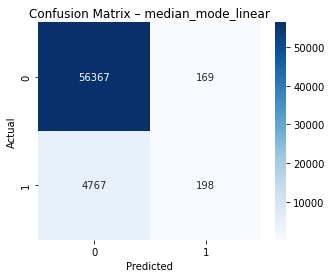

In [127]:
# Affichage des résultats pour la baseline train_dfs["median_mode_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- Avec ce premier dataframe linéaire, on peut expliquer le choix du modèle et des métriques pour cette baseline mais aussi pour le reste de la modélisation en général :

    - **Choix des métriques** :

        - **L'accuracy** est un souvent un choix par défaut lorsque l'on souhaite évaluer un modèle (mesure la proportion de prédictions correctes parmi toutes les prédictions du modèle). Toutefois ici, nous sommes dans un problème de *classification binaire* dont les effectifs sont très **déséquilibré** donc cette métrique devient facilement obsoléte. En effet, il est très facile de prédir "juste" lorsque l'on retrouve pour plus de 90 % du temps la même réponse (91 % de 0 pour 9 % de 1). Ce qui explique ici l'excellent score obtenu de 0.92 quand le maximum possible est de 1, c'est pourquoi cette métrique ne peut pas être la métrique principale.

        - **L'AUC ROC** est une métrique souvent mieux approprié pour notre contexte car elle mesure la capacité du modèle à bien *classer les positifs au-dessus des négatifs*, indépendamment du seuil de décision (seuil qui décide si une observation est susceptible d'être de la classe positive par défaut 0.5).
        Donc pour cette métrique on regarde si le modèle est capable de bien **discriminer** chaque classe en terme de score peu importe le niveau de seuil choisi. Pour cela on a une courbe et plus celle-ci est proche de **1** plus le modèle est capable de distinguer les classes (score élevé pour la classe positive et faible pour l'autre), à l'inverse plus elle est proche de **0.5** plus les prédictions sont réalisé au hasard (score mélangés au hasard entre les classes).

        - Les métriques **Précision/Recall/F1** sont particulièrement utiles ici car la classe positive est très rare et les *Faux Négatifs*/*Faux positifs* n'ont pas le même impact dans notre context métier. En effet, la précision (qui donne la fiabilité des positifs prédits parmis toutes les prédicitions positives) et le Recall (qui mesure la capacité de ne pas rater les positifs) permettent de chosir le seuil optimal pour notre problématique métier.
        Pour cette problématique, il faut prendre en compte que les *faux négatifs* ont impact bien plus **néfaste** que les *faux positifs* donc si l'AUC ROC permet de mesurer la capacité de classement des clients d'un modèle, ces 3 métriques permettent de *définir* notre **seuil de décision** pour *classer* un individu *positif* ou *négatif* en mettant une importance plus grande sur le fait de diminuer le nombre de Faux Négatif que le nombre de Faux positif. 
        Pour finir, on a F1 qui est un compromis entre les deux scores précédents donc un F1 élevé signifie un Recall et une précision élevé mais selon la problématique la précison et le Recall n'ont pas la même importance donc ce n'est pas forcément la métrique à optimiser en première (ici on préfére maximiser le Recall car son coût est plus pénalisant d'un point de vue métier).
        ***A noter que ces trois métriques sont celles de la classe 1 (défaillant) car par défaut avec scikit learn on a pos_label=1*** (on laisse cette affichage puisque c'est ce qui nous intéresse ici)
    
    - **Choix du modèle** pour la baseline :

        - On a choisi ici la régression logistique qui est le *standard académique et industriel* pour les problèmes de classification binaire. Elle sert de point zéro donc tout modèle plus complexe doit faire mieux qu’elle pour être justifié.
        - Les coefficients ont un sens direct (effet positif / négatif sur la probabilité) donc plus facilement interprétable.
        - Le modèle est stable et robuste car peu sensible aux hyperparamètres et faible risque de faire de l'overfitting.
        - La régression logistique fournit une *référence simple*, *interprétable* et *reproductible* contre laquelle tous les modèles ultérieurs seront comparés.


- Si l'on regarde les résultats de ce premier dataframe, sans surprise le modèle performe bien dans l'ensemble comme on peut le voir avec l'accuracy score élevé de **0.91** du fait, d'une classe majoritaire très largement représentée ce qui biaise l'interprétation de ce "bon" résultat.
- En effet paradoxalement, la classe minoritaire qui recense environ **5000** observations (contre 56 000 pour la classe majoritaire) donne de très mauvais résultats puisque l'on a seulement **3.9 %** des prédictions qui sont *"justes"*, on voit donc ici la contrainte que représente ce déséquilibre dans la répartition des classes.
- Pour rappel, cette *classe minoritaire* représente la *classe positive* et la classe la plus *importante d'un point de vue métier* puisque chaque *mauvaise prédicition* de cette classe entraine un **coût très important** pour l'entreprise or ici il n'y a quasiment que des erreurs. Il faut donc minimiser ce coût au maximum en priorisant le score *Recall*.

In [ ]:
# Fonction pour sauvegarder les résultats des baselines pour comparaison

def build_baseline_results_row(
    dataset_name,
    model_name,
    y_true,
    y_pred,
    y_proba
):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Dataset": dataset_name,
        "Model": model_name,
        "Accuracy Test": accuracy_score(y_true, y_pred),
        "AUC Test": roc_auc_score(y_true, y_proba),
        "Precision Test": precision_score(y_true, y_pred, zero_division=0),
        "Recall Test": recall_score(y_true, y_pred, zero_division=0),
        "F1 Test": f1_score(y_true, y_pred, zero_division=0),
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }

    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)

In [128]:
# Sauvegarde des résultats pour train_dfs["median_mode_linear"]

baseline_results = []

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation de la baseline linear sur train_dfs["median_missing_linear"] avec MLflow pour garder un historique de cette expérience.

df_name = "median_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_baseline_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_linear")

with mlflow.start_run(run_name=f"baseline_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "rerun_notebook")
    
    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:36:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpq68dkc54\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_missing_linear ===
Accuracy : 0.9197574023186614
F1-score : 0.0784313725490196
Precision : 0.5384615384615384
Recall : 0.04229607250755287
AUC : 0.7759970208895408

Classification report :

              precision    recall  f1-score   support

           0      0.922     0.997     0.958     56536
           1      0.538     0.042     0.078      4965

    accuracy                          0.920     61501
   macro avg      0.730     0.520     0.518     61501
weighted avg      0.891     0.920     0.887     61501



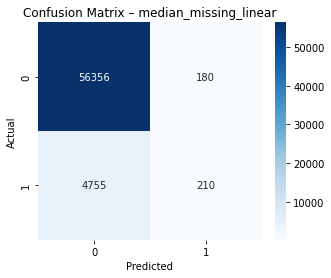

In [130]:
# Affichage des résultats pour la baseline train_dfs["median_missing_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- Résultat assez similaire dans l'ensemble

In [131]:
# Sauvegarde des résultats pour train_dfs["median_missing_linear"]

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation de la baseline linear sur train_dfs["iterative_mode_linear"] avec MLflow pour garder un historique de cette expérience.

df_name = "iterative_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_baseline_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_linear")

with mlflow.start_run(run_name=f"baseline_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "rerun_notebook")
    
    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:37:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpx9wi_d_v\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:37:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for iterative_mode_linear ===
Accuracy : 0.9205866571275264
F1-score : 0.15149409312022238
Precision : 0.5512010113780025
Recall : 0.0878147029204431
AUC : 0.8065577587045928

Classification report :

              precision    recall  f1-score   support

           0      0.925     0.994     0.958     56536
           1      0.551     0.088     0.151      4965

    accuracy                          0.921     61501
   macro avg      0.738     0.541     0.555     61501
weighted avg      0.895     0.921     0.893     61501



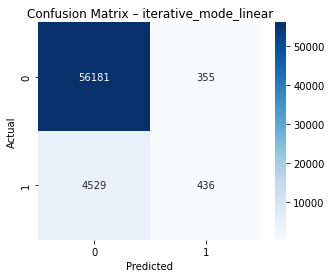

In [133]:
# Affichage des résultats pour la baseline train_dfs["iterative_mode_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- Pour ce troisième dataframe, on a des résultats légérement différent surtout au niveau des prédictions que l'on doit optimiser puisqu'ici le nombre de défaillant qui a bien été prédit comme défaillant à bien augmenter par rapport aux deux autres dataframes (X2 des dataframes précédents) 
- Néanmoins cela a eu un impact sur les clients non défaillants prédit comme défaillant puisque leur nombre a évolué dans les mêmes proportions (donc ici, résultat moins bon que précédemment)

In [134]:
# Sauvegarde des résultats pour train_dfs["iterative_mode_linear"]

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

- Pour finir, il reste le dataframe **nan_missing_linear** à tester avec la baseline toutefois cela n'est pas possible ici car par principe d'imputation ce dataframe contient des valeurs manquantes non imputées.
- Le modèle linéaire utilisés pour la baseline ne supportant pas les NaN, ce jeu de données est donc exclu de la baseline linéaire (car on pourrait l'imputer mais cela deviendrait incohérent avec la logique d'expérimentation ici)
- Il sera évalué uniquement avec des modèles non linéaires capable de gérer les Nan.

Ensuite, on passe aux dataframes non linear en adaptant la baseline à ce type de dataframes.

#### - Baseline pour les dataframes non linéaires

In [32]:
# Gestion des types Int64 et Float64 problèmatique à cause du format pd.NA

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
target_col = "TARGET"

for name, df in train_dfs.items():
    numerical_features = [col for col in df.columns if col not in categorical_features + [target_col]]
    train_dfs[name][numerical_features] = (df[numerical_features].astype("float64").replace({pd.NA: np.nan}))

for name, df in test_dfs.items():
    numerical_features = [col for col in df.columns if col not in categorical_features]
    test_dfs[name][numerical_features] = (df[numerical_features].astype("float64").replace({pd.NA: np.nan}))

In [60]:
# Mise en place d'une fonction générique qui construit un pipeline pour les dataframes de la baseline non linéaire.

def build_non_linear_baseline_pipeline(df, categorical_features, target_col="TARGET", min_frequency=10):
    
    numerical_features = [col for col in df.columns if col not in categorical_features + [target_col]]

    # Encodage léger uniquement pour les catégories
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=min_frequency
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_features),
            ("num", "passthrough", numerical_features)
        ]
    )

    model = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=200,
        random_state=42
    )

    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    return pipeline

In [ ]:
# Utilisation de la baseline non linear sur train_dfs["median_mode"] avec MLflow pour garder un historique de cette expérience.

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_non_linear_baseline_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_non_linear")

with mlflow.start_run(run_name=f"baseline_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:38:10 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmplr82r7ex\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode ===
Accuracy : 0.9202614591632656
F1-score : 0.07191521574564724
Precision : 0.5956112852664577
Recall : 0.038267875125881166
AUC : 0.7846525580008126

Classification report :

              precision    recall  f1-score   support

           0      0.922     0.998     0.958     56536
           1      0.596     0.038     0.072      4965

    accuracy                          0.920     61501
   macro avg      0.759     0.518     0.515     61501
weighted avg      0.896     0.920     0.887     61501



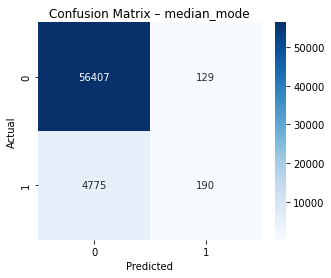

In [136]:
# Affichage des résultats pour la baseline train_dfs["median_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- Pour le choix du modèle ici, on a prit ici **HistGradientBoostingClassifier** qui repose sur un compromis volontaire entre puissance, simplicité et rigueur méthodologique.
- Après la baseline linéaire, l’objectif n’est pas encore l'optimisation, mais de répondre à une question clé, est ce que les *relations non linéaires* entre les variables apportent-elles un **gain significatif** par rapport aux *relations linéaires*.
- Ce modèle permet donc de *capturer des interactions complexes* entre variables sans recourir immédiatement à des frameworks plus lourds (XGBoost, LightGBM, CatBoost). Il fonctionne bien avec peu de réglages et limite naturellement l’overfitting (boosting, la discrétisation des features).
- De plus par rapport à Random Forest qui aurait pû être le choix par défaut, HGB gère nativement les *valeurs manquantes* qui peuvent être structurelles et informatives, ce qui évite une imputation forcée.

- Pour ce qui est des résultats du premier dataframe, cela différe peu de la baseline linéaire (résultats à peine plus élevé pour l'ensemble des métriques).

In [137]:
# Sauvegarde des résultats pour train_dfs["median_mode"]

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation de la baseline non linear sur train_dfs["median_missing"] avec MLflow pour garder un historique de cette expérience.

df_name = "median_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_non_linear_baseline_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_non_linear")

with mlflow.start_run(run_name=f"baseline_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:44:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmplx4qac9m\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:44:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_missing ===
Accuracy : 0.9201638997739874
F1-score : 0.06760349411317888
Precision : 0.5913621262458472
Recall : 0.03585095669687815
AUC : 0.784652297937836

Classification report :

              precision    recall  f1-score   support

           0      0.922     0.998     0.958     56536
           1      0.591     0.036     0.068      4965

    accuracy                          0.920     61501
   macro avg      0.757     0.517     0.513     61501
weighted avg      0.895     0.920     0.886     61501



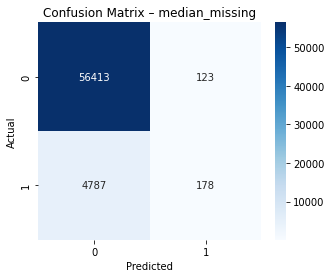

In [140]:
# Affichage des résultats pour la baseline train_dfs["median_missing"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- La précision, l'accuracy et l'AUC sont meilleurs ici que pour la version linéaire.

In [141]:
# Sauvegarde des résultats pour train_dfs["median_missing"]

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation de la baseline non linear sur train_dfs["iterative_mode"] avec MLflow pour garder un historique de cette expérience.

df_name = "iterative_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_non_linear_baseline_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_non_linear")

with mlflow.start_run(run_name=f"baseline_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:44:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmps9da5oia\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:44:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for iterative_mode ===
Accuracy : 0.9530251540625355
F1-score : 0.6053817784455675
Precision : 0.9405772495755518
Recall : 0.4463242698892246
AUC : 0.9467451586605031

Classification report :

              precision    recall  f1-score   support

           0      0.954     0.998     0.975     56536
           1      0.941     0.446     0.605      4965

    accuracy                          0.953     61501
   macro avg      0.947     0.722     0.790     61501
weighted avg      0.952     0.953     0.945     61501



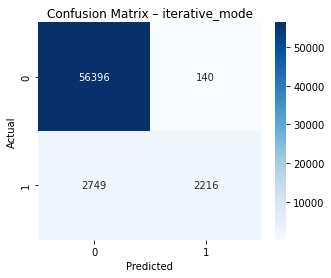

In [143]:
# Affichage des résultats pour la baseline train_dfs["iterative_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- Pour ce troisième dataframe, on a ici un résultat plutôt intéressant surtout pour la qualité de prédiction de la classe positive qui est bien meilleure que les autres baselines jusque maintenant.
- En effet comme on peut le voir, le nombre de bonnes prédictions pour la classe positive est bien plus important puisque comme on peut le voir la Précision et le Recall ont grandement augmentés et c'est exactemement ce qu'on veut dans notre contexte métier (même si c'est un cas particulier sur lequel on reviendra à la fin).

In [144]:
# Sauvegarde des résultats pour train_dfs["iterative_mode"]

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation de la baseline non linear sur train_dfs["nan_missing"] avec MLflow pour garder un historique de cette expérience.

df_name = "nan_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_non_linear_baseline_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_non_linear")

with mlflow.start_run(run_name=f"baseline_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:45:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpj0c1_jy1\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:45:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for nan_missing ===
Accuracy : 0.9199037414025788
F1-score : 0.0691609977324263
Precision : 0.5596330275229358
Recall : 0.036858006042296075
AUC : 0.7848147090479544

Classification report :

              precision    recall  f1-score   support

           0      0.922     0.997     0.958     56536
           1      0.560     0.037     0.069      4965

    accuracy                          0.920     61501
   macro avg      0.741     0.517     0.514     61501
weighted avg      0.893     0.920     0.886     61501



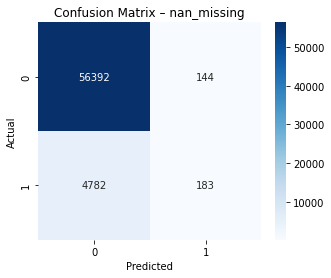

In [146]:
# Affichage des résultats pour la baseline train_dfs["nan_missing"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [147]:
# Sauvegarde des résultats pour train_dfs["nan_missing"]

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

- On rajoute aussi la version linear de nan_missing pour avoir une baseline.

In [ ]:
# Utilisation de la baseline non linear sur train_dfs["nan_missing_linear"] avec MLflow pour garder un historique de cette expérience.

df_name = "nan_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_non_linear_baseline_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("baseline_non_linear")

with mlflow.start_run(run_name=f"baseline_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

2025/12/29 01:46:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpt6q52h80\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 01:46:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for nan_missing_linear ===
Accuracy : 0.919562283540105
F1-score : 0.06004180125403762
Precision : 0.5302013422818792
Recall : 0.03182275931520644
AUC : 0.7840689054312692

Classification report :

              precision    recall  f1-score   support

           0      0.921     0.998     0.958     56536
           1      0.530     0.032     0.060      4965

    accuracy                          0.920     61501
   macro avg      0.726     0.515     0.509     61501
weighted avg      0.890     0.920     0.885     61501



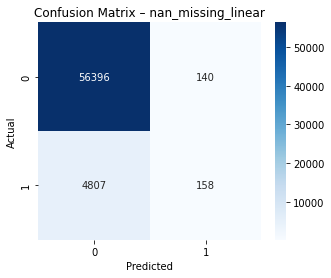

In [149]:
# Affichage des résultats pour la baseline train_dfs["nan_missing_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [150]:
# Sauvegarde des résultats pour train_dfs["nan_missing_linear"]

baseline_results.append(
    build_baseline_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [151]:
baseline_results_df = pd.DataFrame(baseline_results)
baseline_results_df

,Dataset,Model,Accuracy Test,AUC Test,Precision Test,Recall Test,F1 Test,TN,FP,FN,TP
0,median_mode_linear,LogisticRegression (OHE),0.919741,0.773833,0.539510,0.039879,0.074269,56367,169,4767,198
1,median_missing_linear,LogisticRegression (OHE),0.919757,0.775997,0.538462,0.042296,0.078431,56356,180,4755,210
2,iterative_mode_linear,LogisticRegression (OHE),0.920587,0.806558,0.551201,0.087815,0.151494,56181,355,4529,436
3,median_mode,HistGradientBoostingClassifier (OHE),0.920261,0.784653,0.595611,0.038268,0.071915,56407,129,4775,190
4,median_missing,HistGradientBoostingClassifier (OHE),0.920164,0.784652,0.591362,0.035851,0.067603,56413,123,4787,178
5,iterative_mode,HistGradientBoostingClassifier (OHE),0.953025,0.946745,0.940577,0.446324,0.605382,56396,140,2749,2216
6,nan_missing,HistGradientBoostingClassifier (OHE),0.919904,0.784815,0.559633,0.036858,0.069161,56392,144,4782,183
7,nan_missing_linear,HistGradientBoostingClassifier (OHE),0.919562,0.784069,0.530201,0.031823,0.060042,56396,140,4807,158


- Dans l'ensemble, les résultats sont assez similaires entre les deux types de baselines toutefois il y a un dataframe qui se démarque des autres, **'iterative_mode'**, qui montre d'assez bons résultats pour un modèle de référence.

- Il faut d'ailleurs que l'on explique pourquoi on obtient d'aussi bons résultats alors que les résultats devraient être similaires aux autres. En effet, dans la méthodologie que l'on a employer dans le prétraitement des données, nous avons bien fait une imputation (pour tous les types) sur le dataset train initial (application_train) séparément du dataset test initial, ce qui permet d'éviter toutes fuites d'informations entre le train et le test.
- Cependant ici, *l'imputation itérative* se distingue des autres car elle apprend des relations multivariées complexes de nos variables donc même sans fuite d'informations, elle injecte de *"l’information globale"* dans les données. 
- Or dans le contexte de ce projet le dataset de test n'est pas vraiment utilisé pour évaluer les performances des modèles mais pour le dashboard final et c'est le dataset train qui est split en train/val/test donc les modèles comme HGB qui capture les intéractions complexes arrivent plus facilement à trouver les patterns, induits par cette imputation, très proches de la vérité (puisque Iterative Imputer apprend des relations entre toutes les variables qui sont plus ou moins corrélées à la cible donc l'imputation sur de nombreuses variables "ajoute de l'information" supplémentaire donc les patterns sont plus facile à détecter et à exploiter pour le modèle dans notre cas de figure particulier)
- Puisque cette situation ne permet pas d'avoir une **observation réaliste** du fait du *biais* introduit ici (les résultats sont affectés par un biais dit optimiste ou "information bleed") on ne prendra donc pas cette imputation en compte pour la suite, afin de garder des performances réalistes (pour résoudre ce problème, une solution possible serait de repartir des données d'origines, faire un split sur application train puis faire l'imputation sur les 3 jeux obtenus séparément pour enlever ce biai).

Après avoir établi des baselines linéaire et non linéaire claires et interprétables, on a un point de comparaison minimal et on peut maintenant passer à la correction du déséquilibre entre la classe positive et négative. 

### Correction du déséquilibre de classe

- Dans cette section, on vise à corriger le *biais* induit par le déséquilibre des classes, indépendamment de toute considération métier ou tout autres optimisations, afin d’évaluer la capacité intrinsèque des modèles à *détecter la classe minoritaire*.
- On prendra de nouveau ici les mêmes modèles que pour les *baselines linéaire et non linéaire* pour observer l'impact d'une stratégie de rééquilibrage et comparer facilement avec nos modèles de références sans rien changer de plus (permet d'identifier la cause réelle de l'évolution des résultats).

#### - Pondération des classes (class weight)

- Donc comme première méthode, on utilisera la **pondération des classes** (class_weight) qui est un choix simple puisque cette méthode nécessite aucun pré-traitement complexe et ne modifie pas les données (pas de fuite d'information). De plus, on ne modifie que la *fonction de perte* afin que les erreurs de la classe minoritaire (clients défaillant où TARGET = 1) coûtent beaucoup plus cher ainsi, le modèle est obligé de prendre cet aspect en compte.
- Enfin cette solution préserve l'information (pas de suppression ou exemples artificiels), n'introduit pas de biais et elle est compatible avec de nombreux modèles.

In [ ]:
# Mise en place d'une fonction générique qui construit un pipeline adoptant la pondération des classes pour Logistic Regression. 

def build_class_weight_linear_pipeline(df, categorical_features, target_col="TARGET", min_frequency=10):
    
    numerical_features = [col for col in df.columns if col not in categorical_features + [target_col]]

    # Prétraitement numérique
    numeric_transformer = Pipeline([
        ("scaler", StandardScaler())
    ])

    # Prétraitement catégoriel
    categorical_transformer = Pipeline([("onehot", OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=min_frequency
        ))
    ])

    # Préprocesseur global
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # Modèle linéaire 
    model = LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    )

    # Pipeline final
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    return pipeline

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["median_mode_linear"].

df_name = "median_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_class_weight_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_linear")

with mlflow.start_run(run_name=f"class_imbalance_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1) 
    recall_test = recall_score(y_test, y_pred_test, pos_label=1) 
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/29 03:11:50 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpx39qbcj9\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 03:11:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode_linear ===
Accuracy : 0.7116144452935724
F1-score : 0.27961007311129166
Precision : 0.17512083439328416
Recall : 0.6932527693856999
AUC : 0.7733682758223653

Classification report :

              precision    recall  f1-score   support

           0      0.964     0.713     0.820     56536
           1      0.175     0.693     0.280      4965

    accuracy                          0.712     61501
   macro avg      0.569     0.703     0.550     61501
weighted avg      0.900     0.712     0.776     61501



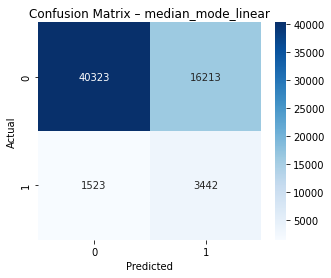

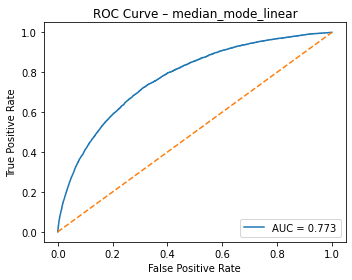

In [153]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["median_mode_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Avec la pondération des classes (class weight) que l'on utilise ici, il y a pas mal de changements au niveau des prédictions que ce soit pour la classe minoritaire ou majoritaire :

    - L'accuracy a diminuer puisque le modèle essaye de mieux cerner la classe minoritaire donc on a maintenant **0.71** contre **0.92** pour la baseline avec le même dataframe, ce qui est normal et attendu.
    - Cette baisse se retrouve fortement dans la *Précision* qui diminue à **0.17** contre **0.53** auparavant puisque le modèle prend plus de risque pour prédir la classe minoritaire (en effet il y a maintenant beaucoup plus de prédicitions pour la classe minoritaire mais cela implique beaucoup plus d'erreurs comme on peut le voir avec le nombre de FP qui a grandement augmenté passant de **169 à 16 213**, donc le dénominateur à grandement augmenté et le numérateur (TP) aussi mais à une échelle moins importante, ce qui donne ce résultat).
    - Cependant ces deux baisses sont largement compensé par la hausse importante de **Recall** de la classe minoritaire qui était le but recherché dans notre contexte métier ou tout simplement d'un point de vue performance réelle du modèle. En effet, on passe de **4 %** de bonnes prédicitions pour la classe minoritaire (1) à **69 %** ce qui bien mieux qu'auparavant.
    - Dans l'ensemble on prenant en compte toutes les variations des métriques, le modèle performe bien mieux dans l'ensemble si l'on prend en compte le contexte de déséquilibre des classes puisque le modèle performe moins bien sur la classe majoritaire mais beaucoup mieux sur la classe minoritaire en rappelant que c'est la classe minoritaire dont on veut prioriser les performances (de plus **AUC** n'a quasiment pas bougé donc cela n'a pas impacté le pouvoir de discrimination des classes, on a simplement orienté le fonctionnement du modèle). On est donc sur la bonne voie et on peut continuer à tester les autres dataframes sur cette même méthode.


In [122]:
# Fonction pour sauvegarder les résultats des baselines pour comparaison

def build_class_weight_results_row(
    dataset_name,
    model_name,
    method,
    y_true,
    y_pred,
    y_proba
):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Dataset": dataset_name,
        "Model": model_name,
        "Method": method,
        "Accuracy Test": accuracy_score(y_true, y_pred),
        "AUC Test": roc_auc_score(y_true, y_proba),
        "Precision Test": precision_score(y_true, y_pred, zero_division=0),
        "Recall Test": recall_score(y_true, y_pred, zero_division=0),
        "F1 Test": f1_score(y_true, y_pred, zero_division=0),
        "F1 Macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }

In [154]:
# Sauvegarde des résultats pour train_dfs["median_mode_linear"]

class_weight_results = []

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["median_missing_linear"].

df_name = "median_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_class_weight_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_linear")

with mlflow.start_run(run_name=f"class_imbalance_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1) 
    recall_test = recall_score(y_test, y_pred_test, pos_label=1) 
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/29 03:45:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpin54oki_\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 03:45:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_missing_linear ===
Accuracy : 0.7147526056486886
F1-score : 0.2839884086363822
Precision : 0.1780814905814906
Recall : 0.7007049345417925
AUC : 0.7754032864265222

Classification report :

              precision    recall  f1-score   support

           0      0.965     0.716     0.822     56536
           1      0.178     0.701     0.284      4965

    accuracy                          0.715     61501
   macro avg      0.571     0.708     0.553     61501
weighted avg      0.901     0.715     0.778     61501



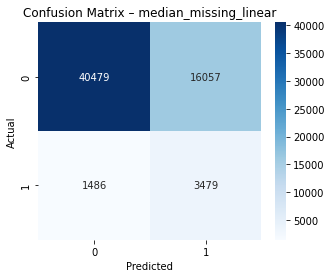

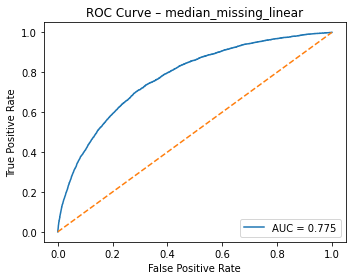

In [157]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["median_missing_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Pas de grande différence de résultats avec le dataframe précédent.

In [158]:
# Sauvegarde des résultats pour train_dfs["median_missing_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["iterative_mode_linear"].

df_name = "iterative_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_class_weight_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_linear")

with mlflow.start_run(run_name=f"class_imbalance_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1) 
    recall_test = recall_score(y_test, y_pred_test, pos_label=1) 
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/29 03:51:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmptyddms26\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/29 03:51:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for iterative_mode_linear ===
Accuracy : 0.7453049543909855
F1-score : 0.3153846153846154
Precision : 0.20139547864917667
Recall : 0.7266868076535751
AUC : 0.8076196207754551

Classification report :

              precision    recall  f1-score   support

           0      0.969     0.747     0.844     56536
           1      0.201     0.727     0.315      4965

    accuracy                          0.745     61501
   macro avg      0.585     0.737     0.579     61501
weighted avg      0.907     0.745     0.801     61501



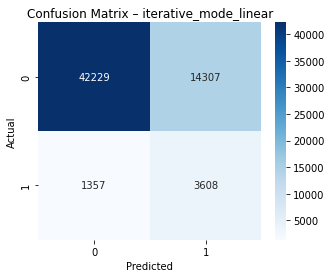

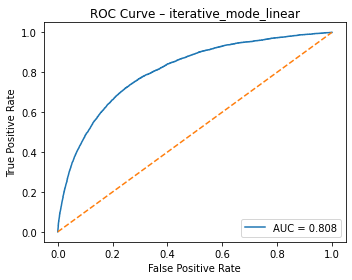

In [161]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["iterative_mode_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [162]:
# Sauvegarde des résultats pour train_dfs["iterative_mode_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

- Comme précédemment, on évaluera **nan_missing_linear** qur l'on testera avec HGB qui accepte les valeurs manquantes.
- On peut donc passer au modèle non linéaire:

In [ ]:
# Mise en place d'une fonction générique qui construit un pipeline adoptant la pondération des classes pour HGB. 

def build_class_weight_non_linear_pipeline(df, categorical_features, target_col="TARGET", min_frequency=10):

    numerical_features = [col for col in df.columns if col not in categorical_features + [target_col]]

    # Prétraitement catégoriel
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=min_frequency
    )

    # Préprocesseur global
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_features),
            ("num", "passthrough", numerical_features)
        ]
    )

    # Modèle non linéaire
    model = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=200,
        random_state=42
    )

    # Pipeline final
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    return pipeline

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["median_mode"].

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/30 03:57:44 INFO mlflow.tracking.fluent: Experiment with name 'class_imbalance_non_linear' does not exist. Creating a new experiment.
2025/12/30 03:58:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpynbz10gl\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/30 03:58:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode ===
Accuracy : 0.7378416611112014
F1-score : 0.2949844768026586
Precision : 0.18839365504915104
Recall : 0.6793554884189326
AUC : 0.7845492595615181

Classification report :

              precision    recall  f1-score   support

           0      0.963     0.743     0.839     56536
           1      0.188     0.679     0.295      4965

    accuracy                          0.738     61501
   macro avg      0.576     0.711     0.567     61501
weighted avg      0.901     0.738     0.795     61501



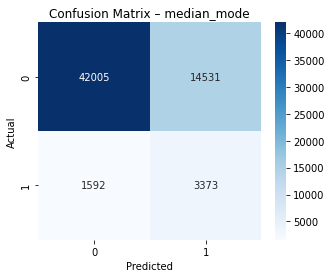

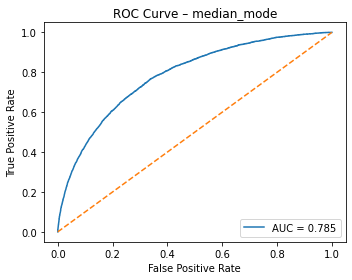

In [168]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["median_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Résultats assez similaire au dataframe **"median_mode_linear"** avec le modèle Logistic Regression

In [ ]:
# Sauvegarde des résultats pour train_dfs["median_mode"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["median_missing"].

df_name = "median_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/30 04:05:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmprvdiagnb\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/30 04:05:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_missing ===
Accuracy : 0.7381343392790362
F1-score : 0.29601783450627267
Precision : 0.1890352836087539
Recall : 0.6819738167170192
AUC : 0.7844156762542267

Classification report :

              precision    recall  f1-score   support

           0      0.964     0.743     0.839     56536
           1      0.189     0.682     0.296      4965

    accuracy                          0.738     61501
   macro avg      0.576     0.713     0.568     61501
weighted avg      0.901     0.738     0.795     61501



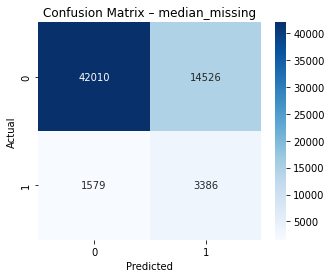

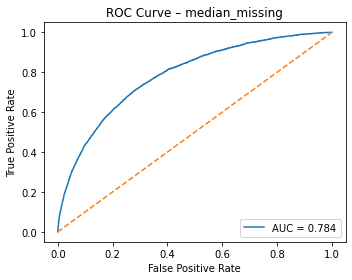

In [172]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["median_missing"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [173]:
# Sauvegarde des résultats pour train_dfs["median_missing"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["iterative_mode"].

df_name = "iterative_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/30 04:07:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp4yg8wftb\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/30 04:07:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for iterative_mode ===
Accuracy : 0.8873839449765044
F1-score : 0.547734099516782
Precision : 0.40525654652623444
Recall : 0.8447129909365559
AUC : 0.945774340006478

Classification report :

              precision    recall  f1-score   support

           0      0.985     0.891     0.936     56536
           1      0.405     0.845     0.548      4965

    accuracy                          0.887     61501
   macro avg      0.695     0.868     0.742     61501
weighted avg      0.938     0.887     0.904     61501



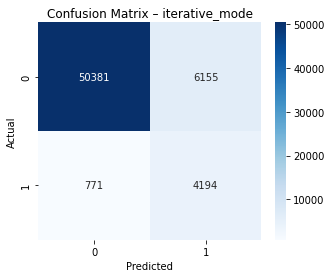

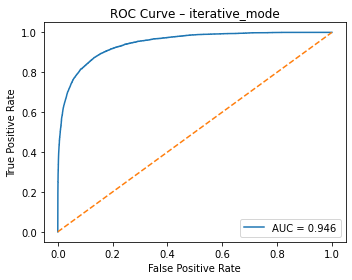

In [175]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["iterative_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Même constat que lors de la baseline, résultats beaucoup trop optimiste du fait de l'imputation sur **IterativeImputer** + **HGB**.

In [176]:
# Sauvegarde des résultats pour train_dfs["iterative_mode"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["nan_missing"].

df_name = "nan_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/30 04:11:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp8fq4d217\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/30 04:11:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for nan_missing ===
Accuracy : 0.7406221037056308
F1-score : 0.2973306316624086
Precision : 0.19028020522072503
Recall : 0.6797583081570997
AUC : 0.7848148836107742

Classification report :

              precision    recall  f1-score   support

           0      0.964     0.746     0.841     56536
           1      0.190     0.680     0.297      4965

    accuracy                          0.741     61501
   macro avg      0.577     0.713     0.569     61501
weighted avg      0.901     0.741     0.797     61501



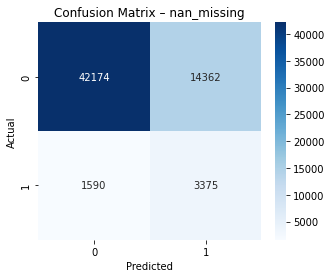

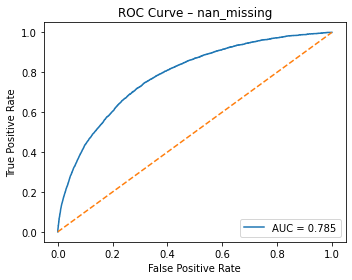

In [178]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["nan_missing"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [179]:
# Sauvegarde des résultats pour train_dfs["nan_missing"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du nouveau pipeline class weight sur train_dfs["nan_missing_linear"].

df_name = "nan_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "rerun_notebook")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/30 04:13:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpn45tifr6\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/30 04:13:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for nan_missing_linear ===
Accuracy : 0.7369311068112714
F1-score : 0.2942639040348964
Precision : 0.18780623608017818
Recall : 0.6793554884189326
AUC : 0.7833957270726699

Classification report :

              precision    recall  f1-score   support

           0      0.963     0.742     0.838     56536
           1      0.188     0.679     0.294      4965

    accuracy                          0.737     61501
   macro avg      0.576     0.711     0.566     61501
weighted avg      0.901     0.737     0.794     61501



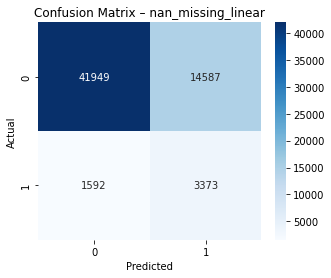

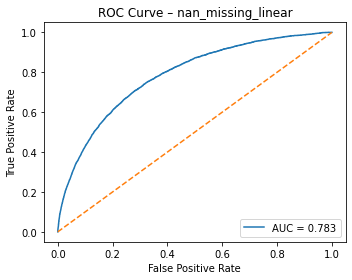

In [181]:
# Affichage des résultats du nouveau pipeline class_weight train_dfs["nan_missing_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [182]:
# Sauvegarde des résultats pour train_dfs["nan_missing_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "Class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [184]:
class_weight_results_df = pd.DataFrame(class_weight_results)
class_weight_results_df

,Dataset,Model,Method,Accuracy Test,AUC Test,Precision Test,Recall Test,F1 Test,F1 Macro,TN,FP,FN,TP
0,median_mode_linear,LogisticRegression (OHE),Class_weight,0.711614,0.773368,0.175121,0.693253,0.279610,0.549667,40323,16213,1523,3442
1,median_missing_linear,LogisticRegression (OHE),Class_weight,0.714753,0.775403,0.178081,0.700705,0.283988,0.552944,40479,16057,1486,3479
2,iterative_mode_linear,LogisticRegression (OHE),Class_weight,0.745305,0.807620,0.201395,0.726687,0.315385,0.579468,42229,14307,1357,3608
3,median_mode,HistGradientBoostingClassifier (OHE),Class_weight,0.737842,0.784549,0.188394,0.679355,0.294984,0.566984,42005,14531,1592,3373
4,median_missing,HistGradientBoostingClassifier (OHE),Class_weight,0.738134,0.784416,0.189035,0.681974,0.296018,0.567584,42010,14526,1579,3386
5,iterative_mode,HistGradientBoostingClassifier (OHE),Class_weight,0.887384,0.945774,0.405257,0.844713,0.547734,0.741709,50381,6155,771,4194
6,nan_missing,HistGradientBoostingClassifier (OHE),Class_weight,0.740622,0.784815,0.190280,0.679758,0.297331,0.569144,42174,14362,1590,3375
7,nan_missing_linear,HistGradientBoostingClassifier (OHE),Class_weight,0.736931,0.783396,0.187806,0.679355,0.294264,0.566299,41949,14587,1592,3373


- Globalement les résultats sont assez similaires entre les deux modèles et différents dataframes, cette méthode nous donne les résultats attendus sur le **Recall** et dans l'ensemble les *performances* des modèles sont bien meilleurs (même si les prédicitions sur la classe majoritaire sont moins performantes, cela reste acceptable en comparaison ave le gain de performance sur la classe minoritaire).
- Nous pouvons donc passer au test d'une deuxième méthode de gestion du déséquilibre des classes afin d'expérimenter une approche supplémentaire et comparer avec la méthode "class weight".

#### - RandomUnderSampler

- Donc ici on optera pour une méthode un peu différente qui intéragi directement sur les données. En effet, **RandomUnderSampler** est une méthode de *sous-échantillonnage* aléatoire de la classe majoritaire qui va tout simplement *réduire* le nombre d’exemples de la *classe majoritaire* pour obtenir un *ratio plus équilibré*.
- Cela permet ici de rendre la *classe minoritaire plus visible* pour le modèle puisque leurs effectifs sont plus proches.
- L'avantage de cette méthode est sa *simplicité* d'utilisation et son *contrôle précis* sur le ratio que l'on veut entre minoritaire et majoritaire (avec le paramétre sampling_strategy). De plus, cela permet d'avoir une approche différente de *class_weight* qui modifie les pénalités de l'algorithme alors qu'ici c'est une modification des données.
- Cette modification des données peut être un inconvénient puisque certaines informations de la classe majoritaire sont perdues (car on supprime des échantillons) et peut légèrement réduire l’AUC globale.
- Il existe d'autres méthodes utilisant par exemple le *sur-échantillonnage* comme notamment OverSampling qui génére des données en dupliquant aléatoirement des échantillons de la classe minoritaire (fonctionne mieux sur de petits datasets) ou encore SMOTE qui génére aussi des données mais artificiellement (cela fait penser à de la data augmentation) en créant des échantillons similaires (en se basant sur les k plus proches voisins). Ces méthodes pourraient être intéressantes à tester toutefois ici on restera sur la comparaison *Class weight/RandomUnderSampler*, ce qui représente déjà une première comparaison satisfaisante dans la résolution du déséquilibre.

In [187]:
# Mise en place d'une fonction générique qui construit un pipeline adoptant RandomUnderSampler pour Logistic Regression. 

def build_random_undersampling_linear_pipeline(df, categorical_features, target_col="TARGET", min_frequency=10,
                                               sampling_strategy=0.3, random_state=42):
    
    numerical_features = [col for col in df.columns if col not in categorical_features + [target_col]]

    # Prétraitement numérique
    numeric_transformer = Pipeline([
        ("scaler", StandardScaler())
    ])

    # Prétraitement catégoriel
    categorical_transformer = Pipeline([("onehot", OneHotEncoder(
            handle_unknown="ignore",
            min_frequency=min_frequency
        ))
    ])

    # Préprocesseur global
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # Modèle linéaire 
    model = LogisticRegression(
        max_iter=1000,
        random_state=random_state
    )

    # Pipeline imblearn (car prend en charge l'échantillonage)
    pipeline = ImbPipeline(steps=[
        ("preprocessing", preprocessor),
        ("undersampling", RandomUnderSampler(
            sampling_strategy=sampling_strategy,
            random_state=random_state
        )),
        ("classifier", model)
    ])

    return pipeline

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["median_mode_linear"]

df_name = "median_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.3
)

mlflow.set_experiment("class_imbalance_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.3)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 02:19:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp4l2q2pxd\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 02:19:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode_linear ===
Accuracy : 0.8939854636509975
F1-score : 0.2981700753498385
Precision : 0.3202312138728324
Recall : 0.27895266868076535
AUC : 0.7727135619351022

Classification report :

              precision    recall  f1-score   support

           0      0.937     0.948     0.943     56536
           1      0.320     0.279     0.298      4965

    accuracy                          0.894     61501
   macro avg      0.629     0.613     0.620     61501
weighted avg      0.888     0.894     0.891     61501



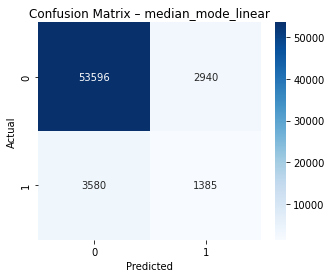

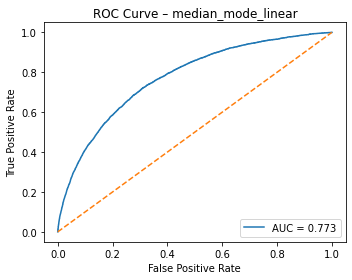

In [189]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["median_mode_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Les résultats ne sont pas aussi bons que class weight mais testons avec une augmentation de sampling_strategy à 0.5 pour equilibrer parfaitement les deux classes pour voir ce que cela donne.

In [190]:
# Sauvegarde des résultats pour train_dfs["median_mode_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        method= "RandomUnderSampler_30",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["median_mode_linear"] (sampling_strategy=0.5)

df_name = "median_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 02:31:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpb6f28fgd\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 02:31:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode_linear ===
Accuracy : 0.8427667842799305
F1-score : 0.3181497673106755
Precision : 0.2447651079526961
Recall : 0.454380664652568
AUC : 0.7718877871718699

Classification report :

              precision    recall  f1-score   support

           0      0.948     0.877     0.911     56536
           1      0.245     0.454     0.318      4965

    accuracy                          0.843     61501
   macro avg      0.596     0.666     0.615     61501
weighted avg      0.891     0.843     0.863     61501



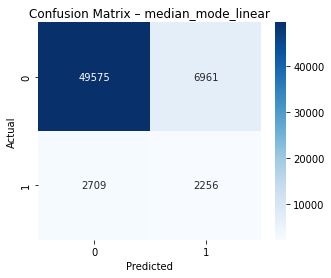

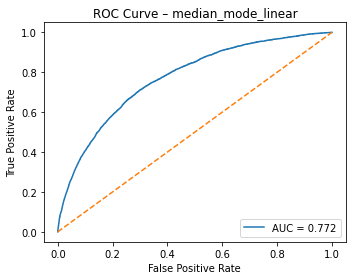

In [192]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["median_mode_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Avec le paramétre sampling_strategy à 0.5 au lieu de 0.3, les résultats sont un peu en légére hausse pour le Recall et le F1 score.
- Pour finir avec les autre dataframes, on continuera avec 0.5 pour sampling_strategy

In [193]:
# Sauvegarde des résultats pour train_dfs["median_mode_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["median_missing_linear"] (sampling_strategy=0.5)

df_name = "median_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 02:46:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpb_smtabv\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 02:46:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_missing_linear ===
Accuracy : 0.8431732817352563
F1-score : 0.3200563976031019
Precision : 0.24620390455531455
Recall : 0.45720040281973817
AUC : 0.7738790965084444

Classification report :

              precision    recall  f1-score   support

           0      0.948     0.877     0.911     56536
           1      0.246     0.457     0.320      4965

    accuracy                          0.843     61501
   macro avg      0.597     0.667     0.616     61501
weighted avg      0.892     0.843     0.864     61501



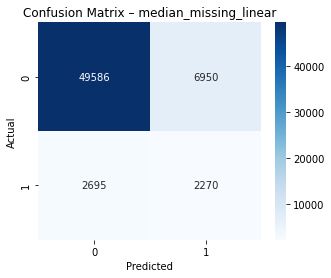

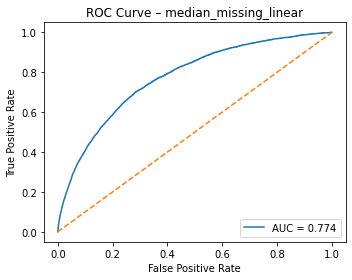

In [195]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["median_missing_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [196]:
# Sauvegarde des résultats pour train_dfs["median_missing_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["iterative_mode_linear"] (sampling_strategy=0.5)

df_name = "iterative_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 02:47:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpku79fj2b\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 02:47:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for iterative_mode_linear ===
Accuracy : 0.8516446887042487
F1-score : 0.36533110740122426
Precision : 0.27903517160769314
Recall : 0.5289023162134945
AUC : 0.8061190894632313

Classification report :

              precision    recall  f1-score   support

           0      0.955     0.880     0.916     56536
           1      0.279     0.529     0.365      4965

    accuracy                          0.852     61501
   macro avg      0.617     0.704     0.641     61501
weighted avg      0.901     0.852     0.872     61501



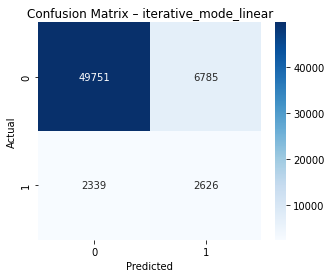

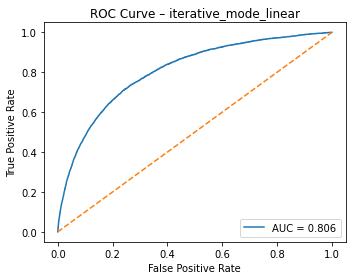

In [198]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["iterative_mode_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [199]:
# Sauvegarde des résultats pour train_dfs["iterative_mode_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

- On passe ensuite au modèles non linéaire avec **HGB + RandomUnderSampler**

In [ ]:
# Mise en place d'une fonction générique qui construit un pipeline adoptant RandomUnderSampler pour HGB. 

def build_random_undersampling_non_linear_pipeline(df, categorical_features, target_col="TARGET", min_frequency=10,
                                                   sampling_strategy=0.5, random_state=42):
    
    numerical_features = [col for col in df.columns if col not in categorical_features + [target_col]]

    # Prétraitement catégoriel
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=min_frequency
    )

    # Préprocesseur global
    preprocessor = ColumnTransformer(transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", "passthrough", numerical_features)
    ])

    # Modèle non linéaire
    model = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=200,
        random_state=42
    )

    # Pipeline imblearn (car prend en charge l'échantillonage)
    pipeline = ImbPipeline(steps=[
        ("preprocessing", preprocessor),
        ("undersampling", RandomUnderSampler(
            sampling_strategy=sampling_strategy,
            random_state=random_state
        )),
        ("classifier", model)
    ])

    return pipeline

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["median_mode"]

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_non_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_hgb_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 03:09:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpmtftsgm6\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 03:09:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode ===
Accuracy : 0.846539080665355
F1-score : 0.33187031006654394
Precision : 0.25586726339919225
Recall : 0.47210473313192347
AUC : 0.7821902532386391

Classification report :

              precision    recall  f1-score   support

           0      0.950     0.879     0.913     56536
           1      0.256     0.472     0.332      4965

    accuracy                          0.847     61501
   macro avg      0.603     0.676     0.623     61501
weighted avg      0.894     0.847     0.866     61501



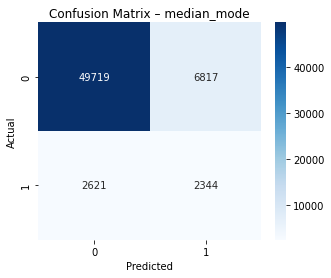

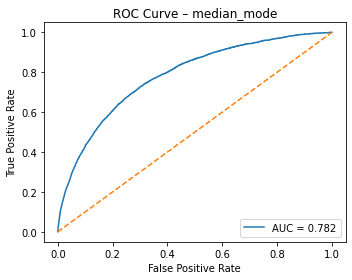

In [204]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["median_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- En comparaison avec **"median_mode_linear"**, c'est mieux pour le recall de la classe minoritaire mais moins bien pour les prédictions de la classe 0 donc de l'accuracy et de la précision globalement.

In [205]:
# Sauvegarde des résultats pour train_dfs["median_mode"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["median_missing"]

df_name = "median_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_non_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_hgb_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 03:21:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp1c2uitsm\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 03:21:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_missing ===
Accuracy : 0.8471732166956635
F1-score : 0.3333569756720335
Precision : 0.2572804904751478
Recall : 0.473313192346425
AUC : 0.7829814218134554

Classification report :

              precision    recall  f1-score   support

           0      0.950     0.880     0.914     56536
           1      0.257     0.473     0.333      4965

    accuracy                          0.847     61501
   macro avg      0.604     0.677     0.624     61501
weighted avg      0.894     0.847     0.867     61501



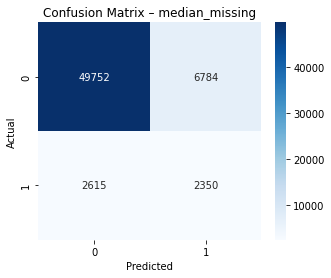

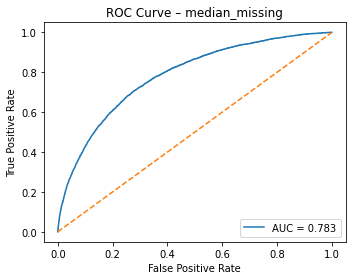

In [207]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["median_missing"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [208]:
# Sauvegarde des résultats pour train_dfs["median_missing"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["iterative_mode"]

df_name = "iterative_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_non_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_hgb_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 03:22:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp7xjjp9t0\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 03:22:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for iterative_mode ===
Accuracy : 0.9323750833319784
F1-score : 0.6384421455272538
Precision : 0.5616396451514225
Recall : 0.7395770392749245
AUC : 0.9434489530577065

Classification report :

              precision    recall  f1-score   support

           0      0.976     0.949     0.963     56536
           1      0.562     0.740     0.638      4965

    accuracy                          0.932     61501
   macro avg      0.769     0.844     0.801     61501
weighted avg      0.943     0.932     0.937     61501



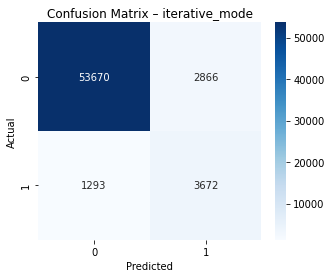

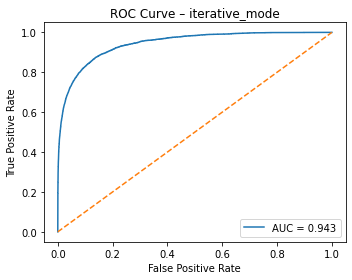

In [210]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["iterative_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Comme pour tous les tests avec **"iterative_mode"**, on ne le prendra pas en compte puisque ces résultats ne sont pas suffisamment objectif (biais introduit avant le split).

In [211]:
# Sauvegarde des résultats pour train_dfs["iterative_mode"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["nan_missing"]

df_name = "nan_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_non_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_hgb_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 03:25:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpixvs4qf5\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 03:25:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for nan_missing ===
Accuracy : 0.8467667192403375
F1-score : 0.3292526690391459
Precision : 0.2545954870665933
Recall : 0.46586102719033234
AUC : 0.7821481230364354

Classification report :

              precision    recall  f1-score   support

           0      0.949     0.880     0.914     56536
           1      0.255     0.466     0.329      4965

    accuracy                          0.847     61501
   macro avg      0.602     0.673     0.621     61501
weighted avg      0.893     0.847     0.866     61501



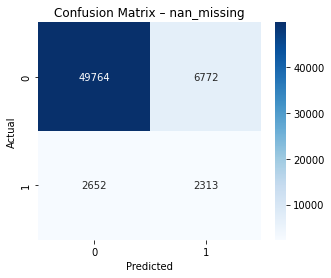

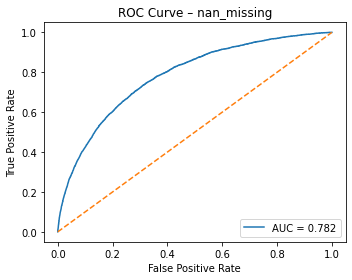

In [213]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["nan_missing"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [214]:
# Sauvegarde des résultats pour train_dfs["nan_missing"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [ ]:
# Utilisation du pipeline RandomUnderSampler sur train_dfs["nan_missing_linear"]

df_name = "nan_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_random_undersampling_non_linear_pipeline(df,
    categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"],
    sampling_strategy=0.5
)

mlflow.set_experiment("class_imbalance_non_linear")

with mlflow.start_run(run_name=f"rand_under_sampler_hgb_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "class_imbalance")

    mlflow.log_param("resampling_method", "RandomUnderSampler")
    mlflow.log_param("sampling_strategy", 0.5)

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    conf_matrix = confusion_matrix(y_test, y_pred_test)

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_macro_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

2025/12/31 03:26:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpax3urvvg\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/12/31 03:26:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for nan_missing_linear ===
Accuracy : 0.846978097917107
F1-score : 0.32965310919581164
Precision : 0.25501432664756446
Recall : 0.4660624370594159
AUC : 0.7822215854835555

Classification report :

              precision    recall  f1-score   support

           0      0.949     0.880     0.914     56536
           1      0.255     0.466     0.330      4965

    accuracy                          0.847     61501
   macro avg      0.602     0.673     0.622     61501
weighted avg      0.893     0.847     0.866     61501



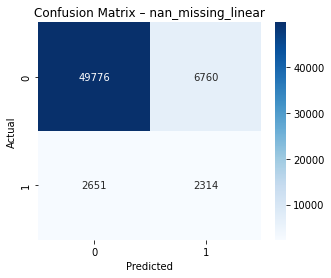

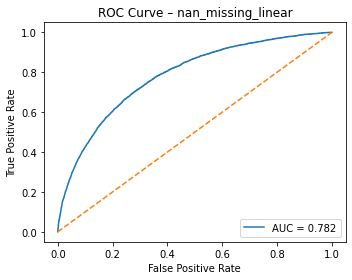

In [216]:
# Affichage des résultats du nouveau pipeline RandomUnderSampler train_dfs["nan_missing_linear"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [217]:
# Sauvegarde des résultats pour train_dfs["nan_missing_linear"]

class_weight_results.append(
    build_class_weight_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier (OHE)",
        method= "RandomUnderSampler_50",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test
    )
)

In [219]:
class_weight_results_df = pd.DataFrame(class_weight_results)
class_weight_results_df

,Dataset,Model,Method,Accuracy Test,AUC Test,Precision Test,Recall Test,F1 Test,F1 Macro,TN,FP,FN,TP
0,median_mode_linear,LogisticRegression (OHE),Class_weight,0.711614,0.773368,0.175121,0.693253,0.279610,0.549667,40323,16213,1523,3442
1,median_missing_linear,LogisticRegression (OHE),Class_weight,0.714753,0.775403,0.178081,0.700705,0.283988,0.552944,40479,16057,1486,3479
2,iterative_mode_linear,LogisticRegression (OHE),Class_weight,0.745305,0.807620,0.201395,0.726687,0.315385,0.579468,42229,14307,1357,3608
3,median_mode,HistGradientBoostingClassifier (OHE),Class_weight,0.737842,0.784549,0.188394,0.679355,0.294984,0.566984,42005,14531,1592,3373
4,median_missing,HistGradientBoostingClassifier (OHE),Class_weight,0.738134,0.784416,0.189035,0.681974,0.296018,0.567584,42010,14526,1579,3386
5,iterative_mode,HistGradientBoostingClassifier (OHE),Class_weight,0.887384,0.945774,0.405257,0.844713,0.547734,0.741709,50381,6155,771,4194
6,nan_missing,HistGradientBoostingClassifier (OHE),Class_weight,0.740622,0.784815,0.190280,0.679758,0.297331,0.569144,42174,14362,1590,3375
7,nan_missing_linear,HistGradientBoostingClassifier (OHE),Class_weight,0.736931,0.783396,0.187806,0.679355,0.294264,0.566299,41949,14587,1592,3373
8,median_mode_linear,LogisticRegression (OHE),RandomUnderSampler_30,0.893985,0.772714,0.320231,0.278953,0.298170,0.620416,53596,2940,3580,1385
9,median_mode_linear,LogisticRegression (OHE),RandomUnderSampler_50,0.842767,0.771888,0.244765,0.454381,0.318150,0.614644,49575,6961,2709,2256


- Donc on retrouve ici les résultats finaux de la résolution du déséquilibre des classes et globalement la première méthode **class weight** donne de meilleurs résultats que la deuxième méthode **RandomUnderSampler** surtout au niveau de la métrique qui nous intéresse le plus c'est à dire le Recall.
- Pour l'AUC, les résultats sont assez similaire partout et sont restés stable avec les deux méthodes.
- Dans l'ensemble les deux méthodes de gestion du déséquilibre testées (pondération des classes et sous-échantillonnage aléatoire) modifient le compromis précision / rappel, sans impact significatif sur l’AUC. Le choix de la méthode doit donc être guidé par les contraintes métier plutôt que par une métrique globale unique.
- En effet pour **class weight**, on constate que les modèles sont beaucoup *plus performant* en faveur du *Recall* quitte à faire beaucoup plus d'erreurs sur la classe majoritaire donc dans notre cas c'est ce qu'on veut puisque l'on considére le *coût d'un FN est au moins 10 fois plus important qu'un FP*.
- Alors que pour **RandomUnderSampler**, on constate que le modèle est plus équilibré dans ces prédictions puisque le Recall est autour de 0.50 et la précision est peu plus haute que pour la première méthode (cela est dû au fait que le modèle voit un jeu d'entrainement "artificiellement" plus équilibré puisque l'on a utilisé sampling_strategy = 0.50 donc 50/50 de représentation par classe).
- Pour finir, le choix de la méthode sera guidé par les contraintes métier plutôt que par des métriques globales équilibré donc on gardera **class weight**. (*A noter que même si l'imputation iterative mode montre de bonnes performances, cette méthode d’imputation introduit un risque de fuite d’information en l'état et n’est donc pas retenue pour la suite comme on l'a évoqué précédemment après la mise en place de la baseline*)

Après le déséquilibre des classes, il reste un autre point très important à définir qui est la création d'un score métier et l'optimisation du seuil de décision permettant de minimiser ce coût métier.

### Optimisation coût métier et seuil de décision

- Après l’évaluation des modèles baselines et la prise en compte du déséquilibre de classes avec **class weight**, cela a permis d'augmenter les performances des modèles. Cependant le plus important ici ne sont pas les performances seules mais aussi *l'impact métier* sur les modéles puisque notre objectif est de trouver une *solution à la problématique* induite par le *contexte* de ce projet.

- En effet dans le contexte métier lié aux crédits, les erreurs de classification n’ont pas le même
coût:      

    - *Accorder un crédit* à un **mauvais client** (faux négatif) entraîne une **perte financière** potentiellement *importante*, tandis que *refuser un crédit* à un **bon client** (faux positif) correspond essentiellement à un **manque à gagner** (intérêts par exemple).

    - Ainsi, l’objectif de cette section est de définir un coût métier asymétrique, de l’intégrer dans l’évaluation des modèles, et d’optimiser le seuil de décision utilisé pour minimiser au mieux ce coût. Contrairement au seuil par défaut de **0.5**, cette approche permet d'orienter les décisions du modèle en prenant en compte les priorités économiques de l'entreprise.


#### - Définition du coût métier

- Comme on l'a dit ci-dessus, il faut définir un coût métier asymétrique afin d’évaluer les modèles de manière plus pertinente que via des métriques globales comme l’accuracy.

- Dans le contexte métier, une erreur de type FN est considérée comme nettement plus coûteuse qu’une erreur de type FP. On utilisera les recommandations fournies qui suppose que le **coût d’un faux négatif est 10 fois supérieur à celui d’un faux positif**.

- Donc les coûts sont : 

    -  Faux positif (FP) = 1
    -  Faux négatif (FN) = 10

- Ce qui nous donne un score métier correspondant au coût total des erreurs de prédiction :

    - **Coût métier = 1 X FP + 10 X FN**

- Ce score sera utilisé pour analyser le l'impact du seuil de décision des différents modèles afin de sélectionner le seuil optimisant le compromis économique.


#### - Seuil de décision et lien avec le coût métier

- Les modèles de classification produisent généralement des probabilités d’appartenance à une classe, et non des décisions finales. Le changement de ces probabilités en classes (positif / négatif) repose sur un seuil de décision. Le seuil couramment utilisé de **0,5** est un choix par défaut, qui n’est pas nécessairement optimal du point de vue métier.

- Dans les faits, le choix du seuil *influence* directement **l’équilibre** entre *faux positifs* (FP) et *faux* négatifs* (FN) : 
    - *Abaisser* le seuil permet de réduire les FN au prix d’une augmentation des FP
    - *Augmenter* le seuil permet de réduire les FP au prix d’une augmentation des FN. 
    - Le seuil de décision joue donc un *rôle central* dans l’arbitrage entre ces deux types d’erreurs et conditionne directement le coût métier global. Son *ajustement* sera donc guidé par les enjeux économiques et non uniquement par des métriques statistiques.

- Donc pour la suite, nous explorerons plusieurs valeurs de seuil de décision afin d’analyser leur impact sur les faux positifs et les faux négatifs. Pour chaque seuil, nous calculerons le coût métier associé, en tenant compte des pondérations spécifiques aux erreurs. Nous retiendrons ensuite le *seuil minimisant* ce coût global, et utiliserons ce critère pour comparer les différents modèles.

- On utilisera le set train pour l'entrainement, le set de validation pour déterminer le seuil optimal et enfin le set de test pour mesurer les performances du modèle (pour éviter la fuite d'information).

#### - Optimisation du coût métier en fonction du seuil de décision

In [ ]:
# Utilisation du pipeline LR class weight sur train_dfs["median_mode_linear"] pour optimiser le seuil de décision.

df_name = "median_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_class_weight_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("business_cost_optimization_linear")

with mlflow.start_run(run_name=f"class_imbalance_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("objective", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_lr = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1) 
    recall_val = recall_score(y_val, y_pred_val, pos_label=1) 
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_lr)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/17 15:10:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpwoxx9uzk\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 15:10:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = fae00681f9024ef5b157a0145140660a


- On récupére ici les valeurs dont on a besoin donc y_pred_test et y_proba_test pour calculer et évaluer le coût métier par seuil de décision.

In [33]:
# Mise en place d'une fonction pour calculer le coût métier à partir des prédictions.

def business_cost(y_true, y_pred, cost_fp=1, cost_fn=10):

    """
    Calcule le coût métier à partir des prédictions binaires.
    """

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return cost_fp * fp + cost_fn * fn

- Puis pour faciliter la comparasion aux différents seuil de décision possible, on crée une fonction qui évalue le coût aux seuils choisis et enregistre les résutats dans un dataframe.

In [34]:
# Mise en place d'une fonction pour évaluer le coût métier à différents seuil de décision.

def evaluate_business_cost_by_threshold(y_true, y_proba, thresholds=np.arange(0.01, 1.0, 0.01),
                                        cost_fp=1, cost_fn=10):

    """
    Calcule le coût métier à différents niveaux de seuil de décision et retourne un dataframe des résultats.
    """

    results = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)

        cost = business_cost(
            y_true=y_true,
            y_pred=y_pred,
            cost_fp=cost_fp,
            cost_fn=cost_fn
        )

        results.append({
            "threshold": threshold,
            "business_cost": cost
        })

    return pd.DataFrame(results)

In [667]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28258
1,0.02,28249
2,0.03,28187
3,0.04,28071
4,0.05,27921
...,...,...
94,0.95,24471
95,0.96,24664
96,0.97,24727
97,0.98,24813


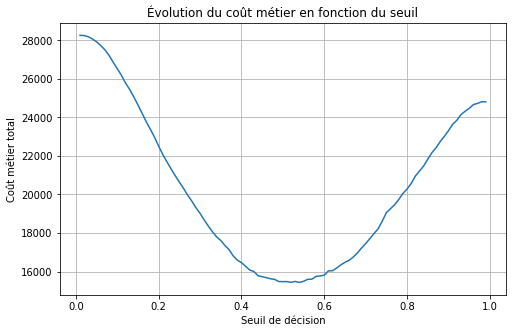

In [668]:
# Visualisation des résultats obtenus

plt.figure(figsize=(8, 5))
plt.plot(cost_df["threshold"], cost_df["business_cost"])
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier total")
plt.title("Évolution du coût métier en fonction du seuil")
plt.grid(True)
plt.show()

In [669]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_linear = optimal_row["threshold"]
optimal_cost_lr = optimal_row["business_cost"]

optimal_threshold_linear, optimal_cost_lr

(0.54, 15436.0)

In [670]:
cost_05 = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= 0.5).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_opt = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= optimal_threshold_linear).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_05, cost_opt

(15478, 15436)

- Donc pour le modèle LR du pipeline qui prend en compte le déséquilibre avec **class weight**, on obtient un résultat pas si différent du seuil par défault puisqu'il est de 0.54 au lieu de 0.5 par défault.
- On peut aussi voir ce que ça donne au niveau de la matrice de confusion:

In [671]:
# Comparaison des matrices de confusion par défaut et optimisé métier.

y_pred_optimal = (y_proba_val >= optimal_threshold_linear).astype(int)

print("=== Seuil 0.5 ===")
print(classification_report(y_val, (y_proba_val >= 0.5).astype(int)))

print("\n=== Seuil optimal ===")
print(classification_report(y_val, y_pred_optimal))

=== Seuil 0.5 ===
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     28268
           1       0.18      0.71      0.28      2482

    accuracy                           0.71     30750
   macro avg       0.57      0.71      0.55     30750
weighted avg       0.90      0.71      0.78     30750


=== Seuil optimal ===
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     28268
           1       0.19      0.65      0.30      2482

    accuracy                           0.75     30750
   macro avg       0.58      0.71      0.57     30750
weighted avg       0.90      0.75      0.80     30750



- Finalement, en partant du fait qu'un FN est 10 fois plus coûteux qu'un FP, on arrive au résultat ci-dessus.
- Le *seuil optimal obtenu* (**0.54**) est proche du seuil standard de *0.5* et on peut voir que cela implique même une *très légère baisse du Recall* de la classe minoritaire en faveur de la classe majoritaire.
- Donc finalement dans cette configuration de type baseline linéaire, on obtient des résultats assez proches de ceux obtenus après la *pondération* qui a apporté les plus gros gains de performance à notre baseline initiale. Cette optimisation seuil de décision a seulement *affiner* ici les performances du modèle LR.

- On peut ensuite faire de même pour **HGB** afin de comparer à la baseline linéaire sur le jeu de donnée train_dfs["median_mode"]:

In [ ]:
# Utilisation du pipeline HGB class weight sur train_dfs["median_mode"] pour optimiser le seuil de décision.

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("business_cost_optimization_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("objective", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)
    train_time_hgb = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_hgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/17 16:30:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpmlufrtjb\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 16:30:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = 6191095466f3472d80c9c500a4680cc3


In [700]:
# Calcul du coût métier à différent seuil de décision.

cost_hgb_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_hgb_df

,threshold,business_cost
0,0.01,28268
1,0.02,28268
2,0.03,28258
3,0.04,28216
4,0.05,28128
...,...,...
94,0.95,24820
95,0.96,24820
96,0.97,24820
97,0.98,24820


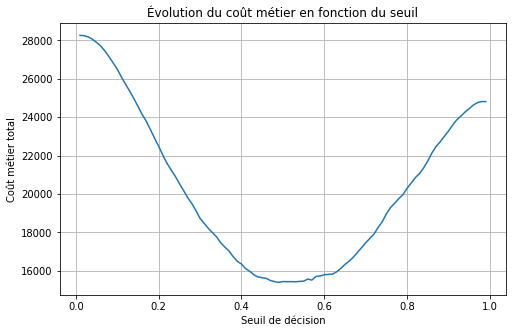

In [701]:
# Visualisation des résultats obtenus

plt.figure(figsize=(8, 5))
plt.plot(cost_df["threshold"], cost_df["business_cost"])
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier total")
plt.title("Évolution du coût métier en fonction du seuil")
plt.grid(True)
plt.show()

In [702]:
optimal_row = cost_hgb_df.loc[cost_hgb_df["business_cost"].idxmin()]
optimal_threshold_hgb = optimal_row["threshold"]
optimal_cost_hgb = optimal_row["business_cost"]

optimal_threshold_hgb, optimal_cost_hgb

(0.51, 15032.0)

In [703]:
cost_05 = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= 0.5).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_opt = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= optimal_threshold_hgb).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_05, cost_opt

(15087, 15032)

In [704]:
# Comparaison des matrices de confusion par défaut et optimisé métier.

y_pred_optimal = (y_proba_val >= optimal_threshold_hgb).astype(int)

print("=== Seuil 0.5 ===")
print(classification_report(y_val, (y_proba_val >= 0.5).astype(int)))

print("\n=== Seuil optimal ===")
print(classification_report(y_val, y_pred_optimal))

=== Seuil 0.5 ===
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     28268
           1       0.19      0.69      0.30      2482

    accuracy                           0.74     30750
   macro avg       0.58      0.71      0.57     30750
weighted avg       0.90      0.74      0.79     30750


=== Seuil optimal ===
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     28268
           1       0.19      0.68      0.30      2482

    accuracy                           0.74     30750
   macro avg       0.58      0.71      0.57     30750
weighted avg       0.90      0.74      0.80     30750



- Pour **HGB**, on trouve 0.51 comme seuil de décision en optimisant ce dernier.
- Les résultats obtenus pour les deux baselines sont assez similaires au niveau des différentes métriques avec quelques différences mineures (par exemple pour la classe 1 on a 0.68 de **Recall** pour *HGB* contre 0.65 pour *LR* ou encore une différence de 0.01 pour la classe 0 en faveur de *LR*). 
- Les deux modèles ont un seuil de décision optimal différent (**0.54** pour LR et **0.51** pour HGB) pour un coût fixe des FP = 1 et un coût fixe des FN = 10. D'ailleurs, on a aussi un coût métier global pour chaque modèle différent en effet, **HGB** est ***meilleur*** en coût métier puisque il atteint **15 032** contre **15 436** pour ****LR**. 
- Donc dans le cadre de l'optimisation métier, on voit l'intérêt d'optimiser le seuil de décision puisque cela permet d’atteindre un coût métier minimal *inférieur* à celui du modèle linéaire, ce qui justifie son choix dans un contexte opérationnel.

- Pour conclure, dans cette étape nous avons formalisé le cadre métier du problème de classification en définissant explicitement une fonction de coût en prenant en compte l’asymétrie entre les erreurs de type faux positifs et faux négatifs. 

- Cette formalisation permet de dépasser les métriques de performance classiques (Accuracy, F1-score, AUC), qui ne reflètent pas directement l’impact opérationnel des décisions prises par le modèle.

- En s’appuyant sur les probabilités de sortie des modèles, une analyse du coût métier en fonction du seuil de décision a été menée. Cette approche a permis d’identifier, pour chaque modèle, le seuil de classification minimisant le coût métier total, et donc le compromis optimal entre détection de la classe minoritaire et limitation des erreurs coûteuses.

- On a maintenant le cadre de décision désormais figé avec une fonction de coût métier clairement définie et un protocole d’évaluation établi.

- Pour la suite du projet, on va tester quelques nouveaux modèles pour sortir des baselines et étoffer notre base de comparaison avec des modèles plus complexe.

- Ces derniers seront évalués et comparés sur la base de ce coût métier minimal obtenu après optimisation du seuil, permettant de respecter les enjeux économiques de l'entreprise. Cependant en paralléle, on gardera les métriques techniques telles que l'AUC ou l'accuracy afin d'avoir d'autres éléments de mesures et de comparaison.

### Comparaison de modèles avancés selon le coût métier

- Cette section vise à élargir l’éventail des modèles évalués, sans modifier le protocole d’évaluation.

- Pour ce qui est des modèles linéaires la **régression logistique** est conservée comme *référence linéaire* du projet. En effet, dans un contexte de classification binaire probabiliste avec optimisation du seuil et du coût métier, elle constitue le principal modèle linéaire adapté, offrant à la fois stabilité, interprétabilité et accès direct aux probabilités de prédiction. Les alternatives linéaires existantes ne fournissent généralement pas de probabilités exploitables (par exemple LinearSVM n'a pas de predict_proba donc incompatible avec seuil & coût) ou n’apportent pas de gain méthodologique significatif.

- L’analyse se concentre donc principalement sur des modèles non linéaires, plus à même de capturer des interactions complexes entre variables et d’améliorer la séparation entre les classes. Ces modèles sont évalués dans les mêmes conditions que les baselines, avec une pondération des classes et une optimisation du seuil de décision visant à minimiser le coût métier.

- L’objectif n’est pas d’optimiser finement chaque modèle, mais de comparer leur capacité intrinsèque à réduire le coût opérationnel, en utilisant une méthodologie similaire (les étapes de cross-validation et d’optimisation fine sont réservées aux modèles finaux).

- Dans cette nouvelle séléction de modèles on choisira donc 2 modèles non linéaires, **LightGBM** qui est un modèle de référence dans la compétition et **XGBoost** qui un bon modèle de comparaison car il a une architecture différente de LGBM (niveau des split, régularisation) et offre aussi de bonnes performances.
- Cependant avant ces deux nouveaux modéles, on ajoutera un **Dummy Classifier** qui représente le point de comparaison minimal de tous les modèles car même si on a construit des baselines solides, le Dummy sert de point de *référence naïf*, indépendant des features, afin de quantifier le gain réel apporté par l’apprentissage dans un contexte fortement déséquilibré (puisque DC ne se base que sur la distribution et non sur les variables explicatives)

#### - DummyClassifier

In [267]:
# Mise en place d'un pipeline DummyClassifier pour avoir une référence naïve de classification.

def build_dummy_pipeline(random_state=42):

    # Pipeline
    pipeline = Pipeline(steps=[
            ("classifier", DummyClassifier(strategy="prior", random_state=random_state))
        ]
    )

    return pipeline

In [ ]:
# Utilisation du nouveau pipeline DummyClassifier sur train_dfs["median_mode"].

df_name = "median_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

# Pipeline Dummy
pipeline = build_dummy_pipeline()

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_dummy_prior_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("model", "DummyClassifier")
    mlflow.set_tag("strategy", "prior")
    mlflow.set_tag("execution_type", "minimal_baseline_reference")
    mlflow.set_tag("threshold_optimized", "no")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Prédictions
    start_pred = time.time()
    y_pred_test = pipeline.predict(X_test)
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    predict_time = time.time() - start_pred

    # Métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    f1_macro = f1_score(y_test, y_pred_test, average="macro")

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("train_time_sec", train_time)
    mlflow.log_metric("predict_time_sec", predict_time)


    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

c:\Users\Caomghin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

2026/01/17 14:33:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpu20hrfog\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 14:33:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== Baseline results for median_mode_linear ===
Accuracy : 0.9192696053722703
F1-score : 0.0
Precision : 0.0
Recall : 0.0
AUC : 0.5

Classification report :

              precision    recall  f1-score   support

           0      0.919     1.000     0.958     56536
           1      0.000     0.000     0.000      4965

    accuracy                          0.919     61501
   macro avg      0.460     0.500     0.479     61501
weighted avg      0.845     0.919     0.881     61501



c:\Users\Caomghin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Caomghin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Caomghin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



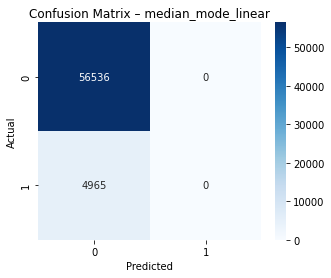

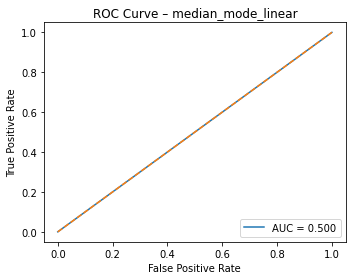

In [661]:
# Affichage des résultats du pipeline DummyClassifier sur train_dfs["median_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- Comme on pouvait s'y attendre, le DummyClassifier ne prédit que la classe majoritaire donc par conséquent on n'a aucune prédiction sur la classe minoritaire. Cela implique le résultat le plus faible possible pour *l'AUC*, puisqu'il n'y a aucune discrimination de classe ici si l'on prédit toujours la même classe.

- Montre aussi que *l'accuracy* seule est totalement *insuffisante* dans notre contexte comme expliqué pendant la phase de mise en place des baselines puisqu'elle atteint ici **0.92** sans jamais prédire la classe 1. Donc sans corriger le déséquilibre (et sans prendre en compte le contexte métier), on ne peut pas se baser que sur cette métrique.

- Enfin cela permet d'affirmer que la capacité d'apprentissage d'un modèle, même simple (baselines par exemple), sur des variables explicatives apporte un gain de performance réel dans un contexte de classes fortement déséquilibrées.

In [296]:
# Fonction pour sauvegarder les résultats de tous les modèles pour comparaison.

def model_comparison_results_row(
    dataset_name,
    model_name,
    method_name,
    y_true,
    y_pred,
    y_proba,
    train_time,
    predict_time,
    business_cost,
    threshold=0.5
):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "Dataset": dataset_name,
        "Model": model_name,
        "Method": method_name,
        "Accuracy Test": accuracy_score(y_true, y_pred),
        "AUC Test": roc_auc_score(y_true, y_proba),
        "Precision Test": precision_score(y_true, y_pred, zero_division=0),
        "Recall Test": recall_score(y_true, y_pred),
        "F1 Test": f1_score(y_true, y_pred),
        "F1 Macro": f1_score(y_true, y_pred, average="macro"),
        "True Negatives": tn,
        "False Positives": fp,
        "False Negatives": fn,
        "True Positives": tp,
        "Train Time (s)": train_time,
        "Predict Time (s)": predict_time,
        "Decision Threshold": threshold,
        "Business_cost" : business_cost
    }

In [662]:
# Sauvegarde des résultats pour DummyClassifier sur train_dfs["median_mode"]

model_comparison_results = []

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="DummyClassifier",
        method_name="prior",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time,
        predict_time=predict_time,
        business_cost=np.nan,
        threshold=0.5
    )
)


#### - Logistic Regression

- On réintroduit ici nos baselines avec la pondération et le seuil optimisé afin de pouvoir comparer aux nouveaux modèles XGBoost et LGBM.

In [672]:
# Récupération du modèle entrainé LR pour évaluer le split de test avec le seuil optimisé.

RUN_ID = "fae00681f9024ef5b157a0145140660a" 
model_lr = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_lr)

In [ ]:
# Utilisation du pipeline LR class weight + seuil optimisé sur train_dfs["median_mode_linear"].

df_name = "median_mode_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.log_param("class_weight", "balanced")
    mlflow.set_tag("threshold_optimized", "yes") 
    mlflow.log_param("decision_threshold", optimal_threshold_linear)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_linear).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1) 
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_lr = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_linear).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_lr)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_lr}")

2026/01/17 15:22:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp6eyz8d2i\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 15:22:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 31568



=== Baseline results for median_mode_linear ===
Accuracy : 0.7501178842620445
F1-score : 0.2917319568623836
Precision : 0.18914719416721448
Recall : 0.6374622356495468
AUC : 0.7733682758223653

Classification report :

              precision    recall  f1-score   support

           0      0.960     0.760     0.848     56536
           1      0.189     0.637     0.292      4965

    accuracy                          0.750     61501
   macro avg      0.574     0.699     0.570     61501
weighted avg      0.898     0.750     0.803     61501



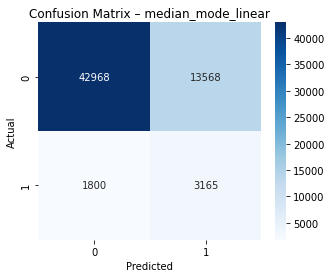

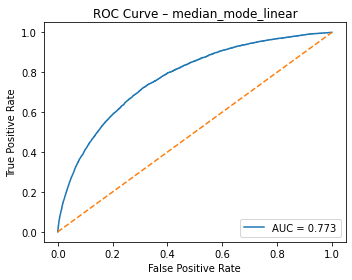

In [680]:
# Affichage des résultats du pipeline LR class weight + seuil optimisé sur train_dfs["median_mode_linear"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [677]:
# Sauvegarde des résultats pour LogisticRegression sur train_dfs["median_mode_linear"]

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression",
        method_name="standard_scaler + OHE + class weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_lr,
        predict_time=predict_time,
        business_cost=optimal_cost_lr,
        threshold=optimal_threshold_linear
    )
)

- On peut ensuite réaliser la même chose avec les autres datasets linéaires (sauf iterative_mode que l'on ne retient pas) en gardant les même paramétres.
- Afin d'évaluer les modèles, pour chaque combinaison modèle/dataset, le seuil de décision est optimisé sur le jeu de validation associé, puis évalué sur un jeu de test indépendant. On compare ensuite les coûts métiers obtenus sur les jeux de test. Cette procédure garantit une comparaison équitable entre les configurations tout en évitant les fuites d’information.

In [ ]:
# Utilisation du pipeline LR class weight sur train_dfs["median_missing_linear"] pour optimiser le seuil de décision.

df_name = "median_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

pipeline = build_class_weight_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("business_cost_optimization_linear")

with mlflow.start_run(run_name=f"class_imbalance_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("objective", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_lr = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1) 
    recall_val = recall_score(y_val, y_pred_val, pos_label=1) 
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_lr)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/17 15:53:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpxfolqibr\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 15:53:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = f14462cef3ba4a5ca525a350084e6096


In [683]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28258
1,0.02,28243
2,0.03,28175
3,0.04,28057
4,0.05,27890
...,...,...
94,0.95,24449
95,0.96,24633
96,0.97,24758
97,0.98,24813


In [684]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_linear = optimal_row["threshold"]
optimal_cost_lr = optimal_row["business_cost"]

optimal_threshold_linear, optimal_cost_lr

(0.49, 15401.0)

In [685]:
# Récupération du modèle entrainé LR pour évaluer le split de test avec le seuil optimisé.

RUN_ID = "f14462cef3ba4a5ca525a350084e6096" 
model_lr = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_lr)

In [ ]:
# Utilisation du pipeline LR class weight + seuil optimisé sur train_dfs["median_missing_linear"].

df_name = "median_missing_linear"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_logreg_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "standard_scaler + OHE")
    mlflow.set_tag("model", "LogisticRegression")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.log_param("class_weight", "balanced")
    mlflow.set_tag("threshold_optimized", "yes") 
    mlflow.log_param("decision_threshold", optimal_threshold_linear)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_linear).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1) 
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.

    optimal_cost_lr = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_linear).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_lr)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Matrice de confusion 
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_lr}")

2026/01/17 15:57:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp_cli87xk\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 15:57:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 31098



=== Baseline results for median_missing_linear ===
Accuracy : 0.7039072535405928
F1-score : 0.2795537268555151
Precision : 0.17394515287282752
Recall : 0.7115810674723061
AUC : 0.7754032864265222

Classification report :

              precision    recall  f1-score   support

           0      0.965     0.703     0.814     56536
           1      0.174     0.712     0.280      4965

    accuracy                          0.704     61501
   macro avg      0.570     0.707     0.547     61501
weighted avg      0.901     0.704     0.771     61501



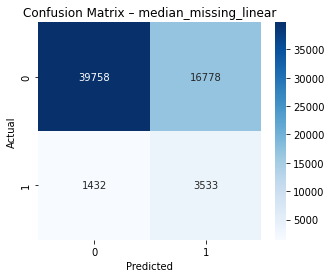

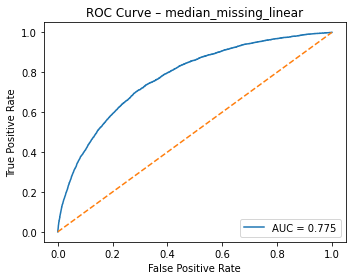

In [687]:
# Affichage des résultats du pipeline LR class weight + seuil optimisé sur train_dfs["median_missing_linear"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [689]:
# Sauvegarde des résultats pour LogisticRegression sur train_dfs["median_missing_linear"]

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="LogisticRegression",
        method_name="standard_scaler + OHE + class weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_lr,
        predict_time=predict_time,
        business_cost=optimal_cost_lr,
        threshold=optimal_threshold_linear
    )
)

- On passe ensuite à **HGB** pour la baseline non linéaire puisque on ne peut pas utiliser "nan_missing_linear" qui contient des Nan avec **LR**.

#### - Modèle HistGradientBoostingClassifier

In [705]:
# Récupération du modèle entrainé HGB pour évaluer sur le split de test avec le seuil optimisé.

RUN_ID = "6191095466f3472d80c9c500a4680cc3" 
model_hgb = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_hgb)

In [ ]:
# Utilisation du pipeline HGB class weight + seuil optimisé sur train_dfs["median_mode"].

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("decision_threshold", optimal_threshold_hgb)
    mlflow.log_param("class_weight", "balanced")


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_hgb).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_hgb = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_hgb).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_hgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_hgb}")

2026/01/17 16:31:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpa9rp7arb\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 16:31:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 30409



=== Baseline results for median_mode ===
Accuracy : 0.7470122437033544
F1-score : 0.2987967010680968
Precision : 0.19246400371574549
Recall : 0.6676737160120846
AUC : 0.7845492595615181

Classification report :

              precision    recall  f1-score   support

           0      0.963     0.754     0.846     56536
           1      0.192     0.668     0.299      4965

    accuracy                          0.747     61501
   macro avg      0.578     0.711     0.572     61501
weighted avg      0.901     0.747     0.802     61501



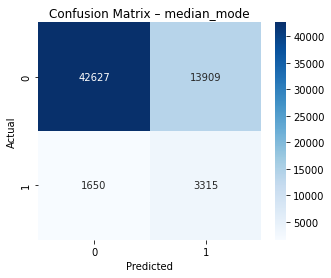

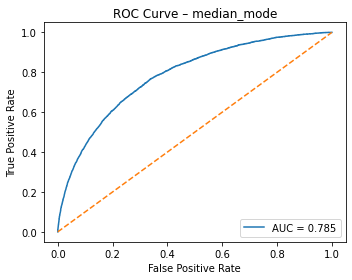

In [707]:
# Affichage des résultats du pipeline HGB class weight + seuil optimisé sur train_dfs["median_mode"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [708]:
# Sauvegarde des résultats pour HGB sur train_dfs["median_mode"]

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier",
        method_name="OHE + class weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_hgb,
        predict_time=predict_time,
        business_cost=optimal_cost_hgb,
        threshold=optimal_threshold_hgb
    )
)

- On retrouve de nouveau des résultats similaire que pendant la phase d'optimisation du seuil de décision mais ici on va aller plus loin et tester aussi les autres datasets prévus pour les modèles non linéaires (hors iterative).

In [ ]:
# Utilisation du pipeline HGB class weight sur train_dfs["median_missing"] pour optimiser le seuil de décision.

df_name = "median_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("business_cost_optimization_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("objective", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)
    train_time_hgb = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_hgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/17 20:20:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpt_8xjwd9\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 20:20:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = 4c4581065d454e869d6280b9effe48c1


In [711]:
# Calcul du coût métier à différent seuil de décision.

cost_hgb_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_hgb_df

,threshold,business_cost
0,0.01,28268
1,0.02,28268
2,0.03,28253
3,0.04,28212
4,0.05,28130
...,...,...
94,0.95,24810
95,0.96,24820
96,0.97,24820
97,0.98,24820


In [712]:
optimal_row = cost_hgb_df.loc[cost_hgb_df["business_cost"].idxmin()]
optimal_threshold_hgb = optimal_row["threshold"]
optimal_cost_hgb = optimal_row["business_cost"]

optimal_threshold_hgb, optimal_cost_hgb

(0.52, 14987.0)

In [713]:
# Récupération du modèle entrainé HGB pour évaluer sur le split de test avec le seuil optimisé.

RUN_ID = "4c4581065d454e869d6280b9effe48c1" 
model_hgb = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_hgb)

In [714]:
# Utilisation du pipeline HGB class weight + seuil optimisé sur train_dfs["median_missing"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")
    mlflow.log_param("decision_threshold", optimal_threshold_hgb)

    mlflow.log_param("class_weight", "balanced")

    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_hgb).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_hgb = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_hgb).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_hgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_hgb}")

2026/01/17 23:00:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp8cpj0pbu\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 23:00:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 30527



=== Baseline results for median_missing ===
Accuracy : 0.7554836506723468
F1-score : 0.3014029545665707
Precision : 0.1958818911901455
Recall : 0.6533736153071501
AUC : 0.7844156762542267

Classification report :

              precision    recall  f1-score   support

           0      0.962     0.764     0.852     56536
           1      0.196     0.653     0.301      4965

    accuracy                          0.755     61501
   macro avg      0.579     0.709     0.577     61501
weighted avg      0.900     0.755     0.807     61501



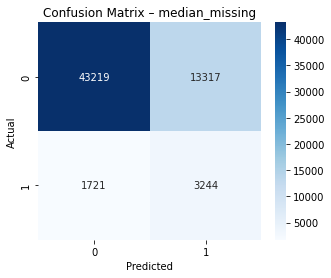

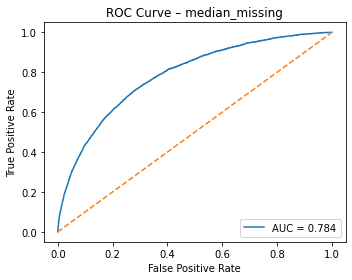

In [715]:
# Affichage des résultats du pipeline HGB class weight + seuil optimisé sur train_dfs["median_missing"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [719]:
# Sauvegarde des résultats pour HGB sur train_dfs["median_missing"]

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier",
        method_name="OHE + class weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_hgb,
        predict_time=predict_time,
        business_cost=optimal_cost_hgb,
        threshold=optimal_threshold_hgb
    )
)

- Résultats similaires à "median_mode"

In [ ]:
# Utilisation du pipeline HGB class weight sur train_dfs["nan_missing"] pour optimiser le seuil de décision.

df_name = "nan_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

pipeline = build_class_weight_non_linear_pipeline(df, categorical_features=["OCCUPATION_TYPE", "ORGANIZATION_TYPE"])

mlflow.set_experiment("business_cost_optimization_non_linear")

with mlflow.start_run(run_name=f"class_imbalance_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("objective", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weight_train)
    train_time_hgb = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_hgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/17 23:08:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpknldbin6\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 23:08:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = 52213308d27a4d618b67bf9ff2ea5843


In [723]:
# Calcul du coût métier à différent seuil de décision.

cost_hgb_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_hgb_df

,threshold,business_cost
0,0.01,28268
1,0.02,28267
2,0.03,28261
3,0.04,28222
4,0.05,28158
...,...,...
94,0.95,24820
95,0.96,24820
96,0.97,24820
97,0.98,24820


In [724]:
optimal_row = cost_hgb_df.loc[cost_hgb_df["business_cost"].idxmin()]
optimal_threshold_hgb = optimal_row["threshold"]
optimal_cost_hgb = optimal_row["business_cost"]

optimal_threshold_hgb, optimal_cost_hgb

(0.52, 14992.0)

In [725]:
# Récupération du modèle entrainé HGB pour évaluer sur le split de test avec le seuil optimisé.

RUN_ID = "52213308d27a4d618b67bf9ff2ea5843" 
model_hgb = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_hgb)

In [726]:
# Utilisation du pipeline HGB class weight + seuil optimisé sur train_dfs["nan_missing"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_histgradboostclass_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "HistGradientBoostingClassifier")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")
    mlflow.log_param("decision_threshold", optimal_threshold_hgb)

    mlflow.log_param("class_weight", "balanced")

    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_hgb).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_hgb = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_hgb).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_hgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_hgb}")

2026/01/17 23:11:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmplouasi5d\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/17 23:11:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 30248



=== Baseline results for nan_missing ===
Accuracy : 0.7570933805954375
F1-score : 0.30409465691526527
Precision : 0.19779420676281662
Recall : 0.6574018126888218
AUC : 0.7848148836107742

Classification report :

              precision    recall  f1-score   support

           0      0.962     0.766     0.853     56536
           1      0.198     0.657     0.304      4965

    accuracy                          0.757     61501
   macro avg      0.580     0.712     0.578     61501
weighted avg      0.900     0.757     0.809     61501



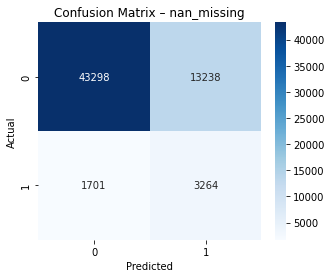

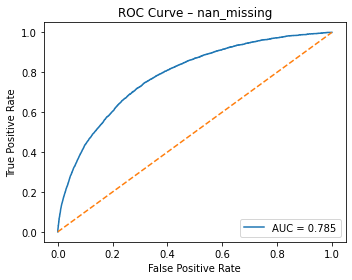

In [727]:
# Affichage des résultats du pipeline HGB class weight + seuil optimisé sur train_dfs["nan_missing"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [729]:
# Sauvegarde des résultats pour HGB sur train_dfs["nan_missing"]

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="HistGradientBoostingClassifier",
        method_name="OHE + class weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_hgb,
        predict_time=predict_time,
        business_cost=optimal_cost_hgb,
        threshold=optimal_threshold_hgb
    )
)

- Globalement pour HGB, les résultats sont assez similaires entre les différents datasets avec des performances métier légérement meilleures pour le dataset *"nan_missing"*.
- On constate toujours cet avantage métier pour les tests utilisant HGB en comparaison avec ceux utilisant LR. On peut maintenant passer au modèle XGBoost pour lequel on utilisera la même méthodologie.

#### - Modèle XGBoost

In [731]:
# Mise en place d'une fonction générique qui construit un pipeline XGBoost adoptant la même méthodologie que les baselines.

def build_xgboost_pipeline(categorical_features, numerical_features, scale_pos_weight=None,
                           xgb_params=None, min_frequency=10, random_state=42):


    # Préprocesseur catégoriel
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=min_frequency
    )

    # Préprocesseur global
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_features),
            ("num", "passthrough", numerical_features)
        ]
    )

    # Hyperparamètres de XGBoost
    default_params = {}
    if scale_pos_weight is not None:
        default_params["scale_pos_weight"] = scale_pos_weight
    default_params["random_state"] = random_state
    default_params["eval_metric"] = "logloss"

    # Merge avec le dictionnaire xgb_params si fourni
    if xgb_params is not None:
        default_params.update(xgb_params)

    # Modèle XGBoost
    model = XGBClassifier(**default_params)

    # Pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessing", preprocessor),
            ("classifier", model)
        ]
    )

    return pipeline

In [732]:
# Paramètres simples utilisé pour la comparaison.

xgb_params = {
    "n_estimators": 300,
    "max_depth": 6,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_jobs": -1
}

- On utilise ici des paramétres simple et non par défaut pour XGB car cela pénaliserai le modèle. 
- Petite différence pour la gestion du déséquilibre des classes, ici on utilise **scale_pos_weight** qui d'après quelques recherches a la même utilité que **class weight** puisque les deux cherchent à rendre les erreurs sur la classe minoritaire plus coûteuses pendant l’apprentissage.
- Les deux méthodes vont pousser le modèle à prédire plus souvent la classe 1 donc cela ne modifie pas le protocole mis en place auparavant (scale_pos_weight est juste mieux adapté à XGBoost en agissant sur la fonction de perte (spécifique aux modèles boosting) au lieu d'agir sur les observations)

In [ ]:
# Utilisation du  pipeline XGBoost sur train_dfs["median_mode"] pour déterminer le seuil.

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_xgboost_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                                  scale_pos_weight=scale_pos_weight, xgb_params=xgb_params)

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("scale_pos_weight", scale_pos_weight)

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_xgb = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_xgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/18 00:30:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp41fh682i\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 00:30:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = facdc79b723b4e13b270f64954e5d14b


In [734]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28239
2,0.03,28142
3,0.04,27967
4,0.05,27714
...,...,...
94,0.95,24790
95,0.96,24820
96,0.97,24820
97,0.98,24820


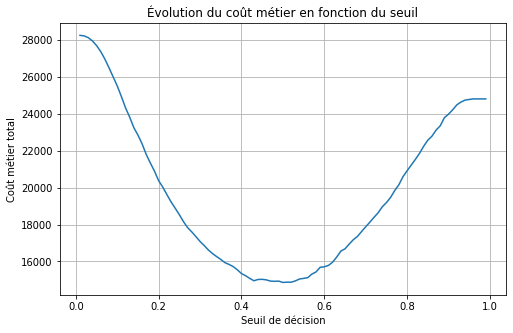

In [735]:
# Visualisation des résultats obtenus

plt.figure(figsize=(8, 5))
plt.plot(cost_df["threshold"], cost_df["business_cost"])
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier total")
plt.title("Évolution du coût métier en fonction du seuil")
plt.grid(True)
plt.show()

In [736]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_xgb = optimal_row["threshold"]
optimal_cost_xgb = optimal_row["business_cost"]

optimal_threshold_xgb, optimal_cost_xgb

(0.5, 14861.0)

In [737]:
cost_05 = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= 0.5).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_opt = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= optimal_threshold_xgb).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_05, cost_opt

(14861, 14861)

- Après cette optimisation du seuil, on peut passer à l'évaluation du set de test en utilisant le seuil trouvé.

In [739]:
# Récupération du modèle entrainé pour évaluer le split val avec le nouveau seuil.

RUN_ID = "facdc79b723b4e13b270f64954e5d14b" 
model_xgb = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_xgb)

In [741]:
# Utilisation du pipeline XGBoost + seuil optimisé sur train_dfs["median_mode"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_param("decision_threshold", optimal_threshold_xgb)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_xgb).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_xgb = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_xgb).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_xgb)    

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_xgb}")

2026/01/18 01:26:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp7a7p0l_5\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 01:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 29982



=== Baseline results for median_mode ===
Accuracy : 0.7630282434431961
F1-score : 0.3086337760910816
Precision : 0.20186161960905988
Recall : 0.6551863041289023
AUC : 0.7872430916229654

Classification report :

              precision    recall  f1-score   support

           0      0.962     0.772     0.857     56536
           1      0.202     0.655     0.309      4965

    accuracy                          0.763     61501
   macro avg      0.582     0.714     0.583     61501
weighted avg      0.901     0.763     0.813     61501



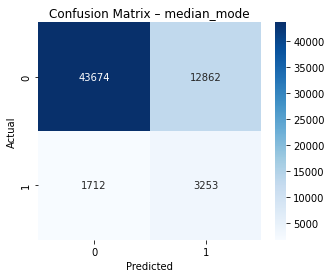

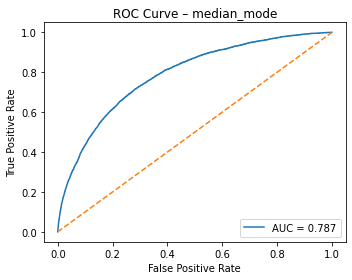

In [742]:
# Affichage des résultats du pipeline XGBoost + seuil optimisé sur train_dfs["median_mode"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [743]:
# Sauvegarde des résultats pour XGBoost sur train_dfs["median_mode"].

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="XGBoost",
        method_name="OHE + scale_pos_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_xgb,
        predict_time=predict_time,
        business_cost=optimal_cost_xgb,
        threshold=optimal_threshold_xgb
    )
)

- Des premiers résultats qui sont légérement meilleurs que ceux des deux baselines d'un point de vue performance métier notamment puisque on descend sous la barre des 30 000.
- Pour ce qui est des performances techniques, on a des résultats assez similaires dans l'ensemble.

In [ ]:
# Utilisation du  pipeline XGBoost sur train_dfs["median_missing"] pour déterminer le seuil.

df_name = "median_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_xgboost_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                                  scale_pos_weight=scale_pos_weight, xgb_params=xgb_params)

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("scale_pos_weight", scale_pos_weight)

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_xgb = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_xgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/18 01:39:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpmjodybkw\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 01:39:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = 612c773295934f57b0b67a054cb2a5ba


In [746]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28236
2,0.03,28139
3,0.04,27999
4,0.05,27754
...,...,...
94,0.95,24792
95,0.96,24820
96,0.97,24820
97,0.98,24820


In [747]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_xgb = optimal_row["threshold"]
optimal_cost_xgb = optimal_row["business_cost"]

optimal_threshold_xgb, optimal_cost_xgb

(0.48000000000000004, 14927.0)

In [748]:
# Récupération du modèle entrainé pour évaluer le split val avec le nouveau seuil.

RUN_ID = "612c773295934f57b0b67a054cb2a5ba" 
model_xgb = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_xgb)

In [749]:
# Utilisation du pipeline XGBoost + seuil optimisé sur train_dfs["median_missing"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_param("decision_threshold", optimal_threshold_xgb)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_xgb).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_xgb = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_xgb).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_xgb)    

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_xgb}")

2026/01/18 01:41:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp7c31tkav\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 01:41:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 30159



=== Baseline results for median_missing ===
Accuracy : 0.7462480284873416
F1-score : 0.30024213075060535
Precision : 0.1931129953279114
Recall : 0.6743202416918429
AUC : 0.7877598812887323

Classification report :

              precision    recall  f1-score   support

           0      0.963     0.753     0.845     56536
           1      0.193     0.674     0.300      4965

    accuracy                          0.746     61501
   macro avg      0.578     0.713     0.573     61501
weighted avg      0.901     0.746     0.801     61501



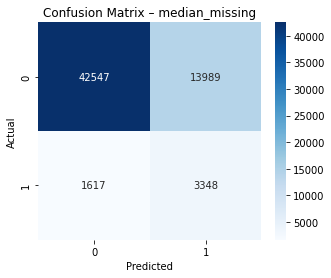

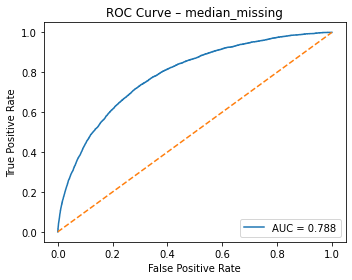

In [750]:
# Affichage des résultats du pipeline XGBoost + seuil optimisé sur train_dfs["median_missing"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [752]:
# Sauvegarde des résultats pour XGBoost sur train_dfs["median_missing"].

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="XGBoost",
        method_name="OHE + scale_pos_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_xgb,
        predict_time=predict_time,
        business_cost=optimal_cost_xgb,
        threshold=optimal_threshold_xgb
    )
)

- Résultats similaires à "median_mode" (légére augmentation coût métier)

In [ ]:
# Utilisation du  pipeline XGBoost sur train_dfs["nan_missing"] pour déterminer le seuil.

df_name = "nan_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_xgboost_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                                  scale_pos_weight=scale_pos_weight, xgb_params=xgb_params)

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("scale_pos_weight", scale_pos_weight)

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_xgb = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_xgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/18 01:46:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmp2bpsgtfx\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 01:46:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = ab617e5b49a24626bca6bbf80d6806af


In [755]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28243
2,0.03,28153
3,0.04,28011
4,0.05,27770
...,...,...
94,0.95,24811
95,0.96,24820
96,0.97,24820
97,0.98,24820


In [756]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_xgb = optimal_row["threshold"]
optimal_cost_xgb = optimal_row["business_cost"]

optimal_threshold_xgb, optimal_cost_xgb

(0.52, 14695.0)

In [757]:
# Récupération du modèle entrainé pour évaluer le split val avec le nouveau seuil.

RUN_ID = "ab617e5b49a24626bca6bbf80d6806af" 
model_xgb = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_xgb)

In [758]:
# Utilisation du pipeline XGBoost + seuil optimisé sur train_dfs["nan_missing"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_param("decision_threshold", optimal_threshold_xgb)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_xgb).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_xgb = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_xgb).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_xgb)    

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_xgb}")

2026/01/18 02:16:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpqyexq87n\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 02:16:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 30374



=== Baseline results for nan_missing ===
Accuracy : 0.7815320076096324
F1-score : 0.31455973880216304
Precision : 0.21063059370089499
Recall : 0.6209466263846929
AUC : 0.7878194428353791

Classification report :

              precision    recall  f1-score   support

           0      0.960     0.796     0.870     56536
           1      0.211     0.621     0.315      4965

    accuracy                          0.782     61501
   macro avg      0.585     0.708     0.592     61501
weighted avg      0.899     0.782     0.825     61501



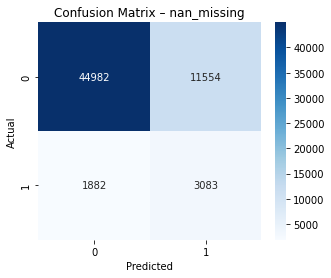

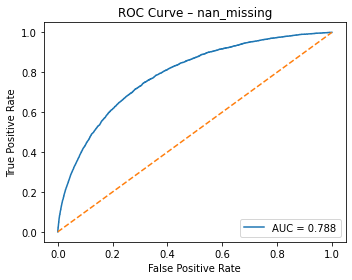

In [759]:
# Affichage des résultats du pipeline XGBoost + seuil optimisé sur train_dfs["nan_missing"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [761]:
# Sauvegarde des résultats pour XGBoost sur train_dfs["nan_missing"].

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="XGBoost",
        method_name="OHE + scale_pos_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_xgb,
        predict_time=predict_time,
        business_cost=optimal_cost_xgb,
        threshold=optimal_threshold_xgb
    )
)

- Globalement les résultats obtenus avec des paramétres standards sont légérement meilleurs que les baselines avec un léger gain au niveau du coût métier.
- On peut ensuite passer au dernier modèle LGBM qui devrait donner des performances similaire à XGBoost mais être globalement plus rapide.

#### - Modèle LGBM

In [36]:
# Mise en place d'une fonction générique qui construit un pipeline LGBM adoptant la même méthodologie que les baselines.

def build_lgbm_pipeline(categorical_features, numerical_features, class_weight="balanced",
                        eval_metric="binary_logloss", lgbm_params=None, min_frequency=10, random_state=42):


    # Préprocesseur catégoriel
    categorical_transformer = OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=min_frequency
    )

    # Préprocesseur global
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_transformer, categorical_features),
            ("num", "passthrough", numerical_features)
        ]
    )

    # Paramètres par défaut
    default_params = {}    
    default_params["class_weight"] = class_weight
    default_params["random_state"] = random_state
    default_params["eval_metric"] = eval_metric


    # Merge avec paramètres fournis
    if lgbm_params is not None:
        default_params.update(lgbm_params)

    # Modèle LGBM
    model = LGBMClassifier(**default_params)

    # Pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessing", preprocessor),
            ("classifier", model)
        ]
    )

    return pipeline

In [764]:
# Paramètres simples utilisé pour la comparaison.

lgbm_params = {
    "objective": "binary",
    "n_estimators": 300,
    "learning_rate": 0.05,
    "num_leaves": 30,
    "force_col_wise": True,
    "verbosity": -1,
    "n_jobs": -1
}

In [ ]:
# Utilisation du  pipeline LGBM sur train_dfs["median_mode"] pour déterminer le seuil.

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_lgbm_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                               lgbm_params=lgbm_params)

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_lgbm = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_lgbm)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/18 02:34:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpner2crqq\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 02:34:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = e97de945fbee42d59d76d86877cd6787


In [766]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28267
2,0.03,28221
3,0.04,28130
4,0.05,27950
...,...,...
94,0.95,24790
95,0.96,24820
96,0.97,24820
97,0.98,24820


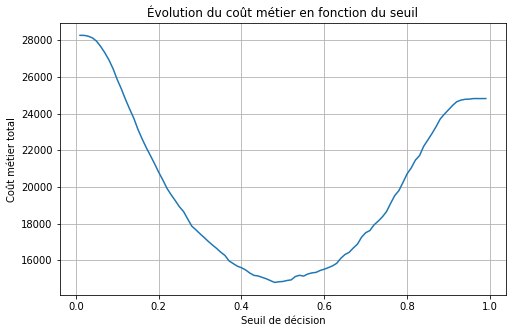

In [767]:
# Visualisation des résultats obtenus

plt.figure(figsize=(8, 5))
plt.plot(cost_df["threshold"], cost_df["business_cost"])
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier total")
plt.title("Évolution du coût métier en fonction du seuil")
plt.grid(True)
plt.show()

In [771]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_lgbm = optimal_row["threshold"]
optimal_cost_lgbm = optimal_row["business_cost"]

optimal_threshold_lgbm, optimal_cost_lgbm

(0.48000000000000004, 14791.0)

In [770]:
cost_05 = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= 0.5).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_opt = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= optimal_threshold_lgbm).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_05, cost_opt

(14844, 14791)

- Après cette optimisation du seuil, on peut passer à l'évaluation du set de test en utilisant le seuil trouvé.

In [ ]:
# Récupération du modèle entrainé pour évaluer le split test avec le nouveau seuil.

RUN_ID = "e97de945fbee42d59d76d86877cd6787" 
model_lgbm = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_lgbm)

In [773]:
# Utilisation du pipeline LGBM + seuil optimisé sur train_dfs["median_mode"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("decision_threshold", optimal_threshold_lgbm)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_lgbm).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_lgbm = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_lgbm).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_lgbm)    

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_lgbm}")

2026/01/18 02:42:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpyppgkw34\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 02:42:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 29938



=== Baseline results for median_mode ===
Accuracy : 0.7280369424887401
F1-score : 0.2948566610455312
Precision : 0.18645694481471609
Recall : 0.7043303121852971
AUC : 0.788306015320773

Classification report :

              precision    recall  f1-score   support

           0      0.966     0.730     0.832     56536
           1      0.186     0.704     0.295      4965

    accuracy                          0.728     61501
   macro avg      0.576     0.717     0.563     61501
weighted avg      0.903     0.728     0.788     61501



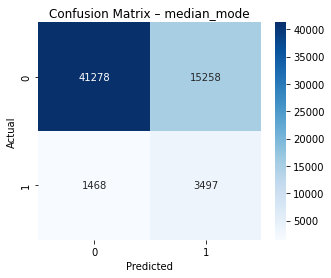

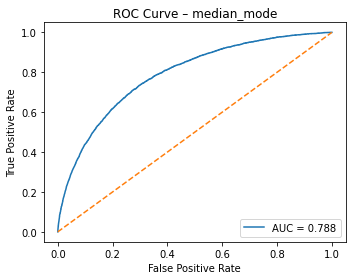

In [775]:
# Affichage des résultats pour LGBM sur train_dfs["median_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [777]:
# Sauvegarde des résultats pour LGBM sur train_dfs["median_mode"].

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="LGBM",
        method_name="OHE + class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_lgbm,
        predict_time=predict_time,
        business_cost=optimal_cost_lgbm,
        threshold=optimal_threshold_lgbm
    )
)

- Les résultats de ce premier test LGBM sont pour le moment les meilleurs en terme de coût métier global  et cela avec une exécution beaucoup plus rapide que XGBoost.

In [ ]:
# Utilisation du  pipeline LGBM sur train_dfs["median_missing"] pour déterminer le seuil.

df_name = "median_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_lgbm_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                               lgbm_params=lgbm_params)

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_lgbm = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_lgbm)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/18 02:49:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpo7llhajx\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 02:49:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = 4b2948ae6f724d2b9b63662077750d58


In [780]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28264
2,0.03,28232
3,0.04,28133
4,0.05,27965
...,...,...
94,0.95,24820
95,0.96,24820
96,0.97,24820
97,0.98,24820


In [781]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_lgbm = optimal_row["threshold"]
optimal_cost_lgbm = optimal_row["business_cost"]

optimal_threshold_lgbm, optimal_cost_lgbm

(0.51, 14735.0)

In [782]:
# Récupération du modèle entrainé pour évaluer le split test avec le nouveau seuil.

RUN_ID = "4b2948ae6f724d2b9b63662077750d58" 
model_lgbm = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_lgbm)

In [783]:
# Utilisation du pipeline LGBM + seuil optimisé sur train_dfs["median_missing"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("decision_threshold", optimal_threshold_lgbm)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_lgbm).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_lgbm = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_lgbm).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_lgbm)    

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_lgbm}")

2026/01/18 02:52:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpl8jebssu\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 02:52:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 30172



=== Baseline results for median_missing ===
Accuracy : 0.7529145867546869
F1-score : 0.30287182310303695
Precision : 0.19610289312659657
Recall : 0.6648539778449144
AUC : 0.7878809619793629

Classification report :

              precision    recall  f1-score   support

           0      0.963     0.761     0.850     56536
           1      0.196     0.665     0.303      4965

    accuracy                          0.753     61501
   macro avg      0.579     0.713     0.576     61501
weighted avg      0.901     0.753     0.806     61501



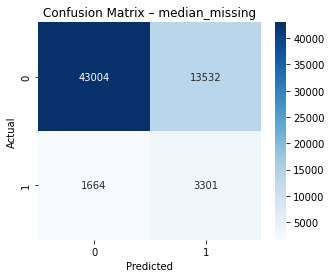

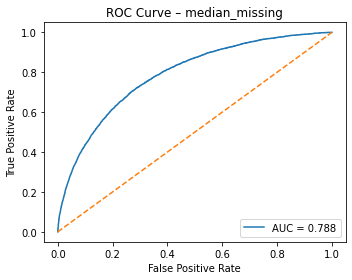

In [784]:
# Affichage des résultats du pipeline LGBM + seuil optimisé sur train_dfs["median_missing"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [786]:
# Sauvegarde des résultats pour LGBM sur train_dfs["median_missing"].

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="LGBM",
        method_name="OHE + class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_lgbm,
        predict_time=predict_time,
        business_cost=optimal_cost_lgbm,
        threshold=optimal_threshold_lgbm
    )
)

- Résultats toujours assez similaires.

In [ ]:
# Utilisation du  pipeline LGBM sur train_dfs["nan_missing"] pour déterminer le seuil.

df_name = "nan_missing"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_lgbm_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                               lgbm_params=lgbm_params)

mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_lgbm = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_lgbm)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/18 02:54:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpjgs78lk9\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 02:54:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = de61092636ad40a4953b34ad7dcb06ab


In [788]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28267
2,0.03,28231
3,0.04,28146
4,0.05,27962
...,...,...
94,0.95,24821
95,0.96,24820
96,0.97,24820
97,0.98,24820


In [789]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_lgbm = optimal_row["threshold"]
optimal_cost_lgbm = optimal_row["business_cost"]

optimal_threshold_lgbm, optimal_cost_lgbm

(0.49, 14721.0)

In [790]:
# Récupération du modèle entrainé pour évaluer le split test avec le nouveau seuil.

RUN_ID = "de61092636ad40a4953b34ad7dcb06ab" 
model_lgbm = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_lgbm)

In [791]:
# Utilisation du pipeline LGBM + seuil optimisé sur train_dfs["nan_missing"].


mlflow.set_experiment("model_comparison")

with mlflow.start_run(run_name=f"model_comparison_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "model_comparison")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("decision_threshold", optimal_threshold_lgbm)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_lgbm).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_lgbm = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_lgbm).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_lgbm)    

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_lgbm}")

2026/01/18 02:56:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpgaqasiby\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/18 02:56:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 30182



=== Baseline results for nan_missing ===
Accuracy : 0.7372400448773191
F1-score : 0.29659615217202057
Precision : 0.18918318618468544
Recall : 0.6862034239677745
AUC : 0.7883006145608761

Classification report :

              precision    recall  f1-score   support

           0      0.964     0.742     0.838     56536
           1      0.189     0.686     0.297      4965

    accuracy                          0.737     61501
   macro avg      0.577     0.714     0.568     61501
weighted avg      0.902     0.737     0.795     61501



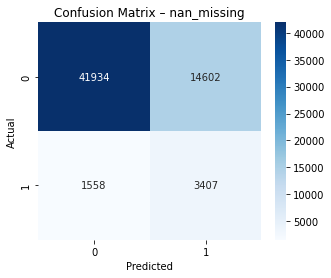

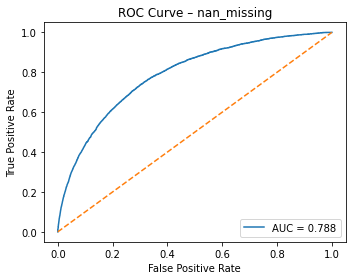

In [792]:
# Affichage des résultats du pipeline LGBM + seuil optimisé sur train_dfs["nan_missing"].

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [794]:
# Sauvegarde des résultats pour LGBM sur train_dfs["nan_missing"].

model_comparison_results.append(model_comparison_results_row(
        dataset_name=df_name,
        model_name="LGBM",
        method_name="OHE + class_weight",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_lgbm,
        predict_time=predict_time,
        business_cost=optimal_cost_lgbm,
        threshold=optimal_threshold_lgbm
    )
)

In [795]:
model_comparison_results_df = pd.DataFrame(model_comparison_results)
model_comparison_results_df

,Dataset,Model,Method,Accuracy Test,AUC Test,Precision Test,Recall Test,F1 Test,F1 Macro,True Negatives,False Positives,False Negatives,True Positives,Train Time (s),Predict Time (s),Decision Threshold,Business_cost
0,median_mode_linear,DummyClassifier,prior,0.919270,0.500000,0.000000,0.000000,0.000000,0.478968,56536,0,4965,0,0.008007,0.002002,0.50,NaN
1,median_mode_linear,LogisticRegression,standard_scaler + OHE + class weight,0.750118,0.773368,0.189147,0.637462,0.291732,0.570015,42968,13568,1800,3165,14.905435,0.507749,0.54,31568.0
2,median_missing_linear,LogisticRegression,standard_scaler + OHE + class weight,0.703907,0.775403,0.173945,0.711581,0.279554,0.546608,39758,16778,1432,3533,16.160718,1.259864,0.49,31098.0
3,median_mode,HistGradientBoostingClassifier,OHE + class weight,0.747012,0.784549,0.192464,0.667674,0.298797,0.572231,42627,13909,1650,3315,34.111885,1.035944,0.51,30409.0
4,median_missing,HistGradientBoostingClassifier,OHE + class weight,0.755484,0.784416,0.195882,0.653374,0.301403,0.576605,43219,13317,1721,3244,32.873929,1.301792,0.52,30527.0
5,nan_missing,HistGradientBoostingClassifier,OHE + class weight,0.757093,0.784815,0.197794,0.657402,0.304095,0.578482,43298,13238,1701,3264,33.205758,1.024544,0.52,30248.0
6,median_mode,XGBoost,OHE + scale_pos_weight,0.763028,0.787243,0.201862,0.655186,0.308634,0.582821,43674,12862,1712,3253,142.801821,0.537153,0.50,29982.0
7,median_missing,XGBoost,OHE + scale_pos_weight,0.746248,0.787760,0.193113,0.674320,0.300242,0.572633,42547,13989,1617,3348,139.676035,0.544790,0.48,30159.0
8,nan_missing,XGBoost,OHE + scale_pos_weight,0.781532,0.787819,0.210631,0.620947,0.314560,0.592309,44982,11554,1882,3083,142.293585,0.575037,0.52,30374.0
9,median_mode,LGBM,OHE + class_weight,0.728037,0.788306,0.186457,0.704330,0.294857,0.563194,41278,15258,1468,3497,18.231446,0.536489,0.48,29938.0


- Globalement, on peut voir que les résultats sont assez similaires sans gros écarts entre tous les modèles.

- Pour le ***Recall*** on oscille entre **0.62** et **0.70** et pour la ***précision*** entre **0.17** et **0.21** donc les plages des valeurs restent assez restraintes. Il en va de même des métriques plus générale comme ***l'AUC*** (**0.77** à **0.78**) et ***l'accuracy*** (**0.70** à **0.78** hors Dummy).

- Finalement, ce qui va distinguer nos différents modèles ici, ce sont les coûts métier globaux qui sont plus faibles pour **XGBoost** et **LGBM** (- de 30 000) avec un léger avantage pour LGBM. Mais ce n'est pas tout puisque LGBM est l'un des plus rapide de tout nos modèles (18 sec pour l'entrainement pour tous les datasets derrière LR qu oscille entre 14 et 16 sec).

- Donc en prenant tous ces éléments, on choisira logiquement de garder les meilleurs compromis performance/coût métier obtenus avec **LGBM** et **XGBoost**, qui sont retenus pour une optimisation avancée.


### Optimisation des modèles retenus

- L’objectif de cette section est désormais d’aller au-delà de la simple comparaison de modèles, en cherchant à optimiser finement les modèles retenus afin d’améliorer encore leur impact métier. Cette optimisation portera à la fois sur les **hyperparamètres** du modèle et le **seuil de décision** (que l'on calculera de nouveau à la fin)

- Contrairement aux étapes précédentes, où les modèles étaient évalués avec des configurations proches des paramètres par défaut, cette phase vise une recherche ciblée et méthodique des configurations les plus adaptées au problème métier étudié.

- L’évaluation du modèle optimisé reposera en priorité sur le coût métier minimal (car même si FN est plus coûteux, si un modèle pénalise trop fort la prédiction de la classe 0 cela peut être négatif sur le coût global avec une trop grande augmentation des FP), défini comme métrique de décision principale, afin de garantir une cohérence totale avec les objectifs du projet.
Cependant les métriques techniques tel que l'accuracy par exemple, reste à surveiller pour éviter tout overfitting ou tout autre dégradation des performances. 

#### - Optimisation des hyperparamètres

- *LightGBM* et *XGBoost* sont des modèles très performants mais également sensibles à leurs hyperparamètres (notamment la complexité des arbres, la régularisation et le compromis biais/variance). Les paramètres standards utilisés constituent une base raisonnable, mais ne sont pas optimisés pour un objectif métier spécifique, ni pour un fort déséquilibre de classes.

- Cette optimisation des hyperparamètres se *limitera en complexité* pour éviter le surapprentissage, privilégier la *capacité de généralisation* et conserver des plages de valeurs réalistes donc on n'explore pas toutes les combinaisons possibles mais on essaye trouver une *configuration robuste* permettant de minimiser le coût métier.

- Pour la stratégie d'optimisation, on utilisera **Optuna** qui est une alternative à **GridSearchCV** car d'après quelques recherches, il serait trop coûteux en calcul et moins adapté aux modèles plus complexe (car GridSearchCV testent toutes les combinaisons possibles, ce qui augmente énormément le nombre d'essais et donc le temps de convergence + ne prend pas en compte les coûts asymétriques FP/FN).

- C'est pourquoi on a trouvé la solution **Optuna** qui est une optimisation bayésienne (méthode pour trouver le minimum (ou maximum) d’une fonction coûteuse à évaluer, en apprenant progressivement où chercher) qui est la mieux adaptée ici. En effet, cette solution est très intéressante puisque en apprenant à chaque essai, elle *converge plus vite* vers les résultats pertinents, elle est donc très bien adaptée aux modèles plus complexe comme *XGBoost* ou *LightGBM* et surtout l'avantage de cette solution est justement de pouvoir intégré une métrique métier (fonction objectif) afin d'optimiser le modèle dans cette optique.

#### - Optimisation des hyperparamètres du modèle XGBoost

In [ ]:
# Fonction permettant de préparer le dataframe pour optuna

def model_preprocessor(categorical_features, numerical_features, min_frequency=10):
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=min_frequency), categorical_features),
            ("num", "passthrough", numerical_features)
        ]
    )
    return preprocessor

In [ ]:
# Mise en place d'une fonction pour chercher les meilleurs hyperparamètres pour XGBoost.

def optuna_optimization_xgb(trial, params_fn, X_train, y_train, n_splits=3, threshold=0.5, random_state=42,
                            early_stopping_rounds=None):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    params = params_fn(trial)

    costs = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        scale_pos_weight = (y_train_fold == 0).sum() / max((y_train_fold == 1).sum(), 1)

        model = XGBClassifier(
            **params,
            scale_pos_weight=scale_pos_weight,
            early_stopping_rounds=early_stopping_rounds,
            eval_metric="logloss",
            random_state=random_state
        )

        # Entraînement
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)

        # Prédiction + seuil
        y_pred = (model.predict_proba(X_val_fold)[:, 1] >= threshold).astype(int)

        # Métrique métier qui nous intéresse
        cost = business_cost(y_val_fold, y_pred)
        costs.append(cost)

        # Pruner
        trial.report(np.mean(costs), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(costs)

- Alors ici on a mis en place une fonction générique pour pouvoir réaliser l'optimisation des hyperparamètres des deux modèles avec Optuna. Pour cela on utilise la **cross validation** qui sert à évaluer de manière robuste un jeu d’hyperparamètres, en effet au lieu de ne travailler que sur un seul split la CV permet de découper le jeu de donnée en plusieurs split (selon n_split choisi) que l'on utilise pour entrainer et évaluer les hyperparamétres d'un essai.
- En procédant ainsi on obtient différents scores par fold puis on regarde la moyenne de ces scores obtenus qui nous donne un score final reflètant la performance moyenne attendue du modèle sur des données inconnues. Cela permet de limiter la dépendance à un seul split train/validation, réduire la variance de l'évaluation et de comparer les hyperparamètres de manière fiable.
- De plus ici on utilise **StratifiedKFold** qui est une variante de CV utile lorsque l'on a un problème de déséquilibre comme ici, puisque chaque fold chaque fold contient à peu près la même proportion de classes. Sans cette stratification on pourrait par exemple avoir des folds avec très peu ou sans observations de la classe minoritaire.

In [498]:
def xgb_params_fn(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.12),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 20),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "n_jobs": -1
    }

In [ ]:
# Recherche de la meilleure combinaison d'hyperparamétres pour ce modèle.

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(train_dfs['median_mode'].drop(columns=["SK_ID_CURR"]), target_col="TARGET")
categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

preprocessor = model_preprocessor(X_train, categorical_features, numerical_features)
X_train_enc = preprocessor.fit_transform(X_train)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=0)
study_xgb = optuna.create_study(direction="minimize", pruner=pruner)
study_xgb.optimize(
    lambda trial: optuna_optimization_xgb(
        trial=trial,
        params_fn=xgb_params_fn,
        X_train=X_train_enc,
        y_train=y_train.values,
        n_splits=2,
        threshold=0.5
    ),
    n_trials=30
)

[I 2026-01-08 23:38:20,319] A new study created in memory with name: no-name-069b5a9f-8e0d-4cec-950c-2bc4d5410044
[I 2026-01-08 23:41:52,315] Trial 0 finished with value: 59508.0 and parameters: {'n_estimators': 422, 'learning_rate': 0.10566854221855954, 'max_depth': 6, 'min_child_weight': 11, 'subsample': 0.747055543558412, 'colsample_bytree': 0.8023962564644294, 'gamma': 3.1683119804944466}. Best is trial 0 with value: 59508.0.
[I 2026-01-08 23:44:14,318] Trial 1 finished with value: 53023.5 and parameters: {'n_estimators': 487, 'learning_rate': 0.08962240736643107, 'max_depth': 3, 'min_child_weight': 13, 'subsample': 0.8644949438352983, 'colsample_bytree': 0.8279871556588355, 'gamma': 3.6323801509212927}. Best is trial 1 with value: 53023.5.
[I 2026-01-08 23:45:54,316] Trial 2 finished with value: 53506.5 and parameters: {'n_estimators': 273, 'learning_rate': 0.1183056776092665, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.8194228022643646, 'colsample_bytree': 0.8174148542

In [504]:
# Résultats obtenus à chaque essai.

df_trials = study_xgb.trials_dataframe()
df_trials.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
23,23,52880.5,2026-01-09 00:40:37.788929,2026-01-09 00:43:11.153713,0 days 00:02:33.364784,0.789046,4.061169,0.074647,3,9,544,0.802847,COMPLETE
11,11,52927.5,2026-01-09 00:11:01.190112,2026-01-09 00:13:17.471199,0 days 00:02:16.281087,0.755365,4.932068,0.090304,3,7,495,0.867949,COMPLETE
21,21,52987.0,2026-01-09 00:35:49.712311,2026-01-09 00:38:18.754932,0 days 00:02:29.042621,0.778448,4.371955,0.075243,3,5,529,0.855526,COMPLETE
25,25,52999.0,2026-01-09 00:46:24.510412,2026-01-09 00:49:03.211052,0 days 00:02:38.700640,0.748033,4.165922,0.062120,3,7,559,0.829735,COMPLETE
1,1,53023.5,2026-01-08 23:41:52.315893,2026-01-08 23:44:14.318772,0 days 00:02:22.002879,0.827987,3.632380,0.089622,3,13,487,0.864495,COMPLETE
13,13,53031.0,2026-01-09 00:15:38.138350,2026-01-09 00:18:06.505382,0 days 00:02:28.367032,0.772238,4.353723,0.077553,3,5,525,0.865122,COMPLETE
27,27,53084.0,2026-01-09 00:51:33.604936,2026-01-09 00:53:59.499658,0 days 00:02:25.894722,0.733142,4.173643,0.068122,3,6,515,0.899377,COMPLETE
3,3,53087.0,2026-01-08 23:45:54.317380,2026-01-08 23:48:35.043682,0 days 00:02:40.726302,0.988690,4.909103,0.092016,3,8,474,0.812034,COMPLETE
18,18,53150.0,2026-01-09 00:28:46.118027,2026-01-09 00:31:36.353002,0 days 00:02:50.234975,0.876790,3.951835,0.083646,3,16,557,0.843808,COMPLETE
22,22,53193.0,2026-01-09 00:38:18.761440,2026-01-09 00:40:37.787929,0 days 00:02:19.026489,0.741572,4.508124,0.087571,3,6,505,0.854783,COMPLETE


- Permet ici de voir quels sont les différents paramétres utilisé pour chaque essais, le résultat et le temps d'exécution.
- Cela permet par exemple de voir certaines tendances comme par exemple, est ce que le modèle a tendance à se complexifier pour un gain marginal sur les derniers essais ou alors déterminer des plages de valeurs plus restreintes intéressantes à tester (pour éviter des essais superflus).
- Surtout que XGBoost est beaucoup plus lent que LGBM donc il est difficile de réaliser beaucoup d'essais en 1 seule fois il faut donc diminuer les plages de valeurs à tester de manière pertinente.
- De plus, ici on a ajouté par exemple **pruner = optuna.pruners** pour stopper un essai lorsque celui-ci n'est pas prometteur ce qui permet de gagner du temps, il faut aussi adapter à quel moment on stop l'essai.

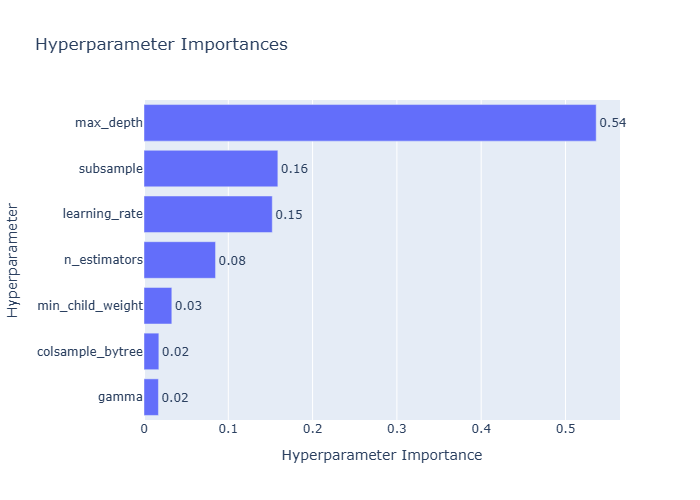

In [501]:
# Visualisation de l'importance de chaque hyperparamétre sur l'ensemble des tests.

optuna.visualization.plot_param_importances(study_xgb)

- Ce graphique est intéressant car il mesure l’influence relative de chaque hyperparamètre sur la valeur de l'objectif ( ici le coût métier) sur l’ensemble des trials Optuna.

- Comme on peut le voir on a : 

    - **max_depth** qui donne la profondeur maximale de chaque arbre (globalement une grande profondeur donne un modèle plus complexe et du risque de sur-apprentissage.) (ici on peut *resserer la plage* car le modèle se construit trop sur la complexité de l'arbre et pas assez sur les autres paramétres de boosting et régularisation)

    - **subsample** qui est la fraction d’échantillons utilisée pour entraîner chaque arbre (pourcentage des données vues - permet de régulariser pour empêche le modèle de sur-apprendre donc réduire la plage peut être intéressant ici)

    - **learning_rate** qui est la taille des pas dans l’apprentissage des arbres (par exemple petit learning_rate donne un apprentissage plus lent mais stable donc on peut *réduire la plage* aussi)

    - **n_estimators**  est le nombre maximal d’arbres à entraîner (iterations) donc contrôle la capacité totale du modèle (ici avec early stopping fixer un *nombre important* permet de choisir le bon nombre mais avant cela on le fixera à 500 pour faciliter la recherche des autres paramétres)

    - **min_child_weight** est la somme minimale des poids des observations dans une feuille pour que XGBoost crée cette feuille (contrôle la taille minimale d’une feuille donc de grandes valeurs donne des feuilles plus conservatrices donc moins de sur-apprentissage donc *augmenter la plage* pour renforcer son effet ici)
    
    - **colsample_bytree** qui est la fraction de features utilisée pour chaque arbre (pourcentage des des colonnes vues - permet de la régularisation puisque permet de réduire la corrélation entre arbres donc réduire la plage peut être intéressant ici comme subsample)

    - **gamma** qui est le gain minimal pour qu’une division soit effectuée (donc par exemple 0 permet toutes les divisions possibles et 5 seulement les plus significatives donc plus conservateur, peut être faut il mieux *renforcer son effet* aussi par rapport à max_depth)

- Donc on va ensuite changer les plages de valeurs pour essayer d'avoir un modèle plus stable puisque **max_depth** est trop dominant par rapport aux autre hyperparamétres. Cela passe par une réduction de l'hyperparamètre **max_depth** trop important et élargissement / renforcement de ceux qui contrôlent la complexité.

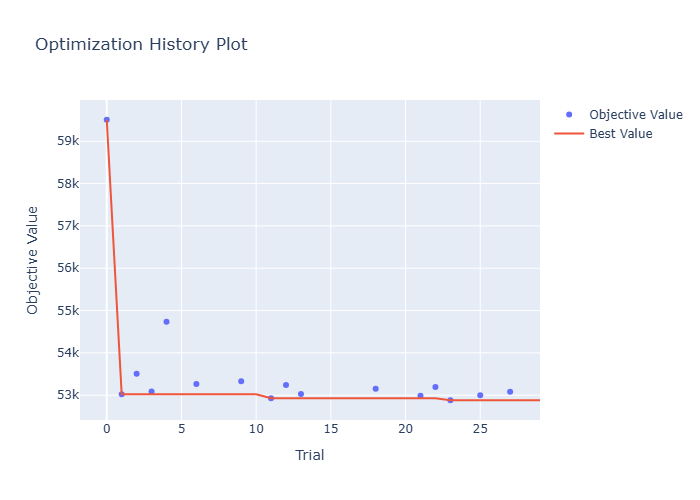

In [ ]:
# Visualisation de l'historique de l'optimisation du modèle.

optuna.visualization.plot_optimization_history(study_xgb)

- Le graphique d’historique d’optimisation permet montre l’évolution du score objectif au fil des trials soit le coût métier à minimiser.
- Ici on peut voir une amélioration rapide du coût métier lors des premiers essais, suivie d’un plateau avec de légéres baisses (gains marginaux) à certains moment. Cela indique que l’espace de recherche est correctement défini et que les gains supplémentaires deviennent marginaux, suggérant une convergence de l’optimisation (en vérifiant l'évolution des paramètres car si ces gains sont dûs à un modèle plus complexe et des essais plus long cela signifie que l'on optimise sur le bruit)

In [508]:
def xgb_params_fn_refined(trial):
    return {
        "n_estimators": 500,
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 4),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.9),
        "gamma": trial.suggest_float("gamma", 2, 5),
        "n_jobs": -1
    }

In [ ]:
# Tentative de tuning plus fin 
pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=0)
study_xgb = optuna.create_study(direction="minimize", pruner=pruner)
study_xgb.optimize(
    lambda trial: optuna_optimization_xgb(
        trial=trial,
        params_fn=xgb_params_fn_refined,
        X_train=X_train_enc,
        y_train=y_train.values,
        n_splits=2,
        threshold=0.5,
        early_stopping_rounds=50
    ),
    n_trials=30
)

[I 2026-01-09 13:50:09,240] A new study created in memory with name: no-name-72e27522-edbf-4ee1-8825-3ce11c73f52f
[I 2026-01-09 13:53:16,336] Trial 0 finished with value: 53483.0 and parameters: {'learning_rate': 0.08073834208455563, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7905580081854156, 'colsample_bytree': 0.8794768074693108, 'gamma': 3.2465648400672196}. Best is trial 0 with value: 53483.0.
[I 2026-01-09 13:56:22,038] Trial 1 finished with value: 54140.5 and parameters: {'learning_rate': 0.07851300325724991, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6163718710449355, 'colsample_bytree': 0.844606928107501, 'gamma': 3.9996493754688487}. Best is trial 0 with value: 53483.0.
[I 2026-01-09 13:59:22,791] Trial 2 finished with value: 53296.5 and parameters: {'learning_rate': 0.027858485369887068, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6657082967670762, 'colsample_bytree': 0.8121039803860493, 'gamma': 3.3030907868555213}. Best is trial 2 with value

In [512]:
# Résultats obtenus à chaque essai.

df_trials_refined = study_xgb.trials_dataframe()
df_trials_refined.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_subsample,state
24,24,52906.5,2026-01-09 15:00:36.121653,2026-01-09 15:02:49.801345,0 days 00:02:13.679692,0.737850,4.370087,0.083481,3,15,0.714973,COMPLETE
21,21,52917.0,2026-01-09 14:53:37.805565,2026-01-09 14:56:00.069723,0 days 00:02:22.264158,0.820970,4.660626,0.068953,3,14,0.822160,COMPLETE
19,19,52937.0,2026-01-09 14:48:56.909333,2026-01-09 14:51:19.560553,0 days 00:02:22.651220,0.821194,4.659383,0.065520,3,14,0.824155,COMPLETE
23,23,52959.0,2026-01-09 14:58:22.173977,2026-01-09 15:00:36.121653,0 days 00:02:13.947676,0.737833,4.323481,0.061562,3,12,0.720297,COMPLETE
28,28,52969.0,2026-01-09 15:09:38.795383,2026-01-09 15:11:59.927981,0 days 00:02:21.132598,0.806049,3.838607,0.072174,3,13,0.738250,COMPLETE
8,8,52973.5,2026-01-09 14:12:48.096497,2026-01-09 14:15:15.546977,0 days 00:02:27.450480,0.843510,4.637789,0.059430,3,12,0.772945,COMPLETE
29,29,52975.0,2026-01-09 15:11:59.928983,2026-01-09 15:14:14.086328,0 days 00:02:14.157345,0.742748,3.416124,0.083224,3,7,0.815767,COMPLETE
18,18,52984.5,2026-01-09 14:46:33.540419,2026-01-09 14:48:56.905399,0 days 00:02:23.364980,0.822196,4.604733,0.069105,3,14,0.824469,COMPLETE
5,5,52988.0,2026-01-09 14:04:40.400922,2026-01-09 14:07:53.409693,0 days 00:03:13.008771,0.891963,3.982073,0.037999,4,11,0.888373,COMPLETE
11,11,52998.0,2026-01-09 14:28:05.487098,2026-01-09 14:30:39.806351,0 days 00:02:34.319253,0.896697,4.774534,0.051846,3,11,0.897037,COMPLETE


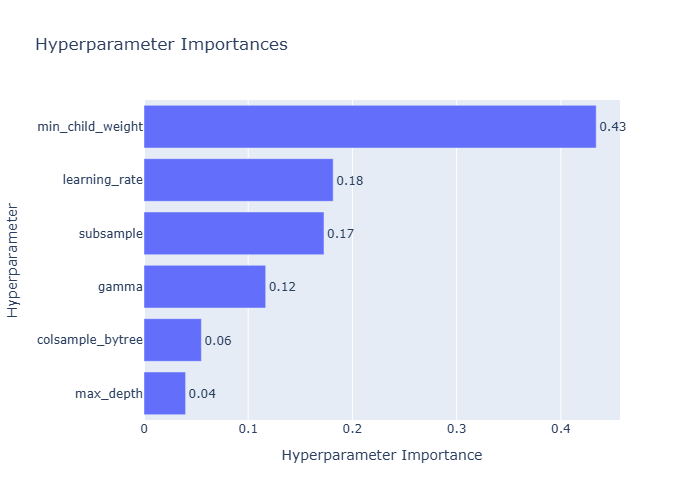

In [513]:
# Visualisation de l'importance de chaque hyperparamétre sur l'ensemble des tests.

optuna.visualization.plot_param_importances(study_xgb)

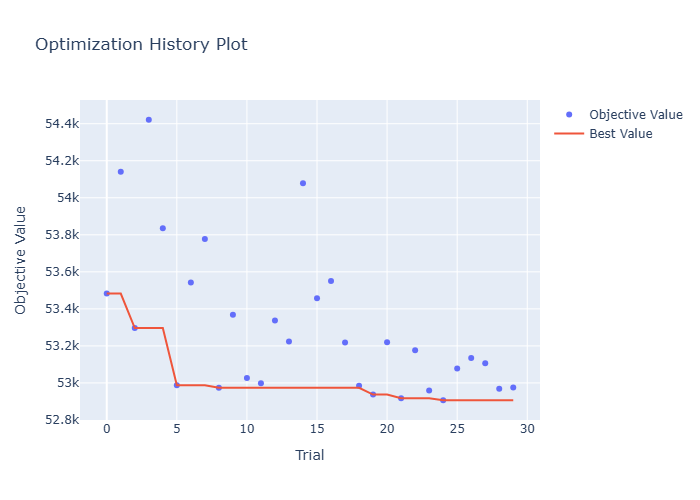

In [514]:
# Visualisation de l'historique de l'optimisation du modèle.

optuna.visualization.plot_optimization_history(study_xgb)

- Donc après ce deuxième essai d'optimisation des hyperparamètres on peut voir :

    - Le graphique de l'historique de l'optimisation du modèle montre de nouveau des gains importants dans les premiers essais puis après 5 essais cela stagne avec quelques améliorations marginales donc on peut dire que pour l'espace exploré ne contient plus de configurations significativement meilleures.

    - On obtient un graphique sur l'importance des hyperparamètres différent avec maintenant les paramètres régulateurs qui dominent et non plus la complexité avec **max_depth** (qui reste assez bas donc ce qui donne une structure plutôt simple). Donc Optuna converge vers une zone stable de l’espace des hyperparamètres, caractérisée par une forte régularisation  ce qui est une bonne chose.

    - Le seul hyperparamètre que l'on a fixé dans cette configuration est **n_estimators** pour faciliter la convergence des autres paramètres donc on peut tester de nouveau cette plage avec une **n** très grand et utiliser early stopping sur quelque essais pour vérifier si augmenter la capacité totale du modèle améliore les résultats (mais cela n'apportera sans doute pas grand chose car les essais converge souvent vers les mêmes valeurs et le modèle, on peut donc tester cela très rapidement).

    - Pour cela il y a un point à changer c'est la *métrique d'évaluation* utilisé puisque si **"binary_logloss"** est un bon choix pour cadrer le modèle puisque elle permet de pénalise fortement les erreurs et de récompenser les bonnes probabilités lorsque **n_estimator** très grand, cette métrique continue de s'améliorer petit à petit, ce qui empêche l'early stopping de faire effet (même quand le ranking est stable ou la séparation des classes est déjà optimale). A l'inverse, **l'AUC** qui mesure la capacité de discrimination du modèle est indépendant au seuil et au calibrage des probabilités donc il atteint un plateau beaucoup plus rapidement. Ce qui en fait la métrique idéal pour contrôler la *convergence* de n_estimators.

In [ ]:
def xgb_params_fn_final_check(trial):
    return {
        "n_estimators": 1500,
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.08),
        "max_depth": 3,
        "min_child_weight": trial.suggest_int("min_child_weight", 8, 15),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.9),
        "gamma": trial.suggest_float("gamma", 3, 5),
        "n_jobs": -1
    }

In [ ]:
# Dernière recherche pour déterminer l'impact de n_estimators sur les résultats

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(
    lambda trial: optuna_optimization_xgb(
        trial=trial,
        params_fn=xgb_params_fn_final_check,
        X_train=X_train_enc,
        y_train=y_train.values,
        n_splits=2,
        threshold=0.5,
        early_stopping_rounds=50
    ),
    n_trials=10
)

[I 2026-01-09 16:57:13,036] A new study created in memory with name: no-name-81b2aaa0-f8a1-431b-90a8-edeac35f831b
[I 2026-01-09 17:06:58,494] Trial 0 finished with value: 54473.0 and parameters: {'learning_rate': 0.06311515186995034, 'min_child_weight': 12, 'subsample': 0.7178494267162066, 'colsample_bytree': 0.8490447705050542, 'gamma': 4.948349060714829}. Best is trial 0 with value: 54473.0.
[I 2026-01-09 17:16:40,607] Trial 1 finished with value: 53920.0 and parameters: {'learning_rate': 0.054317320604937, 'min_child_weight': 8, 'subsample': 0.7418877798030502, 'colsample_bytree': 0.8201045061423065, 'gamma': 3.7926352887344112}. Best is trial 1 with value: 53920.0.
[I 2026-01-09 17:26:45,321] Trial 2 finished with value: 55178.5 and parameters: {'learning_rate': 0.07762946712790127, 'min_child_weight': 10, 'subsample': 0.7422802856694326, 'colsample_bytree': 0.8571301618658586, 'gamma': 3.530855112464174}. Best is trial 1 with value: 53920.0.
[I 2026-01-09 17:36:27,275] Trial 3 fin

In [518]:
# Résultats obtenus à chaque essai.

df_trials_final_check = study_xgb.trials_dataframe()
df_trials_final_check.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_min_child_weight,params_subsample,state
5,5,52941.5,2026-01-09 17:45:44.768430,2026-01-09 17:54:51.303882,0 days 00:09:06.535452,0.781700,4.224491,0.030226,15,0.833080,COMPLETE
9,9,53008.0,2026-01-09 18:23:50.845459,2026-01-09 18:33:14.794225,0 days 00:09:23.948766,0.848013,4.406019,0.031405,9,0.899066,COMPLETE
4,4,53295.0,2026-01-09 17:36:27.276641,2026-01-09 17:45:44.767428,0 days 00:09:17.490787,0.792104,3.311094,0.041083,12,0.775211,COMPLETE
1,1,53920.0,2026-01-09 17:06:58.494255,2026-01-09 17:16:40.607713,0 days 00:09:42.113458,0.820105,3.792635,0.054317,8,0.741888,COMPLETE
8,8,54087.0,2026-01-09 18:14:44.270240,2026-01-09 18:23:50.845459,0 days 00:09:06.575219,0.784395,4.393240,0.065040,14,0.888474,COMPLETE
3,3,54429.0,2026-01-09 17:26:45.321025,2026-01-09 17:36:27.275640,0 days 00:09:41.954615,0.848309,4.033543,0.065488,15,0.784919,COMPLETE
0,0,54473.0,2026-01-09 16:57:13.036669,2026-01-09 17:06:58.493254,0 days 00:09:45.456585,0.849045,4.948349,0.063115,12,0.717849,COMPLETE
6,6,54778.0,2026-01-09 17:54:51.304883,2026-01-09 18:04:46.932288,0 days 00:09:55.627405,0.858448,3.322022,0.068754,10,0.855760,COMPLETE
2,2,55178.5,2026-01-09 17:16:40.608712,2026-01-09 17:26:45.321025,0 days 00:10:04.712313,0.857130,3.530855,0.077629,10,0.742280,COMPLETE
7,7,55230.0,2026-01-09 18:04:46.934290,2026-01-09 18:14:44.269240,0 days 00:09:57.334950,0.872562,4.304705,0.079523,14,0.780789,COMPLETE


- Cette phase de vérification a été menée avec un nombre d’estimateurs élevé (2000), un early stopping et des plages resserrées. Les résultats montrent une forte *stabilité du coût métier* entre les essais, sans amélioration marginale significative du coût métier. Cela suggére que l’optimisation des hyperparamètres a convergé avant la limite imposée et que des essais supplémentaires n’apporteraient pas de gain substantiel (*Le nombre exact d’arbres retenus par l’early stopping n’a pas été sauvegardé lors des essais, ce qui empêche une analyse a posteriori fine de la convergence. Cette information sera intégrée dans les futures expérimentations*).

- Avec cette plage plus restreinte, on obtient des résultats similaires à précédemment, on a donc le bon *compromis entre performance et complexité* du modèle puisque XGBoost est très coûteux en terme de calcul (1h30 pour chaque study). 

- Pour s'assurer de la robustesse de ces configurations, on a bien utilisé la **CV** (avec n_splits=2 permettant de réduire le temps de calcul tout en conservant un signal suffisant pour l’optimisation des hyperparamètres) et on observe aucune amélioration significative en augmentant la capacité du modèle.

- En effet, dès la première phase d'exploration des hyperparamètres, Optuna a montré une *convergence rapide* vers une *région stable* de l’espace des hyperparamètres. Les gains observés sur les derniers essais sont marginaux lors de chaque phase de recherche, tandis que les paramètres sélectionnés privilégient une **forte régularisation** et une **faible complexité** du modèle.

- L’optimisation est donc arrêtée à ce stade et le modèle final sera évalué sur les jeux de validation et de test (*afin d'assurer une configuration robuste et stable, les hyperparamètres finaux seront choisis en fonction des meilleurs runs Optuna sur les phases 2 et 3*).

In [35]:
# Configuration finale retenue pour le modèle XGBoost.

final_xgb_params = {
    "n_estimators": 500,
    "learning_rate": 0.07,
    "max_depth": 3,
    "min_child_weight": 15,
    "gamma": 4.3,
    "subsample": 0.72,
    "colsample_bytree": 0.72,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "n_jobs": -1,
    "random_state": 42
}

In [ ]:
# Utilisation du pipeline XGBoost avec les hyperparamètres optimisés pour déterminer le seuil optimal.

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_xgboost_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                                  scale_pos_weight=scale_pos_weight, xgb_params=final_xgb_params)

mlflow.set_experiment("model_optimization")

with mlflow.start_run(run_name=f"model_optimization_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("scale_pos_weight", scale_pos_weight)

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_xgb = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_xgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/20 20:19:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpe114ji8a\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/20 20:19:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = 8f721cc7695d4de0a6a8ee9a866c127f


In [1212]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28251
2,0.03,28201
3,0.04,28089
4,0.05,27926
...,...,...
94,0.95,24744
95,0.96,24781
96,0.97,24810
97,0.98,24820


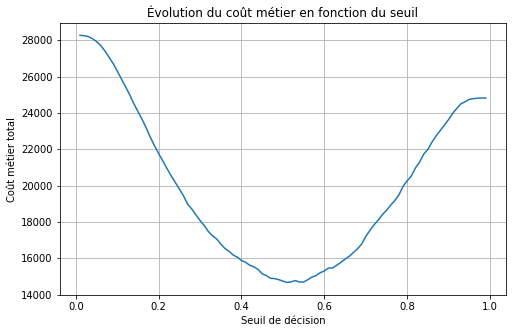

In [1213]:
# Visualisation des résultats obtenus

plt.figure(figsize=(8, 5))
plt.plot(cost_df["threshold"], cost_df["business_cost"])
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier total")
plt.title("Évolution du coût métier en fonction du seuil")
plt.grid(True)
plt.show()

In [1214]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_xgb_optimized = optimal_row["threshold"]
optimal_cost_xgb_optimized= optimal_row["business_cost"]

optimal_threshold_xgb_optimized, optimal_cost_xgb_optimized

(0.51, 14666.0)

In [1215]:
cost_05 = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= 0.5).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_opt = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= optimal_threshold_xgb_optimized).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_05, cost_opt

(14739, 14666)

- Pour l'optimisation du seuil, on est quasiment sur la même valeur que le seuil par défaut puisque l'on trouve de nouveau **0.51** avec cette nouvelle configuration de XGBoost.
- On peut donc l'appliquer de nouveau au split de validation pour obtenir nos résultats sur ce split puis on fera de même sur le jeu de test pour l'évaluation finale.

In [1216]:
# Récupération du modèle entrainé pour évaluer le split val avec le nouveau seuil.

RUN_ID = "8f721cc7695d4de0a6a8ee9a866c127f" 
model_uri = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_uri)

In [1217]:
# Utilisation du pipeline XGBoost avec les hyperparamètres optimisés + seuil optimisé sur le set de validation.


mlflow.set_experiment("model_optimization")

with mlflow.start_run(run_name=f"model_optimization_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "validation_evaluation")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("decision_threshold", optimal_threshold_xgb_optimized)
    mlflow.log_param("scale_pos_weight", scale_pos_weight)

    # Prédictions
    start_pred = time.time()
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]
    y_pred_val = (y_proba_val >= optimal_threshold_xgb_optimized).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_xgb = business_cost(
        y_true=y_val,
        y_pred=(y_proba_val >= optimal_threshold_xgb_optimized).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_xgb)
    
    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_xgb}")

2026/01/20 20:20:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpffylowin\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/20 20:20:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 14666



=== Baseline results for median_mode ===
Accuracy : 0.7396422764227643
F1-score : 0.3032201914708442
Precision : 0.1933836589698046
Recall : 0.701853344077357
AUC : 0.7920164280028602

Classification report :

              precision    recall  f1-score   support

           0      0.966     0.743     0.840     28268
           1      0.193     0.702     0.303      2482

    accuracy                          0.740     30750
   macro avg      0.580     0.722     0.572     30750
weighted avg      0.904     0.740     0.797     30750



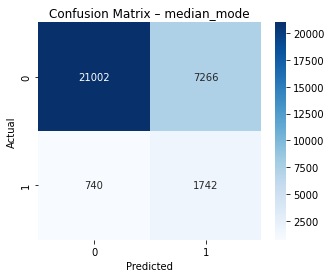

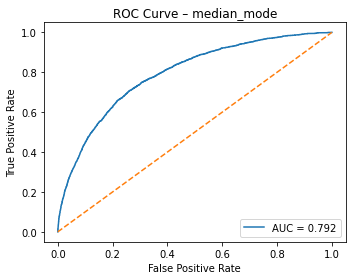

In [1218]:
# Affichage des résultats pour XGBoost sur le set de validation

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_val)
print("F1-score :", f1_val)
print("Precision :", precision_val)
print("Recall :", recall_val)
print("AUC :", auc_val)

print("\nClassification report :\n")
print(classification_report(y_val, y_pred_val, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_val, y_pred_val),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, y_proba_val)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [34]:
# Fonction pour sauvegarder les résultats de tous les modèles pour comparaison.

def final_evaluation_row(
    dataset_name,
    model_name,
    method_name,
    split,
    y_true,
    y_pred,
    y_proba,
    train_time,
    predict_time,
    business_cost,
    threshold=threshold
):

    return {
        "Dataset": dataset_name,
        "Model": model_name,
        "Method": method_name,
        "Split": split,
        "Accuracy ": accuracy_score(y_true, y_pred),
        "AUC ": roc_auc_score(y_true, y_proba),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "F1 Macro": f1_score(y_true, y_pred, average="macro"),
        "True Negatives": tn,
        "False Positives": fp,
        "False Negatives": fn,
        "True Positives": tp,
        "Train Time (s)": train_time,
        "Predict Time (s)": predict_time,
        "Decision Threshold": threshold,
        "Business_cost" : business_cost
    }

In [1219]:
# Sauvegarde des résultats pour XGBoost sur train_dfs["median_mode"]sur le split validation.

final_evaluation_xgb = []

final_evaluation_xgb.append(final_evaluation_row(
        dataset_name=df_name,
        model_name="XGBoost",
        method_name="OHE + scale_pos_weight",
        split= "Validation",
        y_true=y_val,
        y_pred=y_pred_val,
        y_proba=y_proba_val,
        train_time=train_time_xgb,
        predict_time=predict_time,
        business_cost=optimal_cost_xgb,
        threshold=optimal_threshold_xgb_optimized
    )
)

- Ensuite on passe à l'évaluation final sur le split de test :

In [1220]:
# Utilisation du pipeline XGBoost avec les hyperparamètres optimisés + seuil optimisé sur le set de test.

mlflow.set_experiment("model_optimization")

with mlflow.start_run(run_name=f"model_optimization_xgboost_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "XGBoost")
    mlflow.set_tag("execution_type", "test_evaluation")
    mlflow.set_tag("threshold_optimized", "yes")
    mlflow.log_param("decision_threshold", optimal_threshold_xgb_optimized)

    mlflow.log_param("scale_pos_weight", scale_pos_weight)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_xgb_optimized).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test= f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_xgb = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_xgb_optimized).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_xgb)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_xgb}")

2026/01/20 20:21:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Caomghin\AppData\Local\Temp\tmpqxktpsr3\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2026/01/20 20:21:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 29890



=== Baseline results for median_mode ===
Accuracy : 0.7400855270646006
F1-score : 0.29967141292442495
Precision : 0.19148936170212766
Recall : 0.6888217522658611
AUC : 0.7880414404296896

Classification report :

              precision    recall  f1-score   support

           0      0.965     0.745     0.840     56536
           1      0.191     0.689     0.300      4965

    accuracy                          0.740     61501
   macro avg      0.578     0.717     0.570     61501
weighted avg      0.902     0.740     0.797     61501



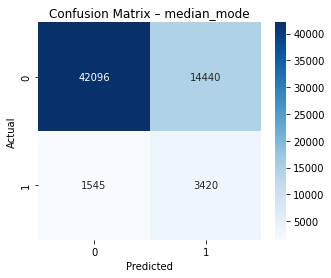

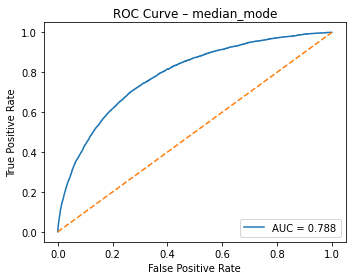

In [1221]:
# Affichage des résultats pour XGBoost sur train_dfs["median_mode"]

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [1222]:
# Sauvegarde des résultats pour XGBoost sur train_dfs["median_mode"] sur le split de test.

final_evaluation_xgb.append(final_evaluation_row(
        dataset_name=df_name,
        model_name="XGBoost",
        method_name="OHE + scale_pos_weight",
        split= "Test",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_xgb,
        predict_time=predict_time,
        business_cost=optimal_cost_xgb,
        threshold=optimal_threshold_xgb_optimized
    )
)

In [1223]:
final_evaluation_xgb_df = pd.DataFrame(final_evaluation_xgb)
final_evaluation_xgb_df

,Dataset,Model,Method,Split,Accuracy,AUC,Precision,Recall,F1,F1 Macro,True Negatives,False Positives,False Negatives,True Positives,Train Time (s),Predict Time (s),Decision Threshold,Business_cost
0,median_mode,XGBoost,OHE + scale_pos_weight,Validation,0.739642,0.792016,0.193384,0.701853,0.303220,0.571566,21002,7266,740,1742,111.150791,0.274979,0.51,14666
1,median_mode,XGBoost,OHE + scale_pos_weight,Test,0.740086,0.788041,0.191489,0.688822,0.299671,0.570052,42096,14440,1545,3420,111.150791,0.516498,0.51,29890


- Pour conclure, le modèle XGBoost avec les hyperparamètres optimisés, la pondération des classes et un seuil métier optimisé présente des performances stables entre validation et test, avec une amélioration du rappel, de l'AUC et une légère réduction du coût métier par rapport au modèle xgboost de la comparaison. On observe une capacité élevée à détecter les défauts (recall entre 0.68–0.70) et un compromis précision/rappel cohérent avec la fonction de coût définie.

- Il n'y a pas d’écart significatif entre les jeux de validation et de test ce qui indique une bonne capacité de généralisation. Pour cela, on a bien realisé l'entrainement sur le set *train* puis on a fait les prédictions sur les deux autre sets (val/test) pour évaluer les performances sur de nouvelles données.

- Bien que les gains globaux en termes de métriques classiques (Accuracy, AUC, F1) restent faibles par rapport à la phase de comparaison initiale, le modèle optimisé présente un comportement plus aligné avec les objectifs métier, en réduisant le nombre de faux négatifs au prix d’une augmentation contrôlée des faux positifs.

- Ainsi, XGBoost constitue une *solution robuste et cohérente* pour la suite du projet, notamment pour la comparaison avec LightGBM selon les mêmes critères métier.

#### - Optimisation des hyperparamètres du modèle LightGBM

- Ici contrairement à XGBoost, LightGBM gère nativement les variables catégorielles donc normalement donc on n'est pas obligé d'utiliser OHE mais on va le faire ici seulement pour pouvoir comparer avec XGBoost optimisé au dessus (et surtout on l'a utilisé pour les autres variables catégorielles lors du prétraitement mais pour celles restantes il était prévu d'utiliser une autre méthode car elles ont beaucoup de modalités ce qui n'est pas optimal avec OHE, c'est donc une optimisation à faire dans une version ultérieure du projet).

In [610]:
# Mise en place d'une fonction pour chercher les meilleurs hyperparamètres pour LGBM (OHE).

def optuna_optimization_lgbm(trial, params_fn, X_train, y_train, categorical_features, numerical_features,
                             n_splits=3, threshold=0.5, random_state=42,eval_metric="binary_logloss", 
                             early_stopping_rounds=100):


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    params = params_fn(trial)

    costs = []
    best_iterations = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_val_fold = y_train.iloc[val_idx]

        # Preprocessing pour chaque fold
        preprocessor = model_preprocessor(X_train_fold, categorical_features, numerical_features)

        X_train_enc = preprocessor.fit_transform(X_train_fold)
        X_val_enc = preprocessor.transform(X_val_fold)


        model = LGBMClassifier(
            **params,
            class_weight="balanced",
            random_state=random_state,
            force_col_wise=True,
            verbosity=-1,
            n_jobs=-1
        )

        # Entraînement
        model.fit(
            X_train_enc,
            y_train_fold,
            eval_set=[(X_val_enc, y_val_fold)],
            eval_metric=eval_metric,
            callbacks=[early_stopping(
                    stopping_rounds=early_stopping_rounds,
                    verbose=False
                )
            ]
        )

        best_iterations.append(model.best_iteration_)

        # Prédiction + seuil
        y_proba = model.predict_proba(X_val_enc)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        cost = business_cost(y_val_fold, y_pred)
        costs.append(cost)

        # Pruner
        trial.report(np.mean(costs), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    trial.set_user_attr("mean_best_iteration", int(np.mean(best_iterations)))
    trial.set_user_attr("std_best_iteration", float(np.std(best_iterations)))

    return np.mean(costs)

In [ ]:
def lgbm_params_fn(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "objective": "binary",
        "boosting_type": "gbdt"
    }

In [581]:
# Recherche de la meilleure combinaison d'hyperparamétres pour ce modèle.

pruner = optuna.pruners.MedianPruner(n_warmup_steps=1)
study_lgbm = optuna.create_study(direction="minimize", pruner=pruner)
study_lgbm.optimize(
    lambda trial: optuna_optimization_lgbm(
        trial=trial,
        params_fn=lgbm_params_fn,
        X_train=X_train,
        y_train=y_train,
        categorical_features=categorical_features,
        numerical_features=numerical_features,
        n_splits=3,
        threshold=0.5
    ),
    n_trials=30
)

[I 2026-01-13 01:44:30,211] A new study created in memory with name: no-name-e1a1a477-2668-4345-bd04-3cd192abff0d
[I 2026-01-13 01:45:51,966] Trial 0 finished with value: 42828.0 and parameters: {'n_estimators': 504, 'learning_rate': 0.07649975818142488, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 151, 'subsample': 0.6486730321055939, 'colsample_bytree': 0.8965146302141455, 'reg_alpha': 0.864872923586556, 'reg_lambda': 2.912703167481294}. Best is trial 0 with value: 42828.0.
[I 2026-01-13 01:46:52,646] Trial 1 finished with value: 41352.666666666664 and parameters: {'n_estimators': 486, 'learning_rate': 0.09925728711749271, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 159, 'subsample': 0.9740864754464104, 'colsample_bytree': 0.7279657421758747, 'reg_alpha': 6.393610027832296, 'reg_lambda': 2.3969365164988576}. Best is trial 1 with value: 41352.666666666664.
[I 2026-01-13 01:47:46,974] Trial 2 finished with value: 38458.0 and parameters: {'n_estimators': 482, 'lea

In [582]:
# Résultats obtenus à chaque essai.

df_trials = study_lgbm.trials_dataframe()
df_trials.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
25,25,35002.000000,2026-01-13 02:02:53.545421,2026-01-13 02:03:31.748143,0 days 00:00:38.202722,0.697830,0.036420,4,35,766,75,9.915279,8.733585,0.719073,COMPLETE
11,11,35026.000000,2026-01-13 01:54:41.016770,2026-01-13 01:55:19.064097,0 days 00:00:38.047327,0.632899,0.038687,4,22,792,43,7.310096,3.554080,0.886929,COMPLETE
18,18,35035.000000,2026-01-13 01:58:59.670153,2026-01-13 01:59:35.668924,0 days 00:00:35.998771,0.656383,0.041543,4,82,755,29,8.351556,5.932836,0.600316,COMPLETE
21,21,35047.000000,2026-01-13 02:00:28.041454,2026-01-13 02:01:03.899101,0 days 00:00:35.857647,0.654590,0.042658,4,36,764,24,9.973835,5.543036,0.828732,COMPLETE
12,12,35049.666667,2026-01-13 01:55:19.065099,2026-01-13 01:56:00.966844,0 days 00:00:41.901745,0.670390,0.045314,5,26,800,16,7.951412,2.359926,0.864664,COMPLETE
7,7,35065.666667,2026-01-13 01:52:20.300816,2026-01-13 01:52:58.721219,0 days 00:00:38.420403,0.611549,0.052966,12,109,630,16,6.123515,3.185505,0.904918,COMPLETE
20,20,35151.333333,2026-01-13 01:59:48.698128,2026-01-13 02:00:28.040452,0 days 00:00:39.342324,0.750717,0.059933,4,123,727,43,8.663718,6.962363,0.680948,COMPLETE
27,27,35153.333333,2026-01-13 02:03:52.064566,2026-01-13 02:04:27.750668,0 days 00:00:35.686102,0.624298,0.034838,4,72,675,97,8.425628,8.379949,0.665882,COMPLETE
22,22,35175.666667,2026-01-13 02:01:03.899101,2026-01-13 02:01:41.003062,0 days 00:00:37.103961,0.644355,0.035511,4,68,748,29,9.806637,5.647783,0.805055,COMPLETE
23,23,35224.333333,2026-01-13 02:01:41.003062,2026-01-13 02:02:24.256153,0 days 00:00:43.253091,0.639095,0.045985,6,42,658,26,8.630043,4.223375,0.812296,COMPLETE


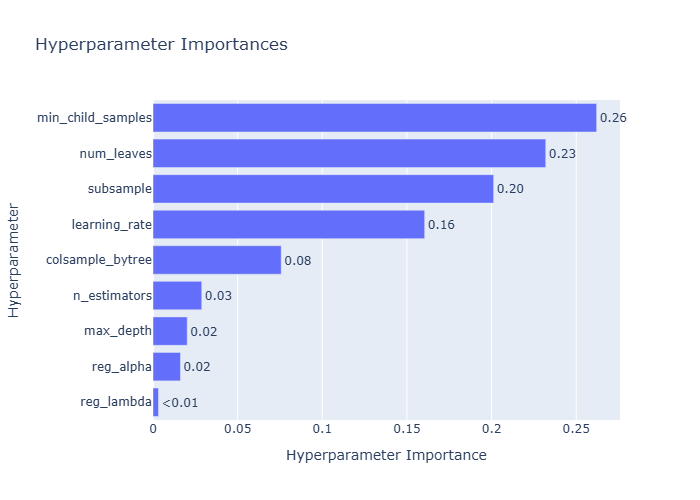

In [583]:
# Visualisation de l'importance de chaque hyperparamétre sur l'ensemble des tests.

optuna.visualization.plot_param_importances(study_lgbm)

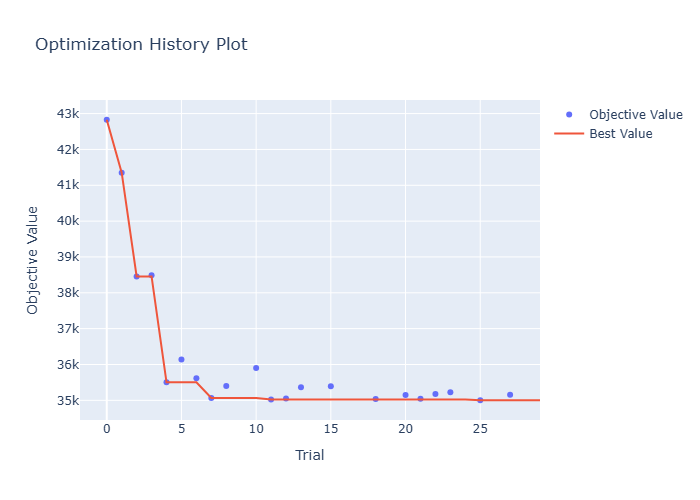

In [584]:
# Visualisation de l'historique de l'optimisation du modèle.

optuna.visualization.plot_optimization_history(study_lgbm)

- Pour cette première recherche de combinaison d'hyperparamètres, on a de nouveau pris une plage de valeur assez large comme pour XGboost en utilisant une validation croisée stratifiée à 3 folds (car beaucoup plus rapide) et la fonction de coût métier comme métrique d’optimisation.

- Les meilleurs essais convergent vers un coût moyen compris autour de **35 000**, avec une faible variabilité entre les configurations les plus performantes. Cette stabilité indique que le modèle a atteint un régime de performance robuste, compatible avec une phase de raffinement ciblée.

- **min_child_samples** et **num_leaves** sont les hyperparamètres les plus influents, indiquant que la régularisation structurelle des arbres joue un rôle clé.
- **subsample** et **learning_rate** ont également un impact significatif, soulignant l’importance du contrôle de la variance et de la dynamique d’apprentissage.
- À l’inverse, **n_estimators** et **max_depth**, ainsi que les paramètres de régularisation L1/L2 (**reg_alpha**, **reg_lambda**) ont un impact marginal dans la plage explorée.

- On peut donc passer à une seconde phase d’optimisation afin de resserrer les plages de recherche autour des zones les plus prometteuses, tout en figeant les hyperparamètres ayant montré un impact négligeable.

In [618]:
def lgbm_params_fn_refined(trial):
    return {
        "n_estimators": 750,
        "learning_rate": trial.suggest_float("learning_rate", 0.025, 0.055),
        "num_leaves": trial.suggest_int("num_leaves", 25, 90),
        "max_depth": trial.suggest_int("max_depth", 4, 6),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 70),
        "subsample": trial.suggest_float("subsample", 0.65, 0.85),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.65, 0.8),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "boosting_type": "gbdt",
    }

In [ ]:
# Tentative de tuning plus fin 

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
study_lgbm = optuna.create_study(direction="minimize", pruner=pruner)
study_lgbm.optimize(
    lambda trial: optuna_optimization_lgbm(
        trial=trial,
        params_fn=lgbm_params_fn_refined,
        X_train=X_train,
        y_train=y_train,
        categorical_features=categorical_features,
        numerical_features=numerical_features,
        n_splits=3,
        threshold=0.5
    ),
    n_trials=30
)

[I 2026-01-13 14:29:11,952] A new study created in memory with name: no-name-127c5426-e6a6-4001-9a4a-488364f09d12
[I 2026-01-13 14:29:53,088] Trial 0 finished with value: 35291.666666666664 and parameters: {'learning_rate': 0.0275425985120243, 'num_leaves': 41, 'max_depth': 4, 'min_child_samples': 67, 'subsample': 0.7524734344973955, 'colsample_bytree': 0.7227338156146788, 'reg_alpha': 1.6333045783914604, 'reg_lambda': 1.012119480988214}. Best is trial 0 with value: 35291.666666666664.
[I 2026-01-13 14:30:34,032] Trial 1 finished with value: 35887.666666666664 and parameters: {'learning_rate': 0.05435985313087382, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 52, 'subsample': 0.7003591424356869, 'colsample_bytree': 0.6610873483589461, 'reg_alpha': 0.19545360985197324, 'reg_lambda': 0.43881809462021204}. Best is trial 0 with value: 35291.666666666664.
[I 2026-01-13 14:31:21,293] Trial 2 finished with value: 35403.333333333336 and parameters: {'learning_rate': 0.0346561744503623

In [588]:
# Résultats obtenus à chaque essai.

df_trials_refined = study_lgbm.trials_dataframe()
df_trials_refined.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
21,21,35069.333333,2026-01-13 14:43:48.068041,2026-01-13 14:44:26.357211,0 days 00:00:38.289170,0.771392,0.039341,4,58,32,1.251925,1.979388,0.689497,COMPLETE
23,23,35109.333333,2026-01-13 14:45:03.178427,2026-01-13 14:45:39.499704,0 days 00:00:36.321277,0.742495,0.041446,4,69,31,1.274350,1.832461,0.690939,COMPLETE
27,27,35136.000000,2026-01-13 14:47:35.316060,2026-01-13 14:48:11.427235,0 days 00:00:36.111175,0.713326,0.043115,4,65,51,1.501076,1.989587,0.715483,COMPLETE
22,22,35141.666667,2026-01-13 14:44:26.358211,2026-01-13 14:45:03.178427,0 days 00:00:36.820216,0.760631,0.041465,4,64,31,1.276306,1.810117,0.688493,COMPLETE
24,24,35169.666667,2026-01-13 14:45:39.499704,2026-01-13 14:46:16.092610,0 days 00:00:36.592906,0.747170,0.041044,4,67,32,1.278843,1.855731,0.697228,COMPLETE
29,29,35194.000000,2026-01-13 14:48:53.245617,2026-01-13 14:49:29.947352,0 days 00:00:36.701735,0.711906,0.043642,4,55,65,1.914329,1.720083,0.754177,COMPLETE
26,26,35201.000000,2026-01-13 14:46:59.382595,2026-01-13 14:47:35.313547,0 days 00:00:35.930952,0.738035,0.043122,4,59,62,1.198634,1.479800,0.730201,COMPLETE
10,10,35223.000000,2026-01-13 14:36:28.085029,2026-01-13 14:37:05.808671,0 days 00:00:37.723642,0.797347,0.036985,4,35,25,0.548302,1.613092,0.661484,COMPLETE
8,8,35247.333333,2026-01-13 14:35:07.739575,2026-01-13 14:35:45.740364,0 days 00:00:38.000789,0.769365,0.029284,4,62,38,0.244927,1.601002,0.669422,COMPLETE
14,14,35255.666667,2026-01-13 14:39:01.479577,2026-01-13 14:39:38.781864,0 days 00:00:37.302287,0.772423,0.038966,4,57,32,1.062307,1.987344,0.689080,COMPLETE


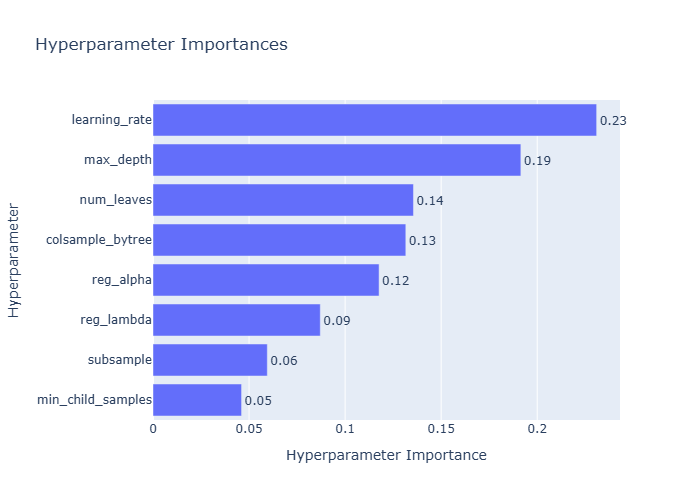

In [590]:
# Visualisation de l'importance de chaque hyperparamétre sur l'ensemble des tests.

optuna.visualization.plot_param_importances(study_lgbm)

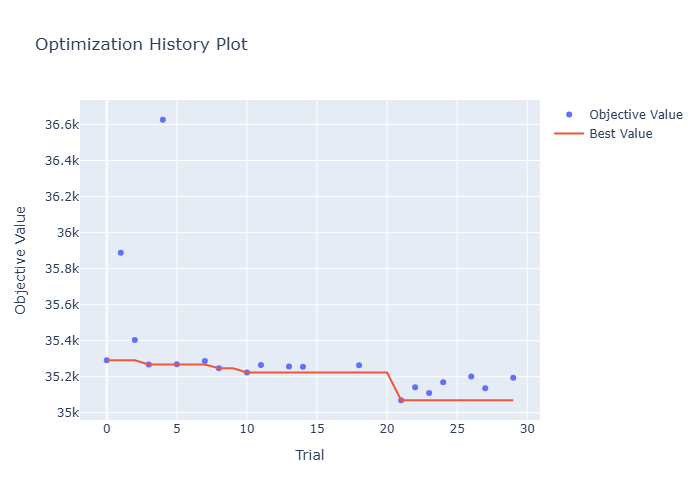

In [591]:
# Visualisation de l'historique de l'optimisation du modèle.

optuna.visualization.plot_optimization_history(study_lgbm)

- Cette deuxième phase de recherche visait à *affiner* les hyperparamètres les plus influents identifiés en en utilisant de nouveau la CV, des plages resserrées autour des zones prometteuses et un pruning moins agressif pour stabiliser les comparaisons.

- On peut observer que les meilleurs essais se concentrent dans une plage de performance similaire à précédemment aux alentours de **35 000** pour le coût moyen.

- Les performances sont *stables* entre les meilleurs trials, indiquant que le modèle a atteint un plateau de généralisation.

- L’écart entre les configurations est faible, ce qui suggère que le modèle est désormais peu sensible à de légères variations d’hyperparamètres.

- On obtient de nouveau un modèle peu complexe (souvent **max_depth = 4**) et fortement régularisés, limitant le surapprentissage (**num_leaves ≈ 25–35**  et **min_child_samples ≈ 55–70**) en comparaison avec XGBoost.

- La phase 2 permet d’identifier une configuration stable et robuste, avec des performances peu sensibles aux variations locales des hyperparamètres. Cependant comme pour xgboost, on va tout de même procéder à une dernière phase pour voir l'impact de n_estimators sur les performances du modèle (on attend pas de différence significative puisque *n_estimators* à une importance relativement faible dans la première phase de recherche).

In [617]:
def lgbm_params_fn_final_check(trial):
    return {
        "n_estimators": 1500,
        "learning_rate": trial.suggest_float("learning_rate", 0.025, 0.055),
        "num_leaves": trial.suggest_int("num_leaves", 25, 90),
        "max_depth": trial.suggest_int("max_depth", 4, 6),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 70),
        "subsample": trial.suggest_float("subsample", 0.65, 0.85),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.65, 0.8),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 2.0),
        "boosting_type": "gbdt",
    }

In [ ]:
# Dernière recherche pour déterminer l'impact de n_estimators

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
study_lgbm = optuna.create_study(direction="minimize", pruner=pruner)
study_lgbm.optimize(
    lambda trial: optuna_optimization_lgbm(
        trial=trial,
        params_fn=lgbm_params_fn_refined,
        X_train=X_train,
        y_train=y_train,
        categorical_features=categorical_features,
        numerical_features=numerical_features,
        n_splits=3,
        threshold=0.5,
        eval_metric="auc",
        early_stopping_rounds=50
    ),
    n_trials=20
)

[I 2026-01-15 00:10:28,941] A new study created in memory with name: no-name-d8b1c277-27d2-4bed-856f-754c57c8cf80


[I 2026-01-15 00:11:20,599] Trial 0 finished with value: 35235.666666666664 and parameters: {'learning_rate': 0.03741283578399053, 'num_leaves': 58, 'max_depth': 5, 'min_child_samples': 48, 'subsample': 0.7127206389683471, 'colsample_bytree': 0.720319961091207, 'reg_alpha': 1.8324234736923104, 'reg_lambda': 1.3672023454781843}. Best is trial 0 with value: 35235.666666666664.
[I 2026-01-15 00:12:06,546] Trial 1 finished with value: 35288.666666666664 and parameters: {'learning_rate': 0.03700785172942912, 'num_leaves': 25, 'max_depth': 4, 'min_child_samples': 53, 'subsample': 0.8233426637635107, 'colsample_bytree': 0.7422016073810296, 'reg_alpha': 0.8059950455343323, 'reg_lambda': 0.019757558459892133}. Best is trial 0 with value: 35235.666666666664.
[I 2026-01-15 00:12:48,433] Trial 2 finished with value: 35420.666666666664 and parameters: {'learning_rate': 0.04476624330151361, 'num_leaves': 40, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.7637307892553027, 'colsample_bytree'

In [620]:
# Résultats obtenus à chaque essai.

df_trials = study_lgbm.trials_dataframe()
df_trials.sort_values(by=["value"])

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,user_attrs_mean_best_iteration,user_attrs_std_best_iteration,state
14,14,35087.333333,2026-01-15 00:20:26.553456,2026-01-15 00:21:05.566965,0 days 00:00:39.013509,0.659450,0.051095,4,70,78,0.379409,0.352501,0.651498,617.0,68.363408,COMPLETE
6,6,35144.000000,2026-01-15 00:15:02.737953,2026-01-15 00:15:41.095717,0 days 00:00:38.357764,0.673544,0.053439,4,66,79,0.161464,0.615812,0.655968,558.0,31.116269,COMPLETE
11,11,35144.333333,2026-01-15 00:18:24.257420,2026-01-15 00:19:07.620008,0 days 00:00:43.362588,0.796627,0.051906,4,70,89,1.282758,0.088484,0.656454,662.0,47.394327,COMPLETE
12,12,35146.333333,2026-01-15 00:19:07.621008,2026-01-15 00:19:47.136394,0 days 00:00:39.515386,0.761138,0.054628,4,62,78,1.494676,0.280845,0.651833,601.0,111.359278,COMPLETE
3,3,35160.000000,2026-01-15 00:12:48.433854,2026-01-15 00:13:34.420473,0 days 00:00:45.986619,0.795940,0.046084,4,69,85,0.867211,0.168431,0.678812,685.0,17.249799,COMPLETE
4,4,35229.666667,2026-01-15 00:13:34.421508,2026-01-15 00:14:21.412770,0 days 00:00:46.991262,0.672580,0.030330,5,21,71,1.079667,0.596396,0.733118,558.0,17.962925,COMPLETE
18,18,35231.666667,2026-01-15 00:23:02.702986,2026-01-15 00:23:45.164105,0 days 00:00:42.461119,0.703773,0.034178,4,40,65,0.524127,0.844422,0.669614,NaN,NaN,PRUNED
0,0,35235.666667,2026-01-15 00:10:28.951952,2026-01-15 00:11:20.599469,0 days 00:00:51.647517,0.720320,0.037413,5,48,58,1.832423,1.367202,0.712721,518.0,61.030047,COMPLETE
16,16,35238.333333,2026-01-15 00:21:43.037132,2026-01-15 00:22:26.846463,0 days 00:00:43.809331,0.669704,0.027070,4,63,77,0.366485,0.900381,0.729399,NaN,NaN,PRUNED
13,13,35239.000000,2026-01-15 00:19:47.137395,2026-01-15 00:20:26.548721,0 days 00:00:39.411326,0.723799,0.050250,4,60,58,1.229571,0.978905,0.763352,NaN,NaN,PRUNED


- Globalement, on constate de nouveau des performances similaires que prédédemment aux alentours des 35 000 pour le coût métier.
- On peut voir que le modèle n'exploite pas les 1500 arbres que l'on a fixé comme maximum en effet, on observe que la valeur oscille entre **450 et 750** donc augmenter la capacité du modèle ne crée pas de gains significatif.
- Cela permet de dire que le modèle est stable et qu'il n'y a aucun intérêt à augmenter n_estimators donc on peut maintenant passer à l'optimisation finale en fixant une configuration en fonction des résultats obtenus des phases de recherche (on fixera **n_estimators = 800** pour avoir une marge de sécurité raisonnable sans que cela entraine un surcoût inutile ou un temps d'entrainement trop long)

In [37]:
# Configuration finale retenue pour le modèle LGBM.

final_lgbm_params = {
    "n_estimators": 800,
    "learning_rate": 0.04,
    "num_leaves": 65,
    "max_depth": 4,
    "min_child_samples": 65,
    "subsample": 0.70,
    "colsample_bytree": 0.70,
    "reg_alpha": 0.5,
    "reg_lambda": 0.8,
    "boosting_type": "gbdt",
    "n_jobs": -1,
    "verbosity": -1,
    "force_col_wise": True
}

In [ ]:
# Utilisation du pipeline LGBM avec les hyperparamètres optimisés pour déterminer le seuil.

df_name = "median_mode"
df = train_dfs[df_name].drop(columns=["SK_ID_CURR"])

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(df, target_col="TARGET")

categorical_features = ["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]
numerical_features = [col for col in df.columns if col not in categorical_features + ["TARGET"]]

pipeline = build_lgbm_pipeline(categorical_features=categorical_features, numerical_features=numerical_features,
                               lgbm_params=final_lgbm_params)

mlflow.set_experiment("model_optimization")

with mlflow.start_run(run_name=f"model_optimization_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "business_cost_optimization")
    mlflow.set_tag("cost_definition", "FP=1_FN=10")
    mlflow.set_tag("threshold_optimized", "no") 

    mlflow.log_param("class_weight", "balanced")

    # Entraînement
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time_lgbm = time.time() - start_time

    # Prédictions
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("train_time_sec", train_time_lgbm)

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    run_id = mlflow.active_run().info.run_id
    print("RUN ID =", run_id)

2026/01/29 23:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN ID = 6c2445ea431c48758f8140aa48664f22


In [20]:
# Calcul du coût métier à différents seuils de décision.

cost_df = evaluate_business_cost_by_threshold(y_true=y_val, y_proba=y_proba_val, cost_fp=1, cost_fn=10)
cost_df

,threshold,business_cost
0,0.01,28268
1,0.02,28250
2,0.03,28185
3,0.04,28062
4,0.05,27891
...,...,...
94,0.95,24704
95,0.96,24780
96,0.97,24810
97,0.98,24820


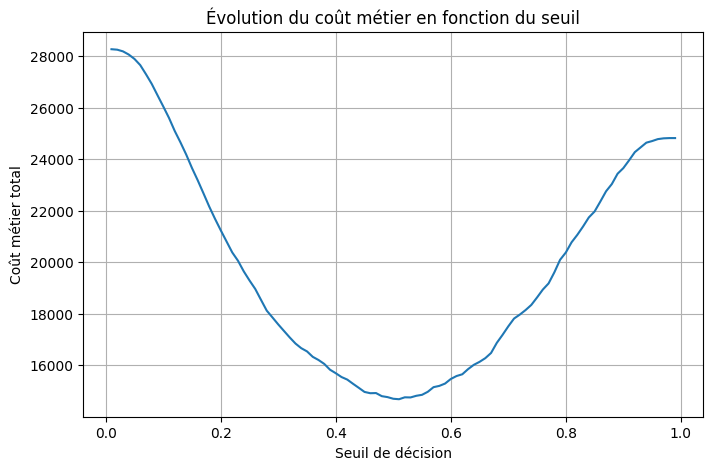

In [21]:
# Visualisation des résultats obtenus

plt.figure(figsize=(8, 5))
plt.plot(cost_df["threshold"], cost_df["business_cost"])
plt.xlabel("Seuil de décision")
plt.ylabel("Coût métier total")
plt.title("Évolution du coût métier en fonction du seuil")
plt.grid(True)
plt.show()

In [22]:
optimal_row = cost_df.loc[cost_df["business_cost"].idxmin()]
optimal_threshold_lgbm = optimal_row["threshold"]
optimal_cost_lgbm = optimal_row["business_cost"]

optimal_threshold_lgbm, optimal_cost_lgbm

(0.51, 14687.0)

In [23]:
cost_05 = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= 0.5).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_opt = business_cost(
    y_true=y_val,
    y_pred=(y_proba_val >= optimal_threshold_lgbm).astype(int),
    cost_fp=1,
    cost_fn=10
)

cost_05, cost_opt

(14705, 14687)

In [24]:
# Récupération du modèle entrainé pour évaluer le split test avec le nouveau seuil.

RUN_ID = "6c2445ea431c48758f8140aa48664f22" 
model_lgbm = f"runs:/{RUN_ID}/model"
pipeline = mlflow.sklearn.load_model(model_lgbm)

In [25]:
# Utilisation du pipeline LGBM avec les hyperparamètres optimisés + seuil optimisé sur le set de validation.


mlflow.set_experiment("model_optimization")

with mlflow.start_run(run_name=f"model_optimization_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "validation_evaluation")
    mlflow.set_tag("threshold_optimized", "yes") 

    mlflow.log_param("decision_threshold", optimal_threshold_lgbm)
    mlflow.log_param("class_weight", "balanced")


    # Prédictions
    start_pred = time.time()
    y_pred_val = pipeline.predict(X_val)
    y_proba_val = pipeline.predict_proba(X_val)[:, 1]
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val= f1_score(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_proba_val)
    precision_val = precision_score(y_val, y_pred_val, pos_label=1)
    recall_val = recall_score(y_val, y_pred_val, pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_val", acc_val)
    mlflow.log_metric("f1_val", f1_val)
    mlflow.log_metric("auc_val", auc_val)
    mlflow.log_metric("precision_val", precision_val)
    mlflow.log_metric("recall_val", recall_val)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_lgbm = business_cost(
        y_true=y_val,
        y_pred=(y_proba_val >= optimal_threshold_lgbm).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_lgbm) 

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_val, y_proba_val)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_lgbm}")

2026/01/29 23:26:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 14687



=== Baseline results for median_mode ===
Accuracy : 0.7418861788617886
F1-score : 0.30358866368342546
Precision : 0.19405496354458776
Recall : 0.6970185334407736
AUC : 0.7921480392517937

Classification report :

              precision    recall  f1-score   support

           0      0.966     0.746     0.842     28268
           1      0.194     0.697     0.304      2482

    accuracy                          0.742     30750
   macro avg      0.580     0.721     0.573     30750
weighted avg      0.903     0.742     0.798     30750



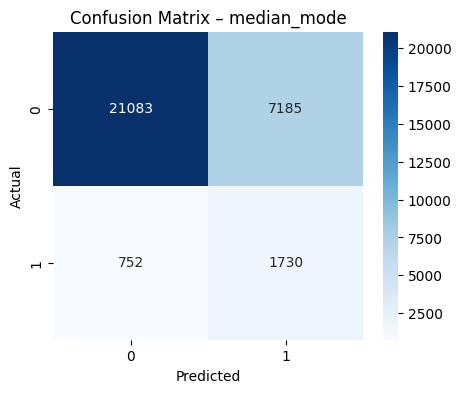

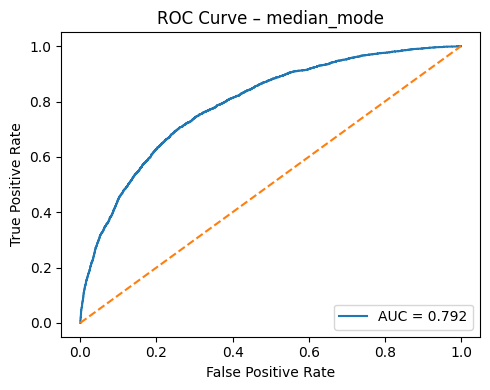

In [26]:
# Affichage des résultats pour LGBM sur le set de validation

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_val)
print("F1-score :", f1_val)
print("Precision :", precision_val)
print("Recall :", recall_val)
print("AUC :", auc_val)

print("\nClassification report :\n")
print(classification_report(y_val, y_pred_val, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_val, y_pred_val),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, y_proba_val)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [35]:
# Sauvegarde des résultats pour LGBM sur train_dfs["median_mode"]sur le split validation.

final_evaluation_lgbm = []

final_evaluation_lgbm.append(final_evaluation_row(
        dataset_name=df_name,
        model_name="LGBM",
        method_name="OHE + class_weight",
        split= "Validation",
        y_true=y_val,
        y_pred=y_pred_val,
        y_proba=y_proba_val,
        train_time=train_time_lgbm,
        predict_time=predict_time,
        business_cost=optimal_cost_lgbm,
        threshold=optimal_threshold_lgbm
    )
)

- Ensuite on fait la même chose avec le split de test.

In [27]:
# Utilisation du pipeline LGBM avec les hyperparamètres optimisés + seuil optimisé sur le set de test.


mlflow.set_experiment("model_optimization")

with mlflow.start_run(run_name=f"model_optimization_lgbm_ohe_{df_name}"):

    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("execution_type", "test_evaluation")
    mlflow.set_tag("threshold_optimized", "yes")

    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("decision_threshold", optimal_threshold_lgbm)


    # Prédictions
    start_pred = time.time()
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= optimal_threshold_lgbm).astype(int)
    predict_time = time.time() - start_pred

    # Calcul des métriques
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    auc_test = roc_auc_score(y_test, y_proba_test)
    precision_test = precision_score(y_test, y_pred_test, pos_label=1)
    recall_test = recall_score(y_test, y_pred_test, pos_label=1)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Log des métriques
    mlflow.log_metric("accuracy_test", acc_test)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("auc_test", auc_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("predict_time_sec", predict_time)

    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Calcul du coût métier global avec le seuil optimal.
    optimal_cost_lgbm = business_cost(
        y_true=y_test,
        y_pred=(y_proba_test >= optimal_threshold_lgbm).astype(int),
        cost_fp=1,
        cost_fn=10
    )

    mlflow.log_metric("business_cost_test", optimal_cost_lgbm)    

    # Log du modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    # Log de la matrice de confusion comme artifact
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Courbe ROC
    fpr, tpr, threshold = roc_curve(y_test, y_proba_test)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

print(f"Le coût métier global au seuil optimal est de {optimal_cost_lgbm}")

2026/01/29 23:27:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Le coût métier global au seuil optimal est de 29848



=== Baseline results for median_mode ===
Accuracy : 0.7532072649225215
F1-score : 0.3052911021603808
Precision : 0.19753598294142036
Recall : 0.6717019133937563
AUC : 0.7908050032126683

Classification report :

              precision    recall  f1-score   support

           0      0.963     0.760     0.850     56536
           1      0.198     0.672     0.305      4965

    accuracy                          0.753     61501
   macro avg      0.581     0.716     0.578     61501
weighted avg      0.902     0.753     0.806     61501



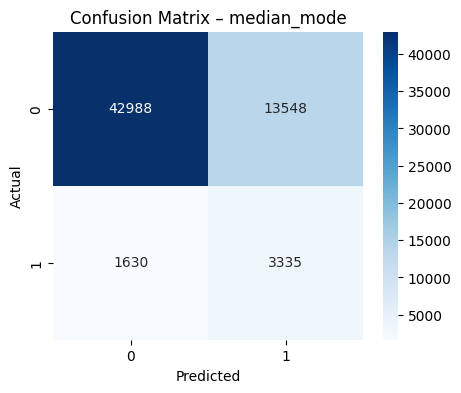

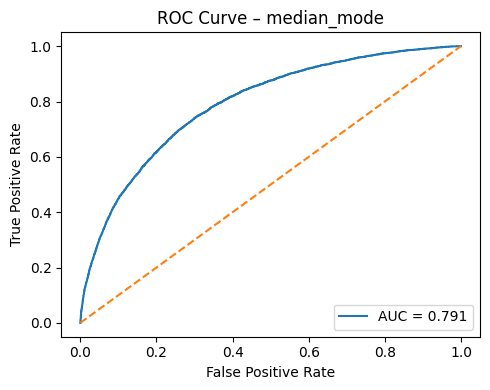

In [28]:
# Affichage des résultats pour LGBM sur le set de test.

print(f"\n=== Baseline results for {df_name} ===")

print("Accuracy :", acc_test)
print("F1-score :", f1_test)
print("Precision :", precision_test)
print("Recall :", recall_test)
print("AUC :", auc_test)

print("\nClassification report :\n")
print(classification_report(y_test, y_pred_test, digits=3))

plt.figure(figsize=(5,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title(f"Confusion Matrix – {df_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve – {df_name}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [38]:
# Sauvegarde des résultats pour LGBM sur train_dfs["median_mode"]sur le split de test.


final_evaluation_lgbm.append(final_evaluation_row(
        dataset_name=df_name,
        model_name="LGBM",
        method_name="OHE + class_weight",
        split= "Test",
        y_true=y_test,
        y_pred=y_pred_test,
        y_proba=y_proba_test,
        train_time=train_time_lgbm,
        predict_time=predict_time,
        business_cost=optimal_cost_lgbm,
        threshold=optimal_threshold_lgbm
    )
)

In [1073]:
final_evaluation_lgbm_df = pd.DataFrame(final_evaluation_lgbm)
final_evaluation_lgbm_df

,Dataset,Model,Method,Split,Accuracy,AUC,Precision,Recall,F1,F1 Macro,True Negatives,False Positives,False Negatives,True Positives,Train Time (s),Predict Time (s),Decision Threshold,Business_cost
0,median_mode,LGBM,OHE + class_weight,Validation,0.741886,0.792148,0.194055,0.697019,0.303589,0.572587,21083,7185,752,1730,15.609265,0.650592,0.51,14687
1,median_mode,LGBM,OHE + class_weight,Test,0.753207,0.790805,0.197536,0.671702,0.305291,0.577621,42988,13548,1630,3335,15.609265,0.582530,0.51,29848


- Globalement les performances obtenues avec LGBM sont assez similaires à XGBoost.
- Lorsque l'on regarde les métriques des deux jeux de données (val/test), il n'y a pas d'écart significatif donc la configuration choisie permet au modèle de bien généraliser sans sur-apprentissage ou sous-apprentissage.
- On peut ainsi passer à une rapide comparaison entre les deux modèles avec leurs hyperparamètres optimisés:

In [1224]:
# Concaténation des deux dataframes des résultats.

final_evaluation_comparison = pd.concat(
    [final_evaluation_xgb_df.tail(1), final_evaluation_lgbm_df.tail(1)],
    ignore_index=True
)

final_evaluation_comparison

,Dataset,Model,Method,Split,Accuracy,AUC,Precision,Recall,F1,F1 Macro,True Negatives,False Positives,False Negatives,True Positives,Train Time (s),Predict Time (s),Decision Threshold,Business_cost
0,median_mode,XGBoost,OHE + scale_pos_weight,Test,0.740086,0.788041,0.191489,0.688822,0.299671,0.570052,42096,14440,1545,3420,111.150791,0.516498,0.51,29890
1,median_mode,LGBM,OHE + class_weight,Test,0.753207,0.790805,0.197536,0.671702,0.305291,0.577621,42988,13548,1630,3335,15.609265,0.582530,0.51,29848


- Pour cette optimisation des hyperparamètres, les deux modèles ont travaillé sur le même dataset, ont utilisé le même type d'encodage (OHE) et une solution contre le déséquilibre des classes qui est la plus adapté à leur fonctionnement.

- Pour ce qui est de notre principale métrique, le coût métier global, LGBM est légérement meilleur ici 
(-42 points soit **0.14 %** meilleur) avec les configurations obtenus (en rappelant que l'on a fait des configuration en regardant les meilleurs essais et non le meilleur pour la robustesse et stabilité des modèles). 
- Pour ce qui des métriques techniques, LGBM est légérement supérieur pour l'AUC, l'accuracy, la précision et le F1 score mais le Recall est légérement meilleur pour XGBoost (donc XGB attrape plus de positif comme on peut le voir **3420** contre **3335** pour LGBM mais cela se fait au détriment de la classe négative).

- Dans l'ensemble, les écarts de performances sont *très faible* et les deux modèles sont quasiment *équivalent* au niveau du coût métier malgré le meilleur recall de XGB, ce qui est dû aux coûts fixés lors de la définition de la fonction métier(en effet, si l'on juge plus coûteux les FN par exemple à 20 au lieu de 10 cela changerai le coût global avec les mêmes prédictions on aurait 45 340 pour XGB et 46 148 pour LGBM même si, dans les faits on optimiserai de nouveau nos modèles avec la nouvelle fonction ce qui serait sans doute encore différent).

- En plus des résultats que l'on peut observer ici, il y a d'autres éléments à prendre en compte lorsque l'on a des performances aussi proches en effet, dans le cadre d'un projet d'entreprise il faut prendre en compte ici que LGBM est beaucoup **plus rapide** à entrainer que XGB (environ 7X plus rapide donc accélére la R&D, les itérations, tests, MLOps...). Le time-to-production est meilleur donc moins de retards ou coûts, le modèle est plus facile à monitorer (plus facile de surveiller les performances, dérives, taux d'erreur) et CPU friendly pour un service continu comme c'est l'objectif ici (coût par requête plus faible et déploiment plus simple). Donc en prenant en compte ces éléments complémentaires même si XGB était légérement meilleur, le choix **LGBM** comme **candidat final** pour industrialisation serait sans doute le plus judicieux.

- On retiendra donc **LGBM** qui constitue une base solide et performante après tuning des hyperparamètres et optimisation du seuil. Cependant même si on s'arrêtera ici dans l'optimisation du modèle (car temps limité pour la réalisation du projet), il reste plusieurs optimisations possible pour améliorer les résultats actuels.
- En effet, il est possible de tester d'autres *méthodes d'imputation* qui pourrait être plus efficace (exemple avec les imputations à l'aide de modèle tel que KNN, XGB imputer etc..) ou encore un *encodage plus avancé* (comme Target Encoding, Catboost Encoding, voir pas d'encodage pour LGBM qui peut gérer les variables catégorielles) et de manière général d'étoffer le *feature engineering* (embedding, features basées sur des statistiques par groupe, d'autre intéractions entre les features...). Il est aussi possible d'explorer d'autres configuration de la *fonction coût métier* qui n'est peut être pas la plus optimal possible (selon le contexte, les enjeux, une segmentation client, il est possible d'avoir des coût différents mais il faut plus d'informations). Ou encore d'aller plus loin dans la configuration du modèle (il existe une multitude d'hyperparamètres pouvant être optimisé). (*Toutes ces possibilités n'ont pas été testées par manque de temps mais pourront être mises en place dans une version ultérieure*).
- Pour finir, on peut s'intéresser d'un peu plus près à *l'importance des variables* dans les prédictions réalisées par le modèle retenu.

In [54]:
# Export du modèle final à l'aide de MLFlow pour l'API de prédiction.

mlflow.set_experiment("production_model")

with mlflow.start_run(run_name="model_final_export"):

    # Tags
    mlflow.set_tag("stage", "production")
    mlflow.set_tag("model", "LGBM")
    mlflow.set_tag("dataset", df_name)
    mlflow.set_tag("pipeline", "OHE + passthrough")

    # Paramètres clés
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("decision_threshold", optimal_threshold_lgbm)

    # Hyperparametres
    mlflow.log_params(final_lgbm_params)

    # Modèle
    mlflow.sklearn.log_model(pipeline, artifact_path="model")

    print("RUN_ID =", mlflow.active_run().info.run_id)

2026/02/03 01:47:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RUN_ID = 8497d15aff2a489fb62e0990e29c301d


### Importance des variables (SHAP)

- Dans cette partie, on cherche a comprendre quelles variables pilotent les prédictions du modèle, et comment elles influencent la décision pour un client donné.

- Pour cela, nous utilisons **SHAP** (SHapley Additive exPlanations), une *méthode d’explicabilité* des modèles de machine learning qui décompose chaque prédiction en une somme de contributions des variables (à l'aide des valeurs de Shapley de la théorie des jeux mesure la contribution “juste” d’une variable à la prédiction). Ces contributions ont des propriétés théoriques intéressantes (additivité, cohérence) qui rendent l’explication plus fiable que de simples importances « gain » ou « Gini ». Pour les modèles de type arbres (comme LightGBM ici), l’algorithme *TreeExplainer* permet de calculer les valeurs SHAP de manière efficace.

- Dans notre contexte métier cette étape est essentielle pour plusieurs raisons :

    - Répondre aux exigences métier et d’interprétabilité (justifier pourquoi un crédit est accepté/refusé)
    - Identifier les variables clés du risque afin d’alimenter le métier (profil type des bons / mauvais payeurs)
    - Détecter d’éventuels effets indésirables (features instables, variables redondantes, comportements contre-intuitifs, etc.)

- On commencera donc avec par analyser l'importance globale des variables puis au niveau local pour différencier par exemple un client à risque d'un client sans risque (cette double analyse (globale + locale) permet à la fois de valider le comportement général du modèle et de justifier des décisions individuelles) :

#### Importance globale des variables de LGBM.

In [ ]:
# Récupération du modèle, des entrées transformées et exploitable et calcul des valeurs SHAP

# Récupéreration preprocessor + modèle depuis le pipeline
preprocessor = pipeline.named_steps["preprocessing"]  
model = pipeline.named_steps["classifier"]

# Transformer le jeu de test
X_test_enc = preprocessor.transform(X_test)

# 3) Récupérer les noms de features après OHE
feature_names = preprocessor.get_feature_names_out()

# 4) Construire un DataFrame (pratique pour les plots SHAP)
X_test_enc_df = pd.DataFrame(
    X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc,
    columns=feature_names
)

# 5) SHAP TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_enc_df)

# Selon versions: shap_values peut être list (2 classes) ou array
if isinstance(shap_values, list):
    # on prend la classe positive (1)
    shap_values_pos = shap_values[1]
else:
    shap_values_pos = shap_values

# base value
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[1]

print("Shapes => X:", X_test_enc_df.shape, "| SHAP:", shap_values_pos.shape)

Shapes => X: (61501, 670) | SHAP: (61501, 670)


c:\Users\Caomghin\miniforge3\envs\projet_7_DS\lib\site-packages\shap\explainers\_tree.py:583: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



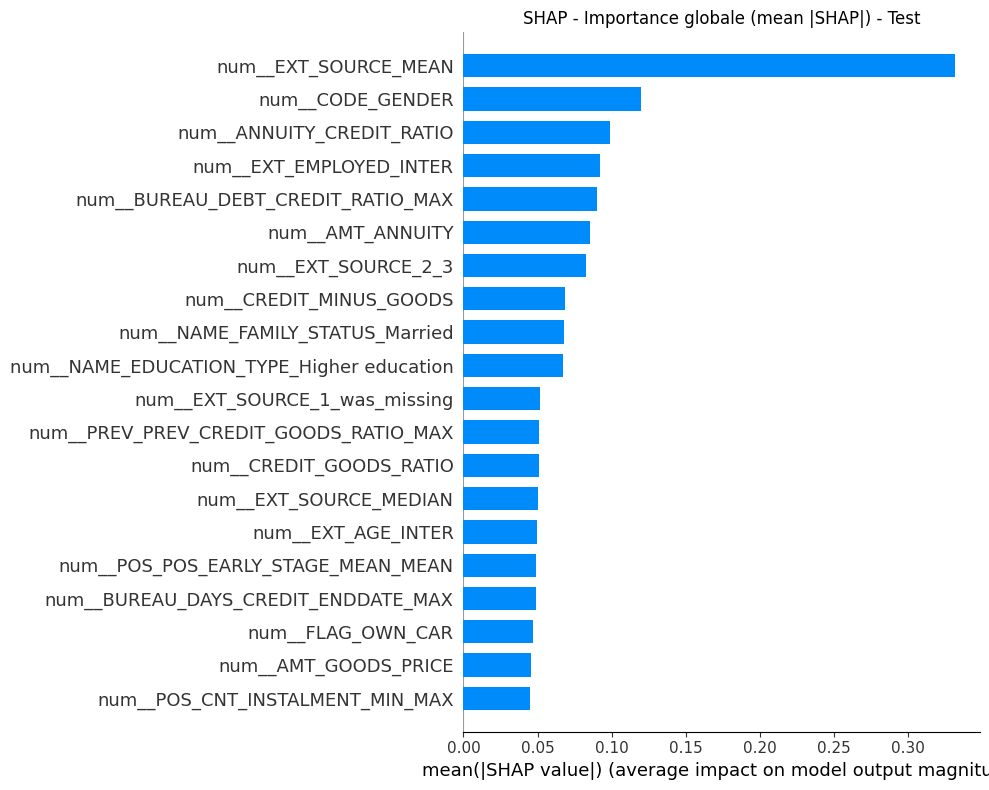

In [ ]:
# Visualisation de l'importance au niveau global (modèle).


shap.summary_plot(shap_values_pos, X_test_enc_df, plot_type="bar", 
                  max_display=20, plot_size=(10, 8), show=False)
plt.title("SHAP - Importance globale (mean |SHAP|) - Test")
plt.tight_layout()
plt.show()

- Donc ici pour le premier graphique, on retrouve quelles variables ont, en *moyenne*, le plus d’impact sur la prédiction (indépendamment du sens positif/négatif).
- Donc pour notre modèle LGBM, **EXT_SOURCE_MEAN** domine très largement puisque la shap value est plus de 2 fois plus impactant par rapport à la deuxième variable, c’est donc le facteur le plus déterminant du score de crédit. Pour les variables qui suivent comme **CODE_GENDER**, **ANNUITY_CREDIT_RATIO**, **EXT_EMPLOYED_INTER** et **BUREAU_DEBT_CREDIT_RATIO_MAX**, on observe une forte présence de ratios financiers et de variables de comportement crédit, ce qui est cohérent avec un modèle de scoring.
- Donc globalement le modèle s’appuie principalement sur la qualité du score externe, la capacité de remboursement (annuité / crédit), l’historique bureau et des signaux socio-démographiques (de manière secondaire).

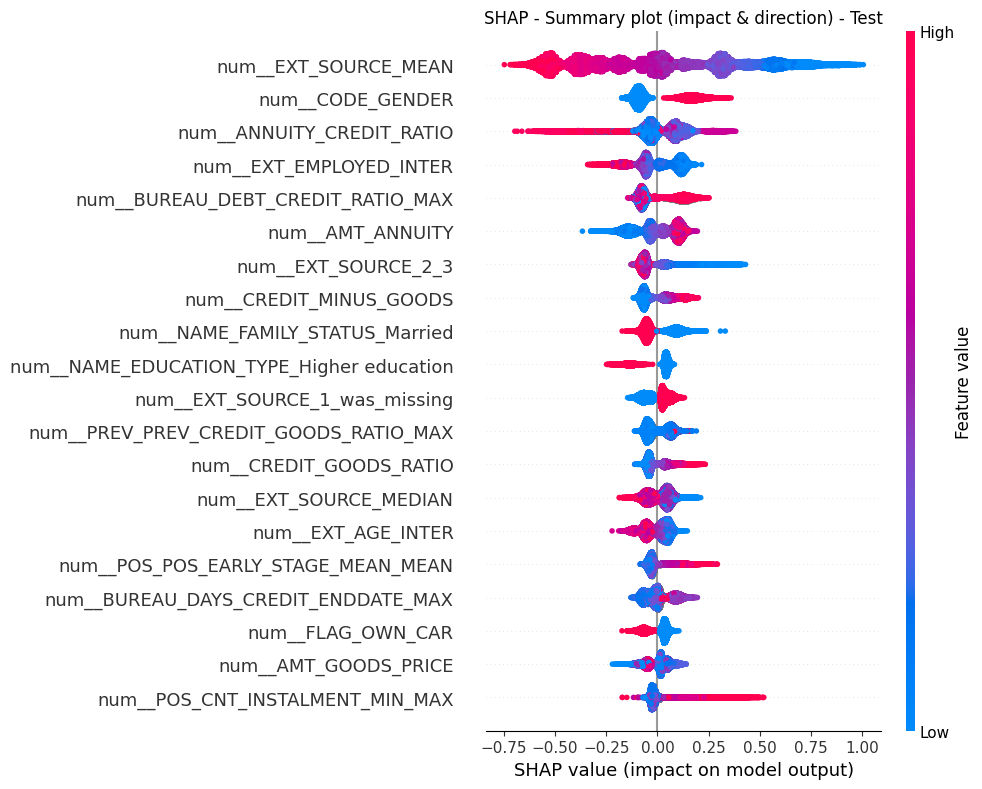

In [ ]:
# Visualisation de l'importance globale (importance + sens de l'effet)

shap.summary_plot(shap_values_pos, X_test_enc_df, max_display=20, plot_size=(10, 8), show=False)
plt.title("SHAP - Summary plot (impact & direction) - Test")
plt.tight_layout()
plt.show()

- Pour le deuxième graphique, c'est un peu pareil mais avec un peu plus de précision. En effet, on a ici deux informations supplémentaires sur l'importance de chaque variable avec d'une part dans quel sens et quelle intensité chaque variable influence la prédiction et d'autre part avec l'échelle à droite on peut interprèter la valeur réelle d'une variable à son influence sur la prédiction du modèle (donc sur la probabilité d'appartenir à la classe 0 ou 1).
- Pour illustrer cela, on peut par exemple prendre la variable **EXT_SOURCE_MEAN** qui est la variable qui influence le plus une prédiction en moyenne. Comme on peut le voir, l'amplitude de son influence est la plus grande et cela positivement ou négativement (avec un peu plus d'influence possible sur les probilité à risque). De plus on peut voir que globalement, plus un client à une valeur élevé pour cette variable plus cela est associé à une diminution du risque (donc il est probable qu'il soit un bon client) et plus cette valeur est faible plus plus cela est associé à une augmentation du risque (défaut).
- De plus, le summary plot SHAP permet également d’évaluer la cohérence des relations apprises par le modèle. En effet, certaines variables clés comme EXT_SOURCE_MEAN présentent une relation monotone et stable avec le risque de défaut, caractérisée par une transition progressive des valeurs SHAP en fonction des valeurs de la variable. À l’inverse, certaines variables montrent une dispersion plus importante (transition moins fluide du bleu au rouge ou inversement), traduisant des interactions ou des effets conditionnels, ce qui est attendu dans un contexte de scoring crédit. Dans l'ensemble, les relations apprises par le modèle sont plutôt cohérente donc on peut garder notre modèle actuel (aucun comportement incohérent susceptible de remettre en cause la fiabilité du modèle n’est observé ici).

#### Importance local des variables de LGBM.

- Après avoir analysé l’importance globale des variables, nous cherchons désormais à comprendre les décisions du modèle à l’échelle individuelle. L’objectif est d’expliquer pourquoi un client donné est classé comme solvable ou défaillant, ce qui est un enjeu central dans un contexte de scoring crédit.

In [61]:
# Récupération des deux types de client pour analyser les résultats obtenus dans ces deux situations.

# Probas sur le test
y_proba_test = pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= optimal_threshold_lgbm).astype(int)

good_candidates = np.where((y_test == 0) & (y_pred_test == 0))[0]
bad_candidates  = np.where((y_test == 1) & (y_pred_test == 1))[0]

# On prend ici les représentations les plus parlantes.
idx_best_cand = good_candidates[np.argmin(y_proba_test[good_candidates])]
idx_worst_cand  = bad_candidates[np.argmax(y_proba_test[bad_candidates])]

print("GOOD  idx:", idx_best_cand, "y_true:", y_test.iloc[idx_best_cand], "y_pred:", y_pred_test[idx_best_cand], "proba:", y_proba_test[idx_best_cand])
print("BAD   idx:", idx_worst_cand,  "y_true:", y_test.iloc[idx_worst_cand],  "y_pred:", y_pred_test[idx_worst_cand],  "proba:", y_proba_test[idx_worst_cand])

c:\Users\Caomghin\miniforge3\envs\projet_7_DS\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



GOOD  idx: 57800 y_true: 0 y_pred: 0 proba: 0.006259709897330142
BAD   idx: 27139 y_true: 1 y_pred: 1 proba: 0.9710155865343195


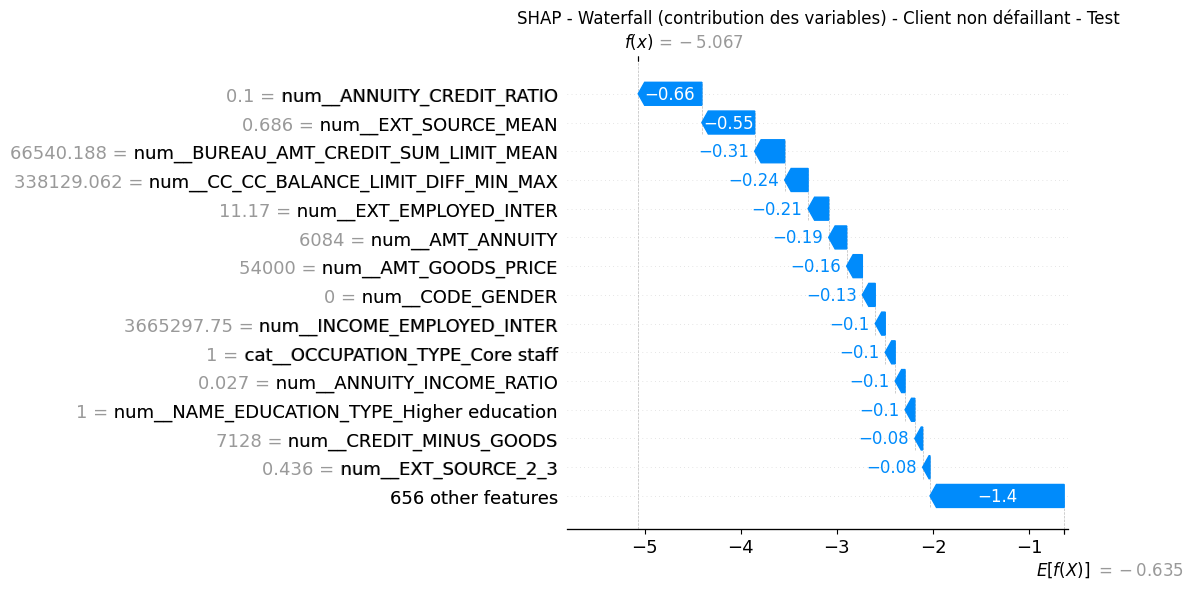

In [70]:
# Visualisation de l'importance locale pour un "bon" client.

exp_good = shap.Explanation(
    values=shap_values_pos[idx_best_cand],
    base_values=base_value,
    data=X_test_enc_df.iloc[idx_best_cand].values,
    feature_names=feature_names
)

shap.plots.waterfall(exp_good, max_display=15, show=False)

plt.gcf().set_size_inches(12, 6)
plt.title("SHAP - Waterfall (contribution des variables) - Client non défaillant - Test")
plt.tight_layout()
plt.show()

- On a ici le graphique Waterfall qui  sert à expliquer une prédiction individuelle d’un modèle, en montrant comment chaque variable contribue à faire passer la prédiction de la valeur de base (prédiction moyenne du modèle ici 
**-0.635** sur le jeu de référence avant de prendre en compte les features d'une observation donnée) vers la prédiction finale pour une observation donnée (**-5,07**). Chaque barre représente la contribution d'une variable (en rouge cela pousse la prédiction vers le haut et en bleu vers le bas et la longueur de la barre est l'importance de l'effet) et la prédiction finale est la somme de la base value + somme des SHAP values.
- Donc dans notre cas (intentionnellement le *meilleur* "bon" client), la prédiction finale est f(x) = -5.07, très éloignée du seuil de décision donc le modèle est très confiant sur le non-défaut.
- La valeur de base du modèle est E[f(X)] = -0.635, donc le client est fortement déplacé vers la classe “bon payeur” par ses caractéristiques.
- Les contributions majeures sont toutes négatives, ce qui est exactement ce qu’on attend pour un bon client, avec ici un score externe élevé qui est un signal très fort de solvabilité (*EXT_SOURCE_MEAN* = **0.68** et *shap* = **-0.66**); une faible charge d’annuité par rapport au crédit diminue le risque (*ANNUITY_CREDIT RATIO* = **0.1** et *shap* = **-0.55**) ou encore l'historique de crédit sain avec limites disponibles élevées (*BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN* = **66 540** et *shap* =**-0.31**).
- Ce graphique pourra être utile pour expliquer la prédiction du modèle à un client si besoin.

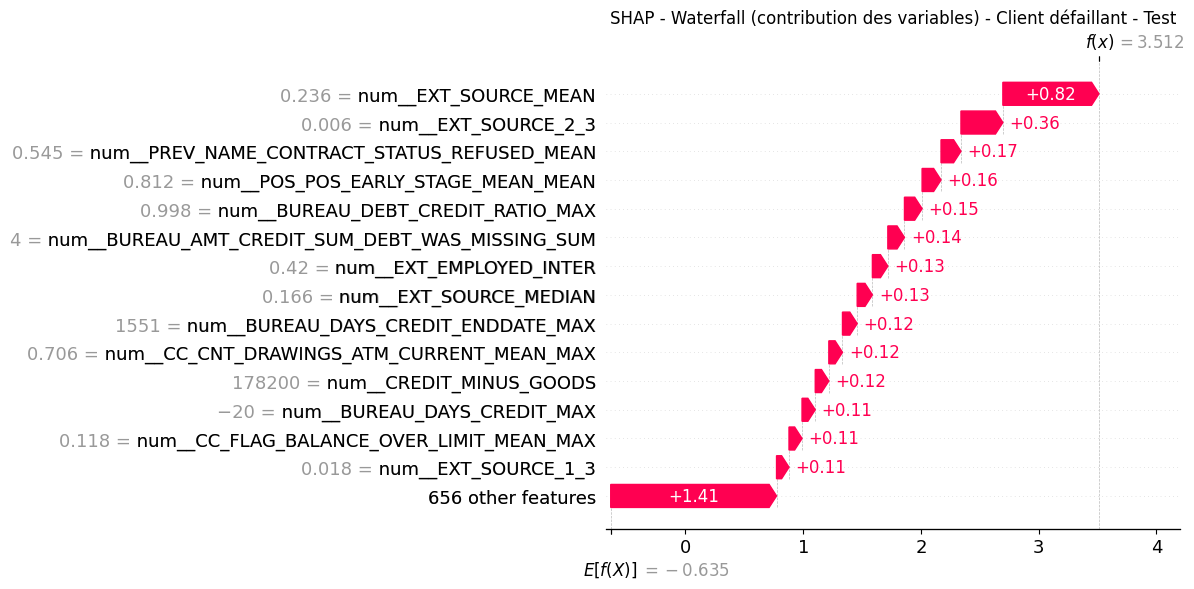

In [69]:
# Visualisation de l'importance locale pour un client défaillant.

exp_good = shap.Explanation(
    values=shap_values_pos[idx_worst_cand],
    base_values=base_value,
    data=X_test_enc_df.iloc[idx_worst_cand].values,
    feature_names=feature_names
)

shap.plots.waterfall(exp_good, max_display=15, show=False)

plt.gcf().set_size_inches(12, 6)
plt.title("SHAP - Waterfall (contribution des variables) - Client défaillant - Test")
plt.tight_layout()
plt.show()

- Pour ce deuxième graphique, on a pris le cas d'un client défaillant prédit défaillant donc le graphique est globalement inversé puisque toutes les contributions sont positives. La prédiction finale est f(x) = **3.51** donc bien au-dessus du seuil de **-0.635** (modèle de nouveau confiant pour sa prédicition de défaut puisqu'on est loin de la valeur par défaut).
- Les contributions les plus fortes poussant vers la classe défaillante sont *EXT_SOURCE_MEAN* = 0.23 (pour une shap value = **+0.82**) donc score externe faible qui augmente le facteur risque suivi de nouveau, de sources externes qui impactent défavorablement le sens de la décision pour le client (*EXT_SOURCE_2_3* = **0.006** et shap = **+0.36**) ou encore la variable *PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN* qui met un avant un historique de demande défavorable (plus de refus que de réponse favorable) ce qui est un signal très pertinent ici (valeur réelle = **0.54** et shap = **+0.17**) donc les différents éléments sont liés aux sources externes, au bureau de crédit ou même aux retards de paiements s'additionnent de maniére cohérente.

- Globalement, l’analyse SHAP locale confirme que le modèle LGBM base ses décisions sur des facteurs économiquement interprétables et cohérents avec le risque de défaut. Les prédictions, qu’elles concernent un client solvable ou défaillant, reposent sur une combinaison de signaux robustes issus des scores externes, de la structure d’endettement et de l’historique crédit, renforçant la confiance dans l’utilisation du modèle en contexte métier.
- Il serait possible d'aller plus loin en analysant les cas où le modèle se trompe (donc les FN et FP) puisque l’analyse SHAP permet d’interpréter les contributions individuelles des variables ayant conduit un client à être classé au-dessus ou en dessous du seuil de décision. Cette approche permettrait d'avoir plus d'informations sur les faux négatifs, particulièrement coûteux, en identifiant les facteurs ayant sous-estimé le risque de défaut (donc par exemple on filtre seulement les cas où le modèle à prédit un client défaillant en client solvable (FN) puis on analyse l’importance globale du modèle sur cette sous-population qui est la plus coûteuse).

Maintenant que nous avons mené une démarche complète de modélisation supervisée dans le cadre d’un projet de scoring crédit, en tenant compte à la fois des contraintes et des enjeux métier, nous pouvons passer à la phase suivante du projet, dédiée à la lecture des résultats à travers un tableau de bord interactif, permettant d’explorer les prédictions, les scores et les explications du modèle.

In [41]:
# Export d'un échantillon du dataset de test pour la partie suivante (car le fichier est trop lourd github).

df_test_final = test_dfs["median_mode"].copy()
df_test_final_sample = df_test_final.sample(n=10000, random_state=42)

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

with open(OUTPUT_DIR / "clients_production_sample.pkl", "wb") as f:
    pickle.dump(df_test_final_sample, f)

In [59]:
# Export du modèle final à l'aide de joblib (car dossier mlruns trop lourd pour github).

MODEL_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(pipeline, MODEL_DIR / "model.joblib")


['c:\\Users\\Caomghin\\Desktop\\Implementer_un_modele_de_scoring\\api\\model_prod\\model.joblib']